In [1]:
import copy
import time
import os 
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
from scipy import io as sio
from scipy.stats import normaltest
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.model_selection import train_test_split
from pprint import pprint

## k-Nearest Neighbour (kNN) Classifier analysis

In this notebook, we compute the k-Nearest Neighbor (kNN) classifier accuracy results for the raw data for the frequency selective ROIs for each brain region and choose the optimal k to be used for a further step where we compute the kNN for the same dataset, but with uniformly random reassignment of frequency labels. This is done in order to evaluate whether the dataset shows specific non-random spatial distribution of frequency selective ROIs.

In [2]:
mat_fpath = r'E:\PhD\BWAP\20200804_ROI_per_brain_region_to_python_25sd_wmergedsides_FINAL.mat'
zero_to_add_fpath = r'E:\PhD\BWAP\zero_only_labels_to_add.mat'
folder_path = os.path.split(mat_fpath)[0]

Adding 0 labels to Cerebellum:
Working on the Cerebellum
The optimal K is 6


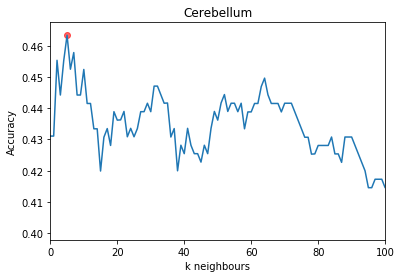

Adding 0 labels to Hindbrain:
Working on the Hindbrain
The optimal K is 10


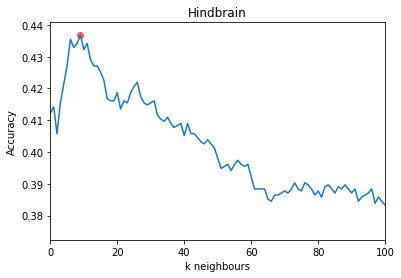

Adding 0 labels to OLN:
Working on the OLN
The optimal K is 6


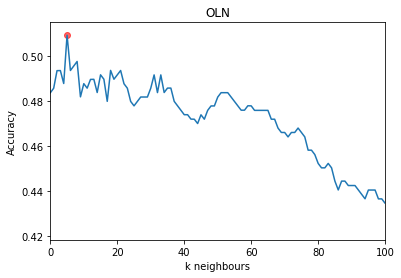

Adding 0 labels to TS:
Working on the TS
The optimal K is 91


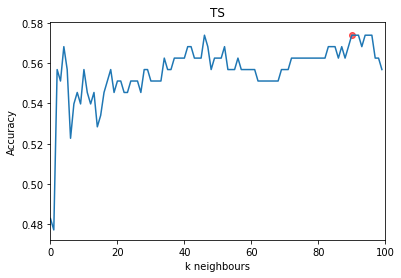

Adding 0 labels to Tectum:
Working on the Tectum
The optimal K is 7


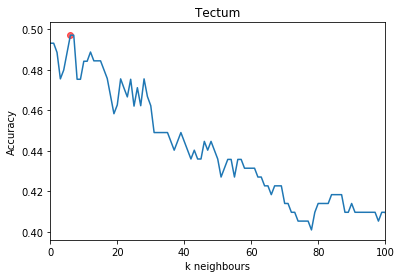

Adding 0 labels to Tegmentum:
Working on the Tegmentum
The optimal K is 27


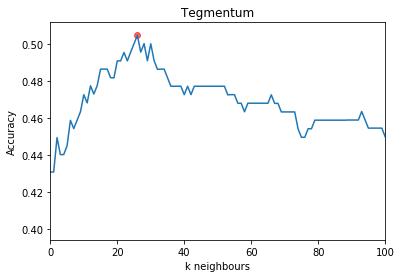

Adding 0 labels to Telencephalon:
Working on the Telencephalon
The optimal K is 12


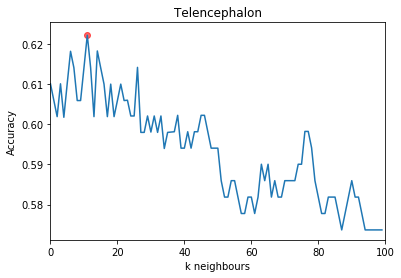

In [3]:
#load roi mat files 
ROIS = sio.loadmat(mat_fpath)
# load mat file with coordinates around the brain region with `0` labels 
zero_to_add = sio.loadmat(zero_to_add_fpath)

metadata = ['__header__', '__version__', '__globals__']

# cross-validation K-fold split is 10, unless the minimum number of rois for a single frequency (k) is lower, then use k 
cv_split = {'Cerebellum' : 10, 'Hindbrain' : 10, 'Tectum' : 10, 'OLN' : 10, 'TS': 4, 'Telencephalon': 5, 'Tegmentum' : 4}

# save optimal k value for the keys in ROIs
cv_results_dict = {}

for key, value in ROIS.items():
    if key not in metadata: 
        print("Adding 0 labels to {}:".format(key))
        value = np.vstack((value, np.array(list(zero_to_add[key]),dtype='int32')))
        
        # find optimal radius for RNC
        print('Working on the', key)
        neighbors_list = list(range(1,150,1))
        cv_scores = [ ]
        for K in neighbors_list:
            if (key == 'Telencephalon' or key == 'TS')and K > 100:
                pass
            else:
                knn =  KNeighborsClassifier(n_neighbors = K, weights='distance')
                scores = cross_val_score(knn, value[:,0:3], value[:,-1], cv=cv_split[key], scoring="accuracy")
                cv_scores.append(scores.mean())

        # Changing to misclassification error
        mse = [1-x for x in cv_scores]
        # determing best k
        optimal_k = neighbors_list[mse.index(min(mse))]
        cv_results_dict.update({key : {'opt_k' : optimal_k, 'scores' : cv_scores}})
        print("The optimal K is {}".format(optimal_k))

        # print results and point out the optimal (red) in the plot as well as the chosen radius (green)
        plt.plot(cv_scores)
        plt.scatter(optimal_k-1,cv_scores[optimal_k-1], c='red', alpha=0.6)
        plt.xlim([0,100])
        plt.title(key)
        plt.ylabel('Accuracy')
        plt.xlabel('k neighbours')
        plt.show()
        

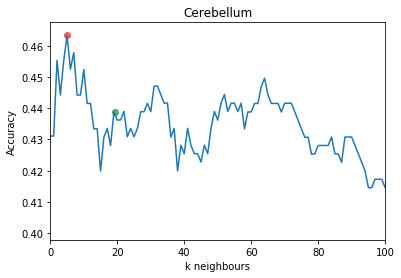

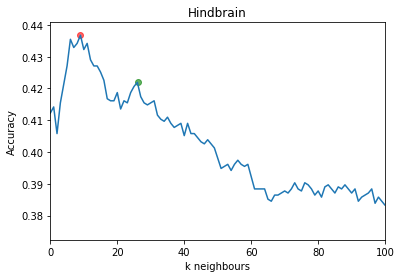

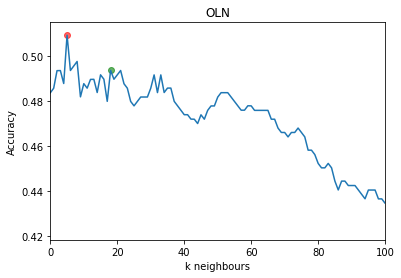

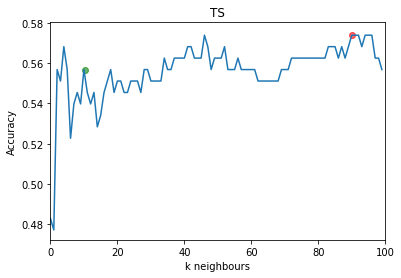

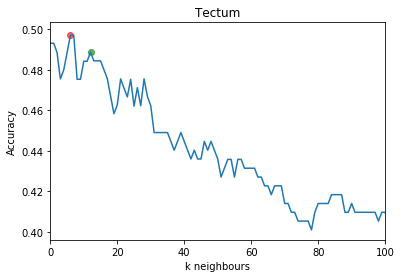

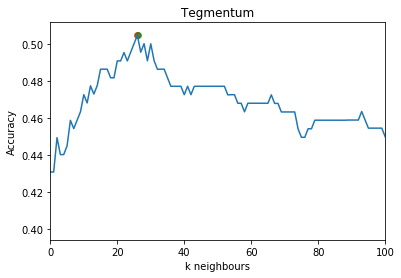

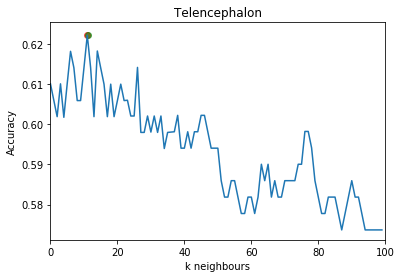

In [4]:
# In the first run, the values below are likely to be incorrect, change them to plot the chosen k for further steps
# these are the k values to be used in the further analyses (same as in the previous cell)
k_neighbors = {'Cerebellum' : 20, 'Hindbrain' : 27, 'Tectum' : 13, 'OLN' : 19, 'TS': 11, 'Telencephalon': 12, 'Tegmentum' : 27}

for key, value in ROIS.items():
    if key not in metadata: 
        # print results and point out the optimal (red) in the plot as well as the chosen radius (green)
        plt.plot(cv_results_dict[key]['scores'])
        plt.scatter(cv_results_dict[key]['opt_k']-1,cv_results_dict[key]['scores'][cv_results_dict[key]['opt_k']-1], c='red', alpha=0.6)
        plt.scatter(k_neighbors[key]-0.8,cv_results_dict[key]['scores'][k_neighbors[key]-1], c='green', alpha=0.6)
        plt.xlim([0,100])
        plt.title(key)
        plt.ylabel('Accuracy')
        plt.xlabel('k neighbours')
        plt.show()

With the results shown above, we were able to choose a value of k for each brain region that would reoughly optimal to then obtain the fraction of neighbors from each frequency for a determined main frequency (e.g. what is the fraction of 250, 500, and 750 Hz neighbors do the 100 Hz ROIs have?). As you may have seen, the k chosen was not necessarily the one that yielded the highest accuracy (in most cases the accuracy does not even vary considerably, being within a range +- 0.05) as we also want to reduce variability of the fraction calculated by chosing a k that is not too small. Our criteria was to choose a k higher than 10 but lower than 20% of the total number of ROIs in that brain region.  

In [5]:
#reload rois since I added points to MON in previous cells
ROIS = sio.loadmat(mat_fpath)

metadata = ['__header__', '__version__', '__globals__']

# create a dictionary to store fractions of neighbouring ROIs per frequency and a summary dictionary with 
# the mean and std value calculated based on the number of ROIs per frequency
neighbor_dist = {}
neighbor_dist_summary = {}

# setup the dictionary so its keys are brain regions in ROIS.keys() and value is a another dictionary
for key, value in ROIS.items():
    if key not in metadata: 
        neighbor_dist.update({key : {}})
        neighbor_dist_summary.update({key : {}})
        
        labels = np.unique(value[:,-1])
        for label in labels:
            neighbor_dist[key].update({str(label) : None})
            neighbor_dist_summary[key].update({str(label) : {}})

start = time.time()
for key, value in ROIS.items():
    if key not in metadata: 
        # compute distances 
        distances = squareform(pdist(value[:,0:3]))
        print(key, 'shape')
        print(value[:,0:3].shape)
        
        labels = np.unique(value[:,-1])
        print('frequencies present in this brain region:')
        print(labels)
        
        for label in labels:
            distances_single_freq = distances[value[:,-1]==label,:]      
            
            for roi in distances_single_freq: 
                # get the k-nearest neighbors
                sorted_dist = np.sort(roi)[1:k_neighbors[key]+1]
                # get indices of these neighbors and then get their frequency label
                indices = np.asarray([True if dist in sorted_dist else False for dist in roi])
                neighbor_labels = value[indices,-1]
                #print(neighbor_labels)
                # count the number of occurrences for each label in the k neighbors of this particular roi
                counter = np.reshape(np.asarray([sum(neighbor_labels == label) for label in labels]),(1,-1))
                #print(counter)
                #print(counter.shape)
                if neighbor_dist[key][str(label)] is None:
                    neighbor_dist[key][str(label)] = counter / k_neighbors[key]
                else:
                    neighbor_dist[key][str(label)] = np.vstack((neighbor_dist[key][str(label)], counter / k_neighbors[key]))
        
            neighbor_dist_summary[key][str(label)].update({'mean' : np.mean(neighbor_dist[key][str(label)], axis=0), 'std' : np.std(neighbor_dist[key][str(label)], axis=0)})
end = time.time()
print("elapsed time: {}".format(end-start))

# verify results 
pprint(neighbor_dist_summary)

Cerebellum shape
(359, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
Hindbrain shape
(1537, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
OLN shape
(501, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
TS shape
(166, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2500]
Tectum shape
(219, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
Tegmentum shape
(208, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
Telencephalon shape
(236, 3)
frequencies present in this brain region:
[ 100  250  500  750 1000 1500 2000 2500]
elapsed time: 8.611011505126953
{'Cerebellum': {'100': {'mean': array([0.10277778, 0.04722222, 0.06388889, 0.23888889, 0.15      ,
       0.18611111, 0.10555556, 0.10555556]),
                        'std': array([0.05645112, 0.08575194, 0.04656404, 0.

In [6]:
#Perform the exact same procedure, but with a labels assigned randomly (with an uniform distribution)
neighbor_dist_rand = {}
neighbor_dist_rand_summary = {}
for key, value in ROIS.items():
    if key not in metadata: 
        neighbor_dist_rand.update({key : {}})
        neighbor_dist_rand_summary.update({key : {}})
        
        labels = np.unique(value[:,-1])
        if key == 'TS':
            labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])
                
        for label in labels:
            neighbor_dist_rand[key].update({str(label) : None})
            neighbor_dist_rand_summary[key].update({str(label) : {}})

In [7]:
# choose the number of time you wish to run the randomized nearest neighbors 
n_iter = 100

start = time.time()

for key, value in ROIS.items():
    start2 = time.time()
    if key not in metadata: 
        for k in range(n_iter):
            if (k+1)%100 == 0 or k == 0:
                print('Iteration ',str(k+1))
            # generate a set of indices with an uniform distribution for each iteration 
            # only done once in the first run, number of columns have size n_iter
            
            if k == 0:
                rand_indices = np.zeros((len(value),n_iter))
                for i in range(n_iter):
                    rnd_idx = np.random.choice(len(value),len(value))
                    #print(rnd_idx)
                    rand_indices[:,i] = rnd_idx
                    
            # compute distances 
            distances = squareform(pdist(value[:,0:3]))

            labels = np.array([100, 250, 500, 750, 1000, 1500, 2000, 2500])
            if key == 'TS':
                labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])

            # Reassign labels to ROIs
            rand_idx = rand_indices[:,k].astype('int')
            #print('before')
            #print(value[:,-1])
            new_labels = value[rand_idx,-1]
            #print('after')
            #print(value[:,-1])
            for label in labels:
                #print("label: {}".format(label))
                distances_single_freq = distances[new_labels==label,:]      

                count = 0
                for roi in distances_single_freq:
                    #get the k nearest neighbors
                    sorted_dist = np.sort(roi)[1:k_neighbors[key]+1]
                    indices = np.asarray([True if dist in sorted_dist else False for dist in roi])
                    neighbor_labels = value[indices,-1]

                    # count the number of occurrences for each label in the k neighbors of this particular roi
                    counter = np.reshape(np.asarray([sum(neighbor_labels == label) for label in labels]),(1,-1))
  
                    if count == 0:   
                        #print("first roi in label {} of {}".format(label,key))
                        #print('new temp_ created')
                        temp_ = counter / k_neighbors[key]
                        count+=1
                    else:
                        temp_ = np.vstack((temp_,counter / k_neighbors[key]))
                    #print('temp_ variable last value')
                    #print(temp_[-1,:])

                if neighbor_dist_rand[key][str(label)] is None:
                    print("first time storing in neighbor_dist_rand[{}][{}]".format(key,label))
                    neighbor_dist_rand[key][str(label)] = temp_     
                else:
                    #print(temp_[-1,:])
                    neighbor_dist_rand[key][str(label)] = np.vstack((neighbor_dist_rand[key][str(label)], temp_))

                mean_ = np.mean(temp_, axis=0)
                std_ = np.std(temp_, axis=0)        
                
                if not any(neighbor_dist_rand_summary[key][str(label)]):    
                    neighbor_dist_rand_summary[key][str(label)].update({'mean' : mean_, 'std' : std_})
                else:
                    neighbor_dist_rand_summary[key][str(label)]['mean'] = np.vstack((neighbor_dist_rand_summary[key][str(label)]['mean'], mean_))
                    neighbor_dist_rand_summary[key][str(label)]['std'] = np.vstack((neighbor_dist_rand_summary[key][str(label)]['std'] ,std_))


            if (k+1)%50 == 0:
                print("gone through {} in {}-th iteration with {} seconds elapsed...".format(key , str(k+1), str(time.time()-start2)))
        end = time.time()
        print("elapsed time so far: {}".format(end-start))
print('Finished calculations')

Iteration  1
first time storing in neighbor_dist_rand[Cerebellum][100]
first time storing in neighbor_dist_rand[Cerebellum][250]
first time storing in neighbor_dist_rand[Cerebellum][500]
first time storing in neighbor_dist_rand[Cerebellum][750]
first time storing in neighbor_dist_rand[Cerebellum][1000]
first time storing in neighbor_dist_rand[Cerebellum][1500]
first time storing in neighbor_dist_rand[Cerebellum][2000]
first time storing in neighbor_dist_rand[Cerebellum][2500]
gone through Cerebellum in 50-th iteration with 22.20383381843567 seconds elapsed...
Iteration  100
gone through Cerebellum in 100-th iteration with 44.45033407211304 seconds elapsed...
elapsed time so far: 44.45033407211304
Iteration  1
first time storing in neighbor_dist_rand[Hindbrain][100]
first time storing in neighbor_dist_rand[Hindbrain][250]
first time storing in neighbor_dist_rand[Hindbrain][500]
first time storing in neighbor_dist_rand[Hindbrain][750]
first time storing in neighbor_dist_rand[Hindbrain][1

In [8]:
#verify results
print(neighbor_dist_rand_summary['Cerebellum']['250']['mean'].shape)
print(neighbor_dist_rand_summary['Cerebellum']['250'])
print(neighbor_dist_rand['Cerebellum']['250'].shape)
print(neighbor_dist_rand['Cerebellum']['100'])
#create new dictionary so save summarized version of the randomized results, 
# as there are n_iter values of the fractions of neighbors
neighbor_dist_rand_mean_summary = copy.copy(neighbor_dist_rand_summary)

(100, 8)
{'mean': array([[0.03      , 0.084     , 0.1       , 0.162     , 0.182     ,
        0.246     , 0.048     , 0.148     ],
       [0.05625   , 0.0765625 , 0.0796875 , 0.178125  , 0.184375  ,
        0.2375    , 0.0703125 , 0.1203125 ],
       [0.064     , 0.058     , 0.084     , 0.246     , 0.212     ,
        0.15      , 0.072     , 0.116     ],
       [0.0578125 , 0.078125  , 0.078125  , 0.228125  , 0.1796875 ,
        0.18125   , 0.071875  , 0.1265625 ],
       [0.05833333, 0.05833333, 0.08541667, 0.1875    , 0.17083333,
        0.26666667, 0.075     , 0.1       ],
       [0.05208333, 0.05416667, 0.07708333, 0.24375   , 0.19583333,
        0.20625   , 0.1125    , 0.06041667],
       [0.07      , 0.07666667, 0.08666667, 0.18      , 0.15833333,
        0.24666667, 0.08333333, 0.1       ],
       [0.054     , 0.054     , 0.08      , 0.204     , 0.24      ,
        0.238     , 0.044     , 0.09      ],
       [0.07407407, 0.10185185, 0.07777778, 0.2037037 , 0.13333333,
        0.

Now with quite many results computed, some summary results will also be computed and you may choose to save things with the `save_flag` variable set to `True`

getting full data of random runs from Cerebellum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


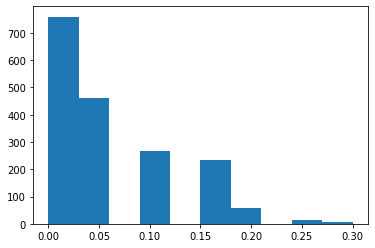

2.6308994974994787e-45


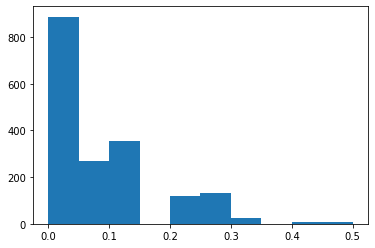

3.3557309975174737e-96


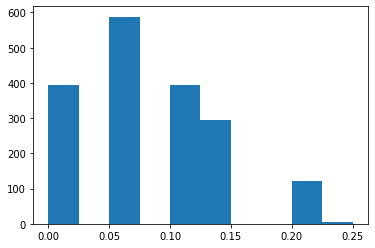

2.8268334761166075e-31


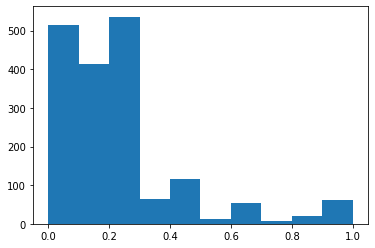

5.884552516497735e-122


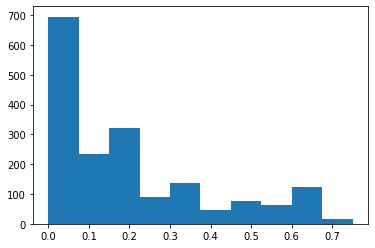

7.3132670660001915e-53


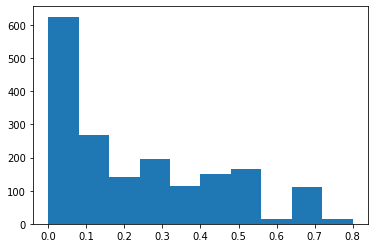

1.1784505447073443e-39


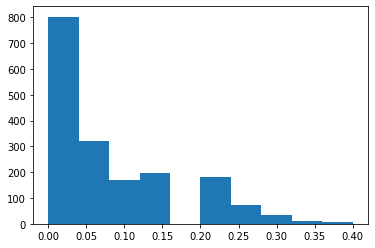

6.632959810394533e-55


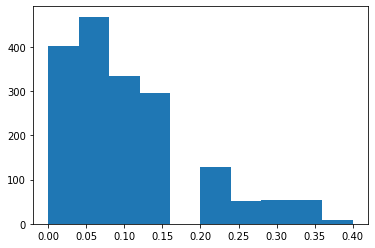

1.6814962421733433e-57


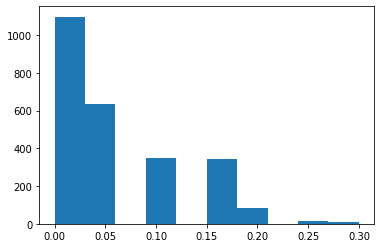

1.9046959119844642e-63


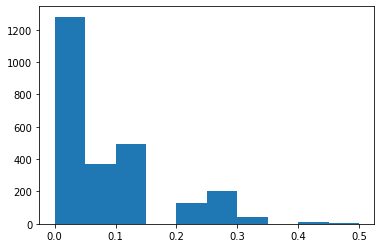

2.2669939957644294e-132


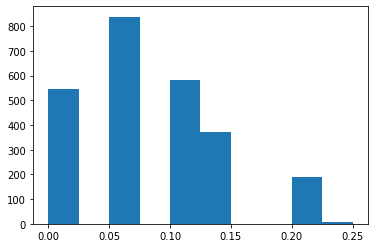

4.5528368133382204e-39


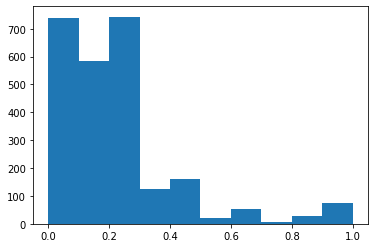

9.157891997224329e-183


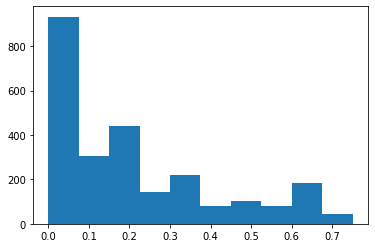

1.6657433728242486e-67


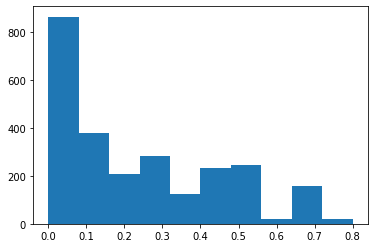

6.744365493987678e-60


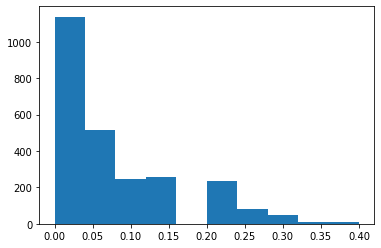

3.1915752480725663e-91


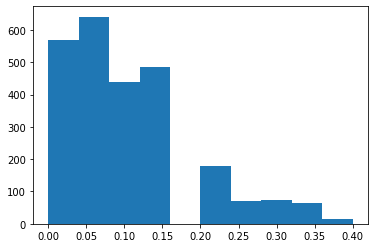

1.0632440750738794e-76


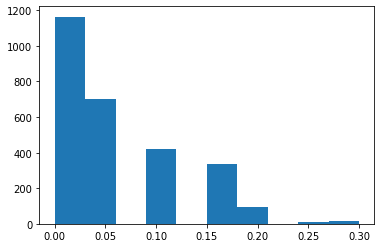

8.986593762058451e-76


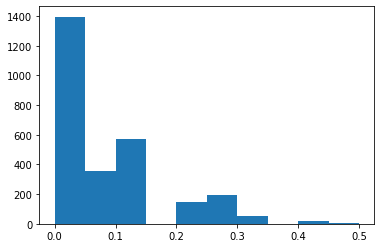

4.022925661574628e-139


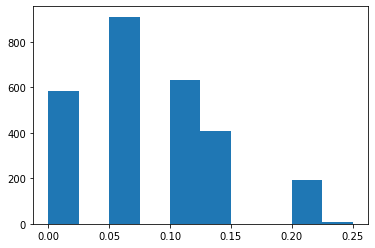

2.54593529105747e-40


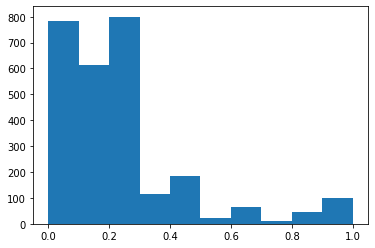

2.79288063365081e-179


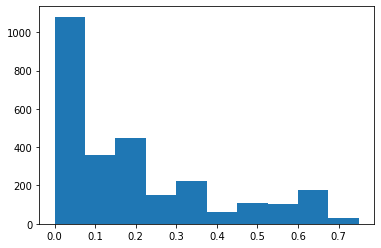

2.85480560388065e-82


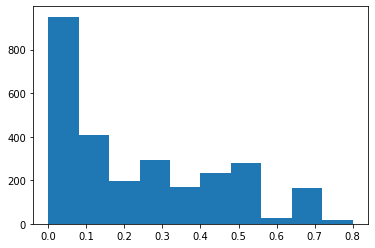

5.919108207126472e-71


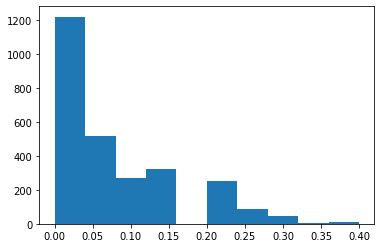

8.074820625861715e-84


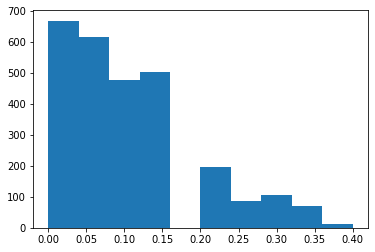

3.4936809959153784e-70


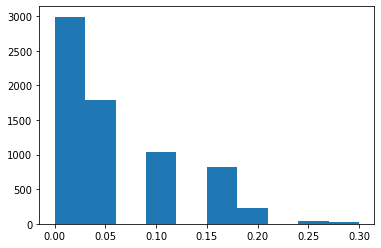

3.818863168515893e-189


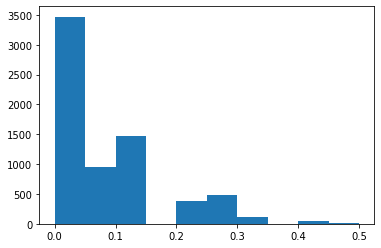

0.0


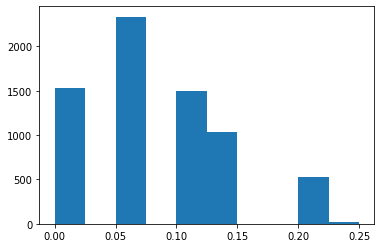

8.583561404083154e-119


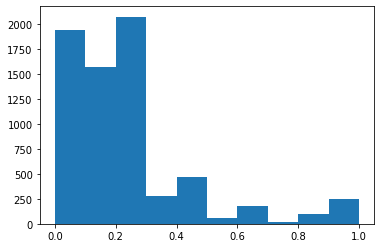

0.0


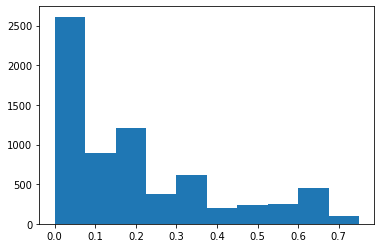

1.0396037400194035e-200


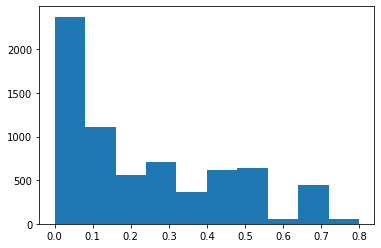

1.3323904463899543e-156


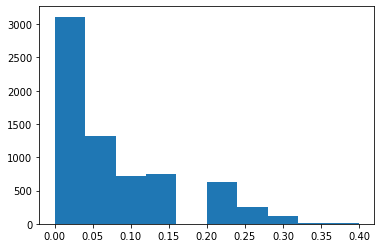

1.988452821088968e-209


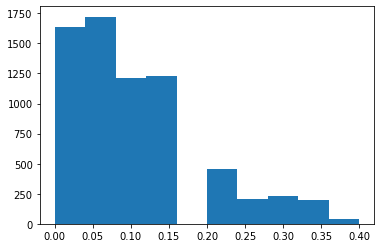

6.654284420089509e-210


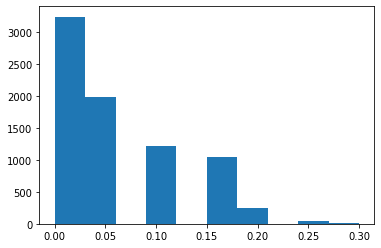

4.3690630846514265e-174


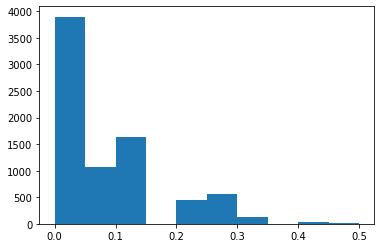

0.0


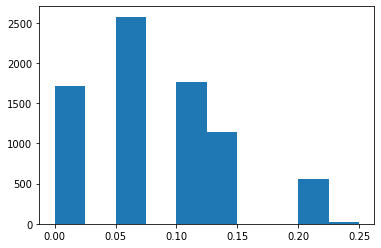

1.3122793851784786e-117


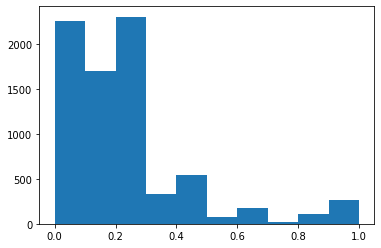

0.0


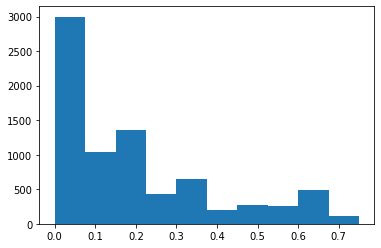

4.763265463622879e-240


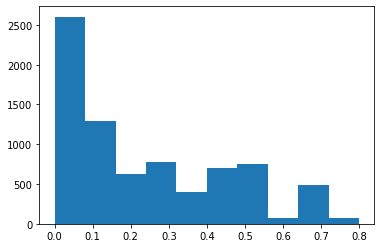

1.34813581225584e-183


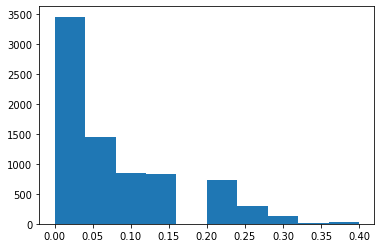

3.80935356442767e-227


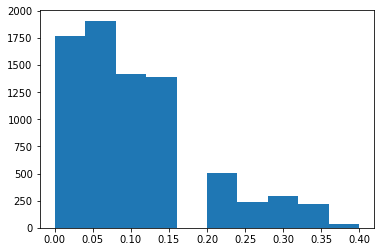

9.423512555518606e-220


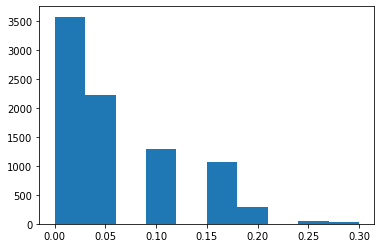

5.270708661324503e-214


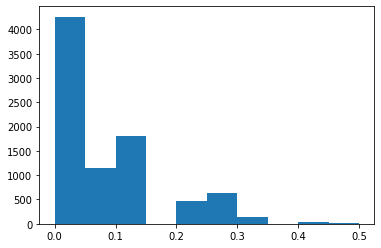

0.0


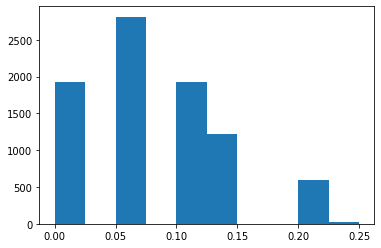

9.930576941428691e-127


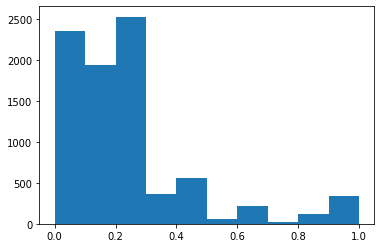

0.0


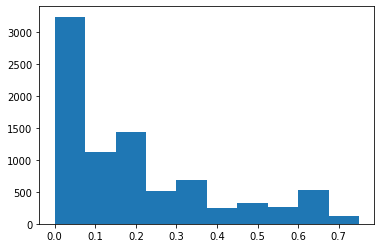

5.709097605994817e-255


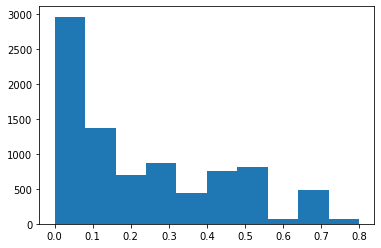

2.3750567776158316e-189


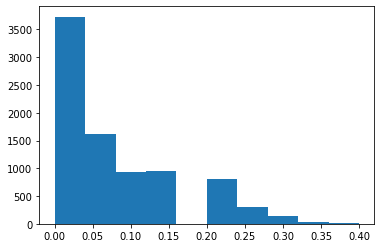

5.366767169977272e-245


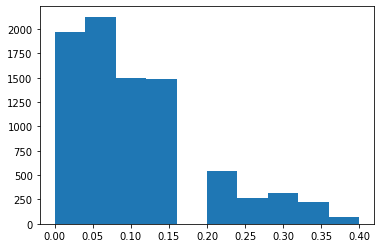

2.417436798603594e-258


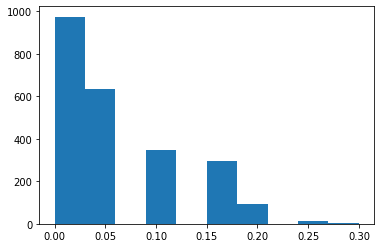

4.68178937117245e-54


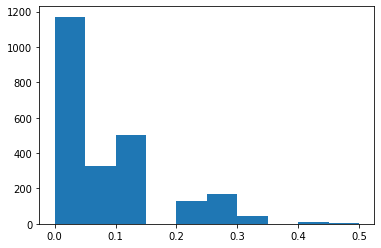

2.7331552411737945e-117


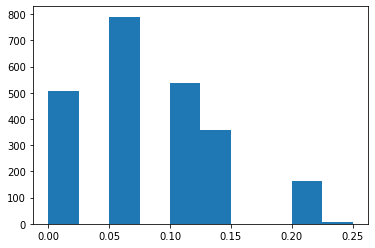

3.237418071791953e-36


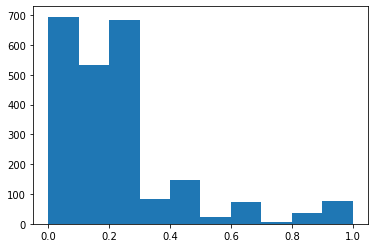

3.1015023651409823e-156


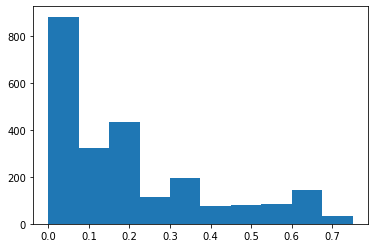

1.14634614920085e-72


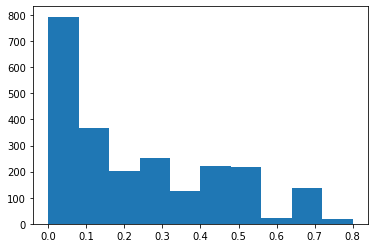

1.3360152070414708e-51


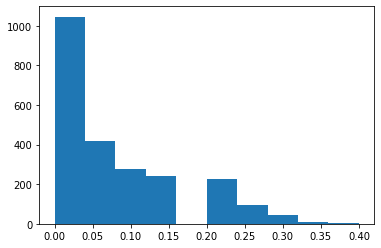

5.2194699423411205e-65


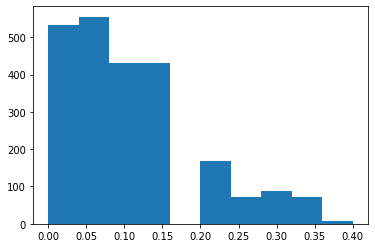

1.814385721109672e-62


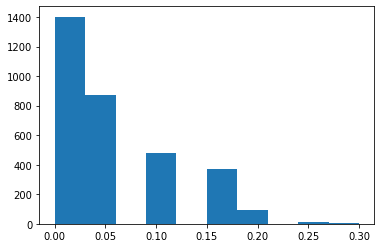

1.2861886283179866e-88


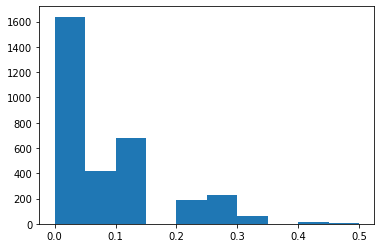

1.0742617574629725e-167


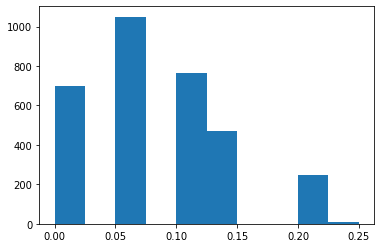

6.439295344324762e-52


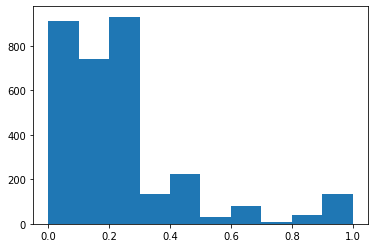

1.4302507238166002e-212


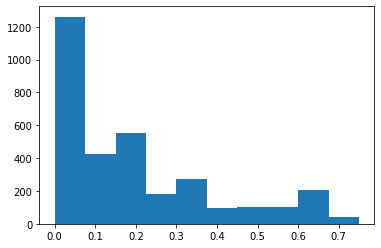

4.3895590863217524e-101


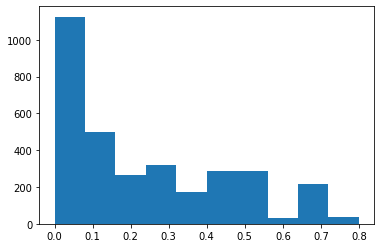

7.252084904033307e-73


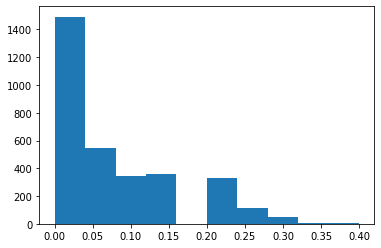

2.2425937069637498e-85


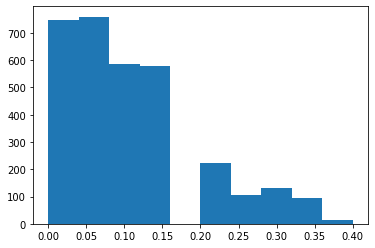

2.21900523932398e-85
getting full data of random runs from Hindbrain
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


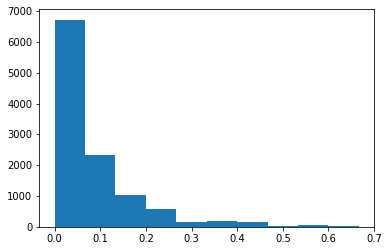

0.0


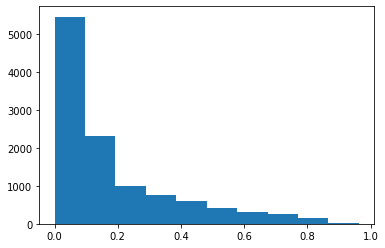

0.0


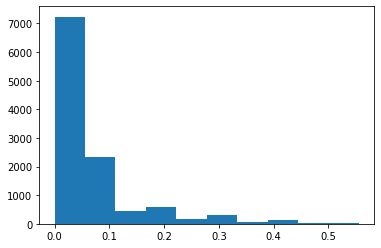

0.0


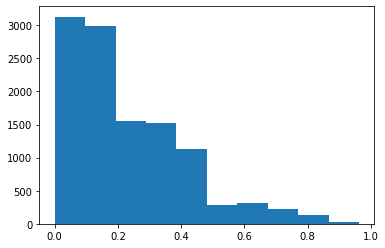

0.0


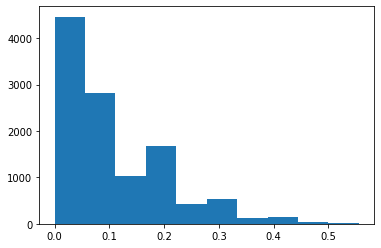

0.0


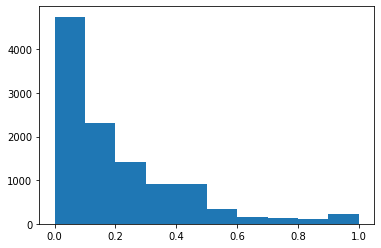

0.0


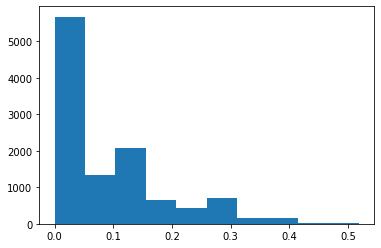

0.0


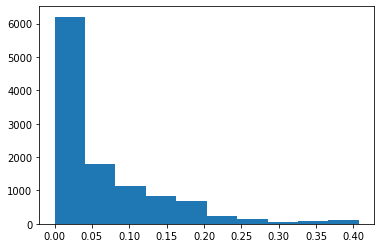

0.0


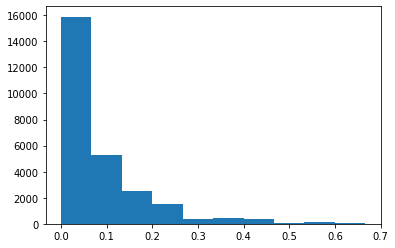

0.0


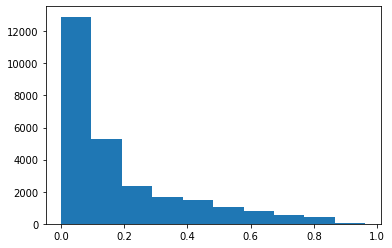

0.0


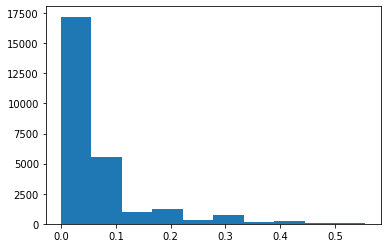

0.0


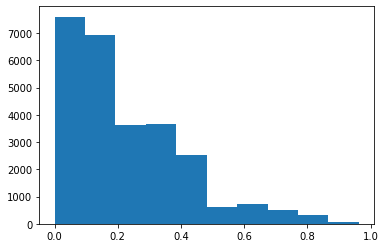

0.0


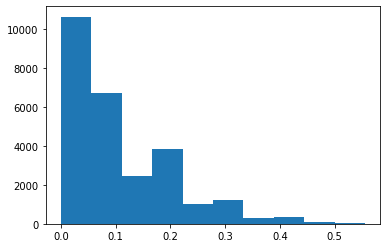

0.0


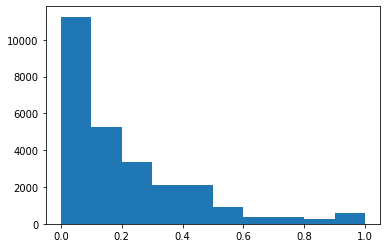

0.0


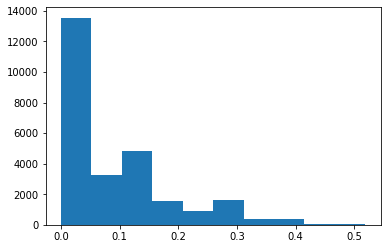

0.0


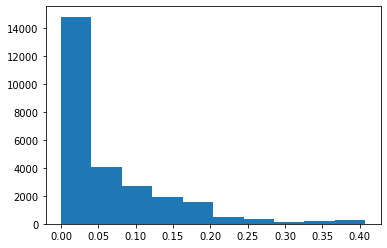

0.0


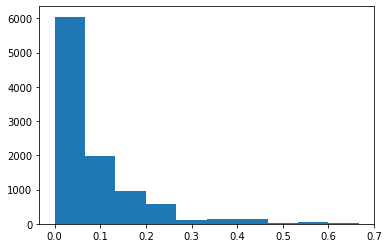

0.0


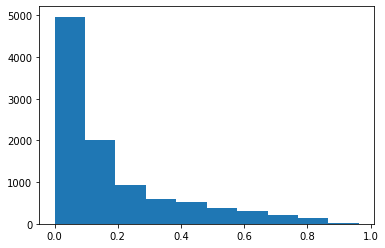

0.0


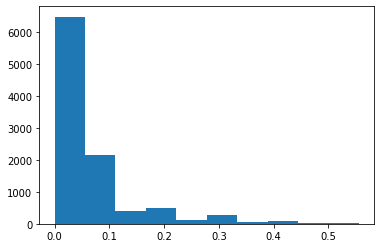

0.0


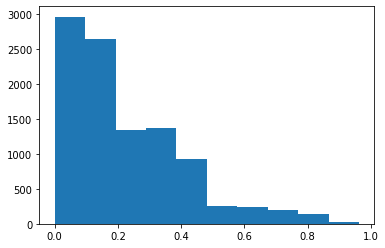

0.0


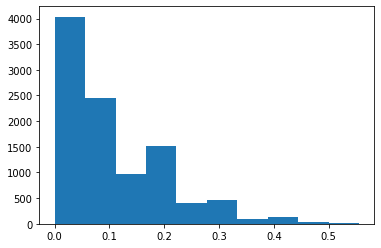

6.826138445996879e-303


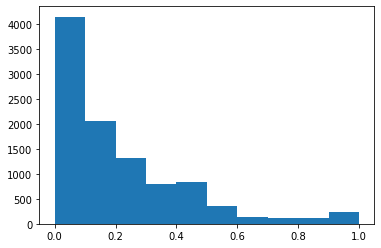

0.0


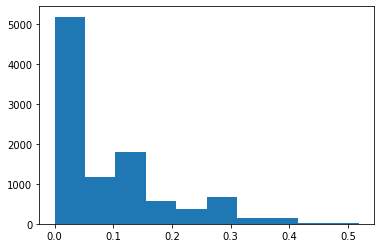

0.0


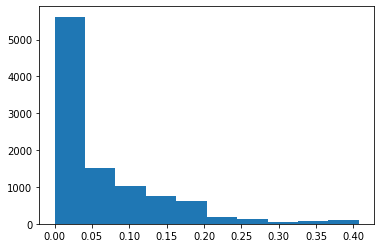

0.0


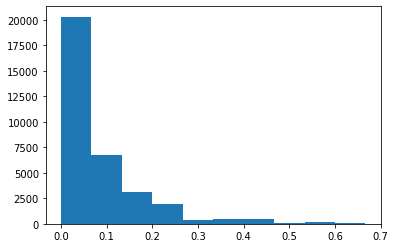

0.0


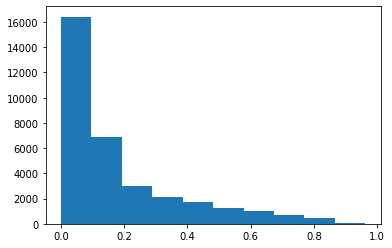

0.0


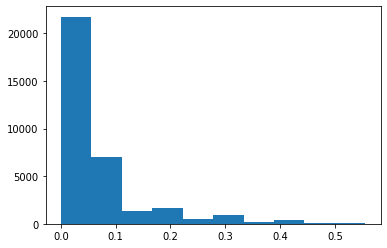

0.0


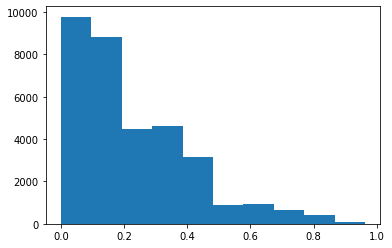

0.0


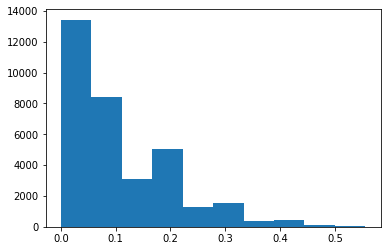

0.0


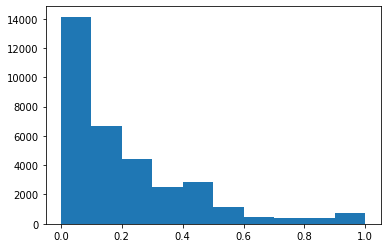

0.0


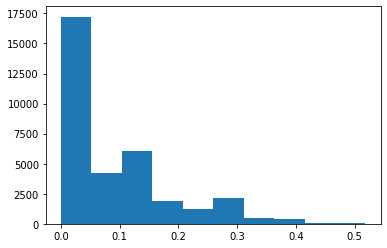

0.0


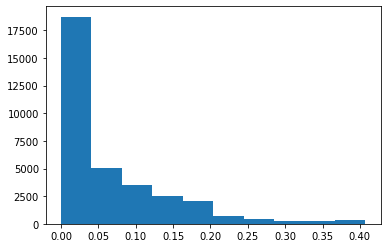

0.0


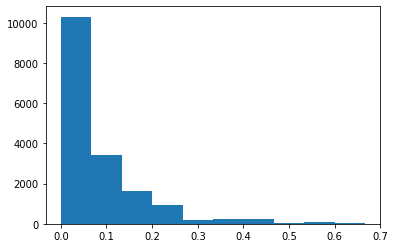

0.0


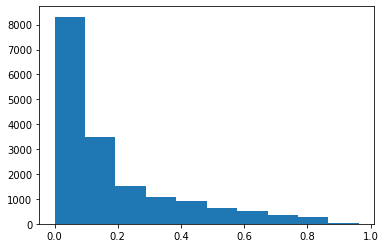

0.0


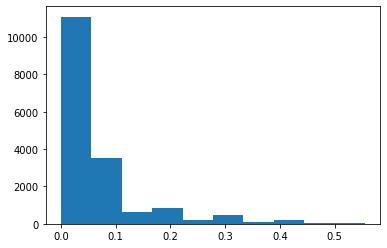

0.0


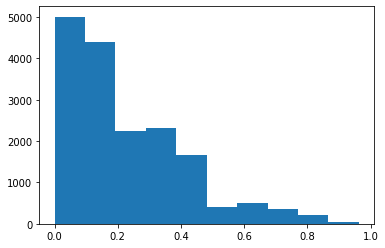

0.0


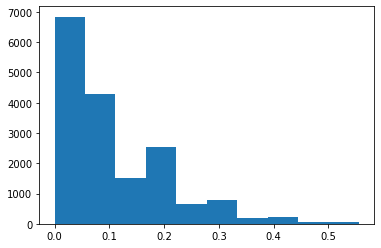

0.0


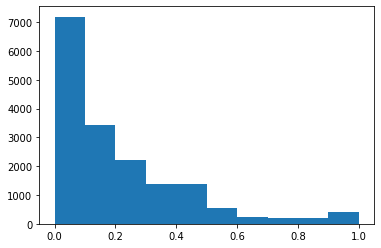

0.0


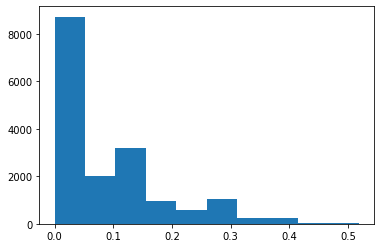

0.0


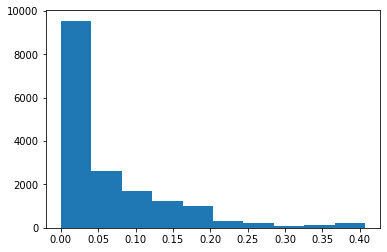

0.0


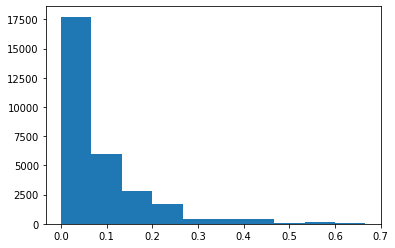

0.0


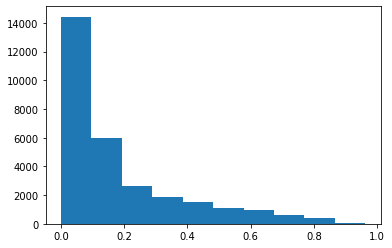

0.0


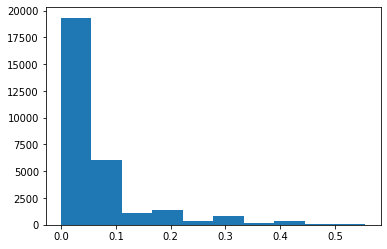

0.0


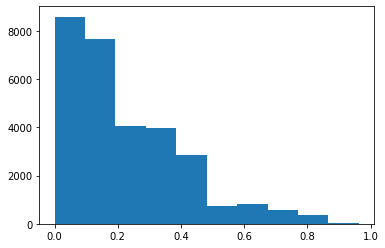

0.0


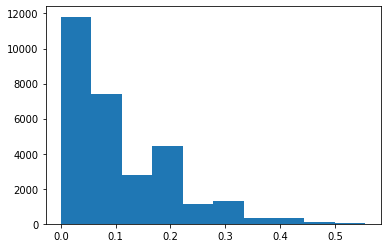

0.0


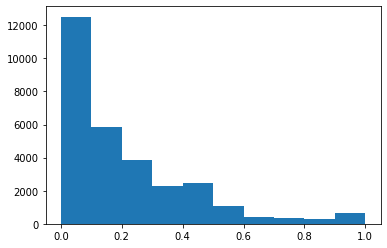

0.0


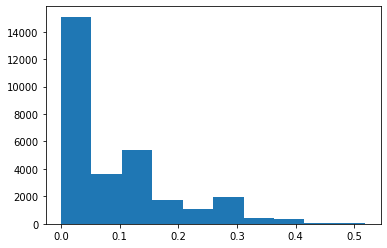

0.0


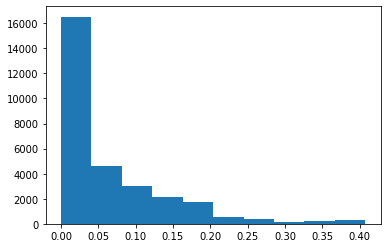

0.0


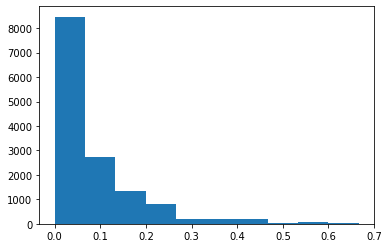

0.0


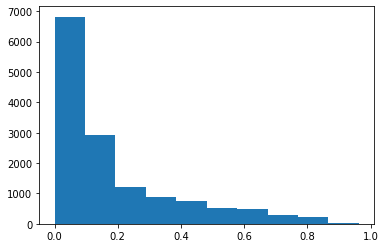

0.0


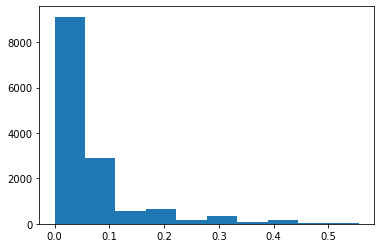

0.0


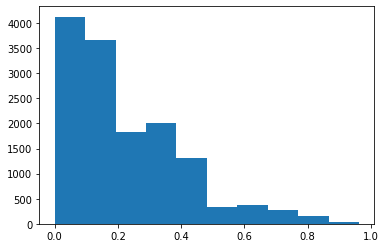

0.0


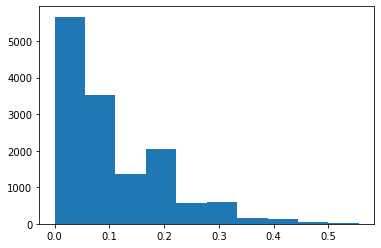

0.0


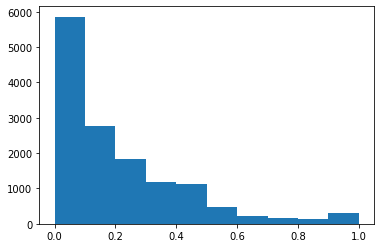

0.0


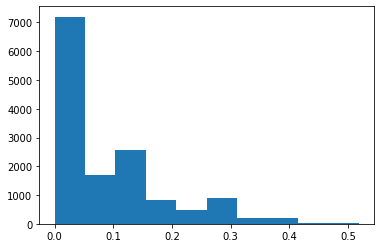

0.0


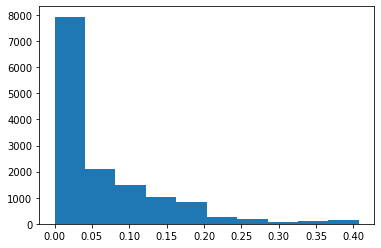

0.0


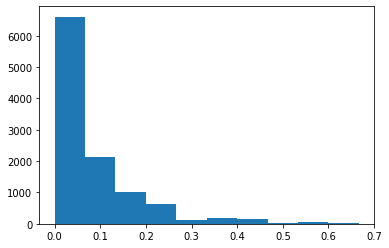

0.0


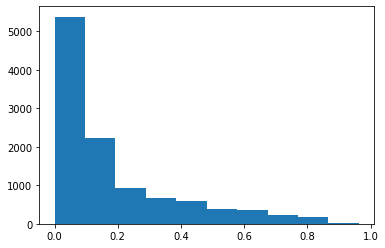

0.0


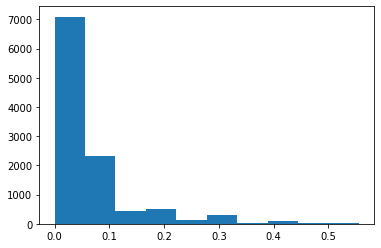

0.0


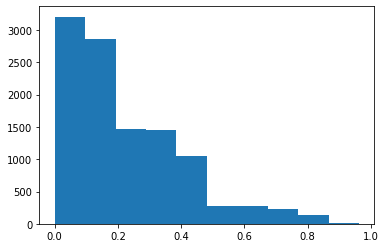

0.0


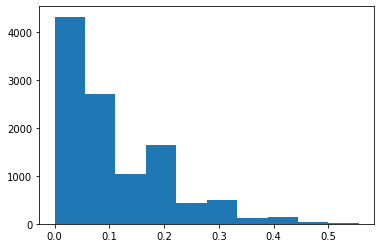

0.0


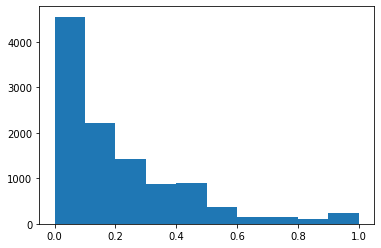

0.0


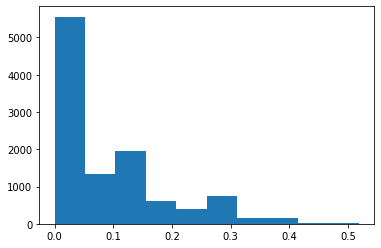

0.0


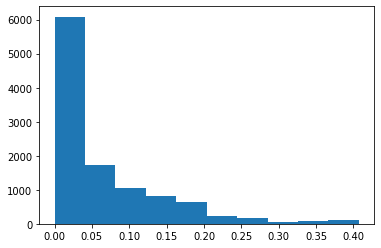

0.0
getting full data of random runs from OLN
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


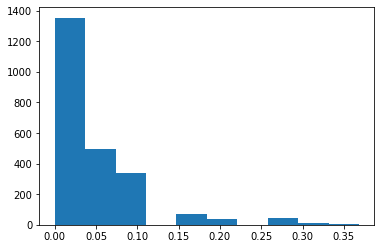

3.378545967204443e-202


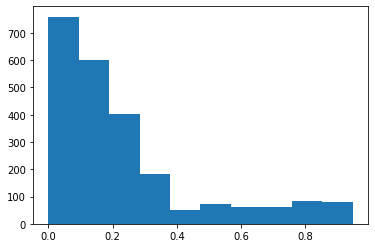

1.6599268610395884e-119


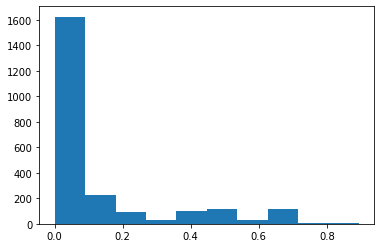

2.5939722097922145e-146


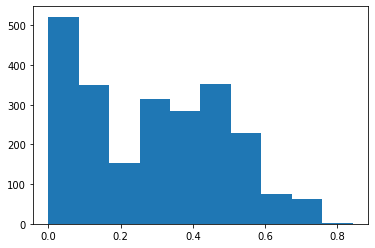

1.8910346778821738e-91


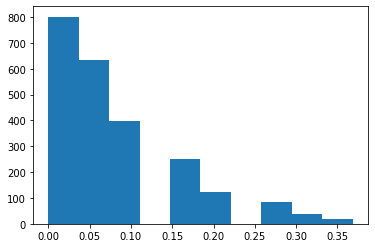

9.239206973932025e-90


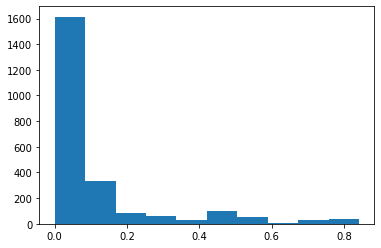

9.306303823619488e-235


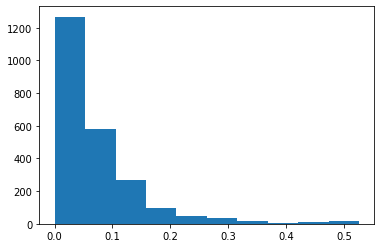

2.4656612781158217e-304


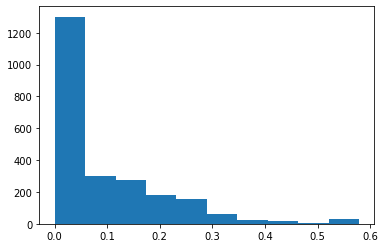

8.887796523829082e-135


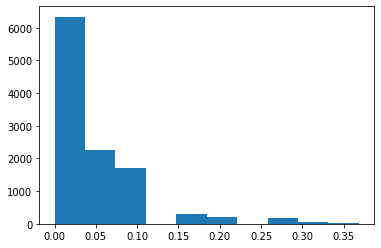

0.0


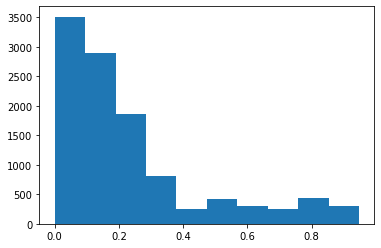

0.0


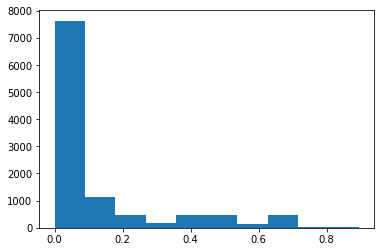

0.0


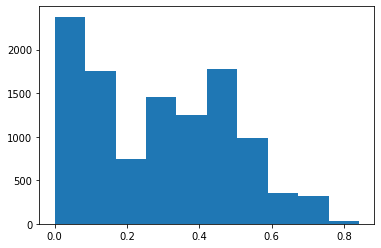

0.0


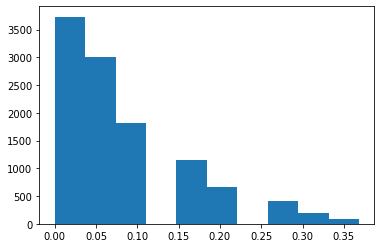

0.0


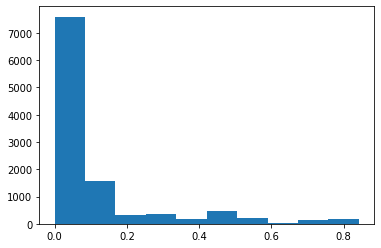

0.0


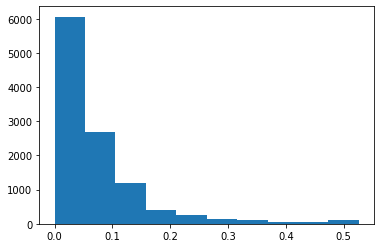

0.0


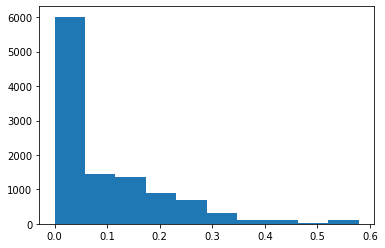

0.0


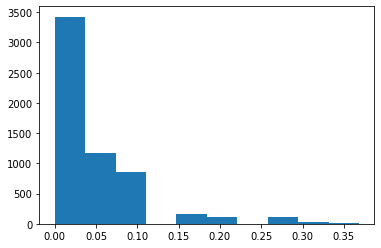

0.0


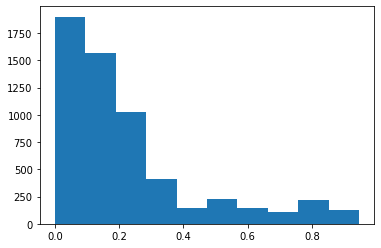

0.0


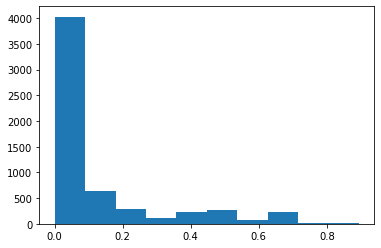

0.0


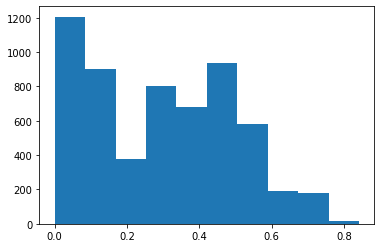

1.0355656481981518e-208


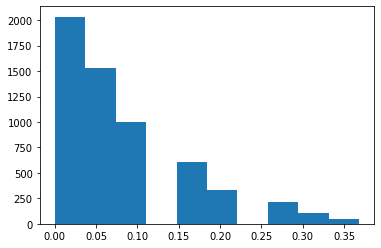

3.108625561654539e-214


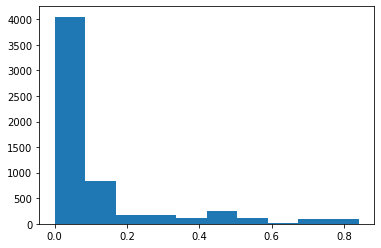

0.0


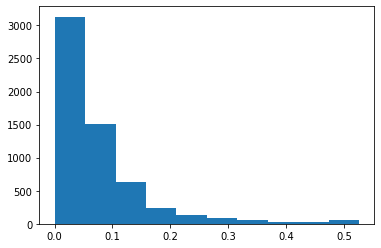

0.0


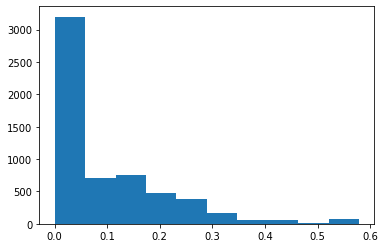

9.14942755364276e-310


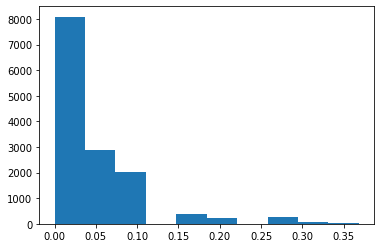

0.0


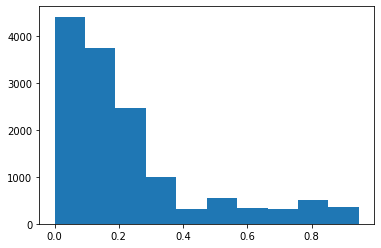

0.0


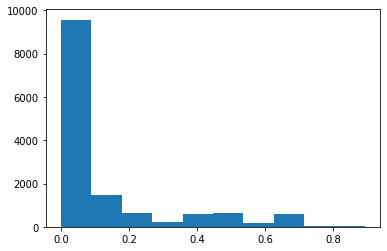

0.0


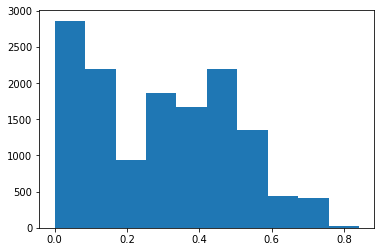

0.0


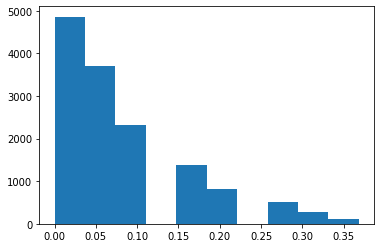

0.0


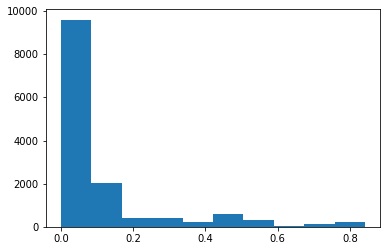

0.0


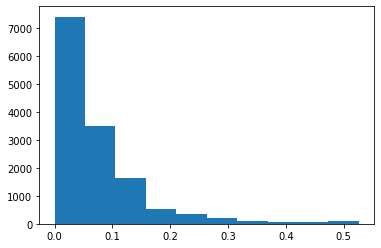

0.0


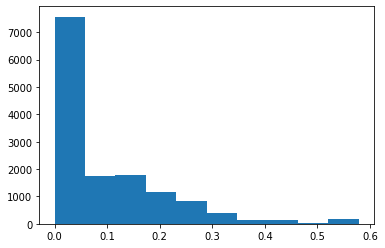

0.0


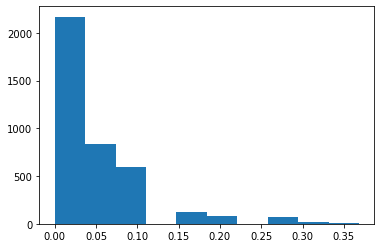

0.0


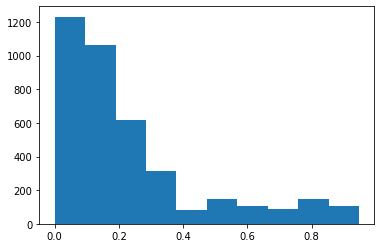

3.524806544175244e-198


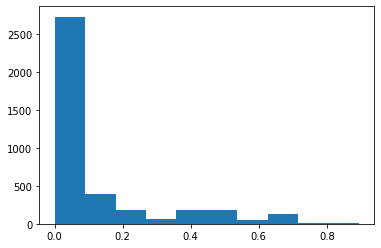

6.784279889265061e-272


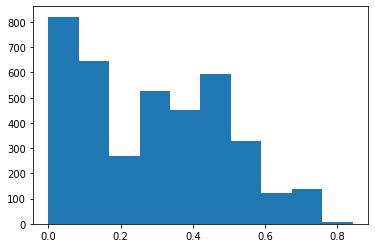

2.527101867349675e-112


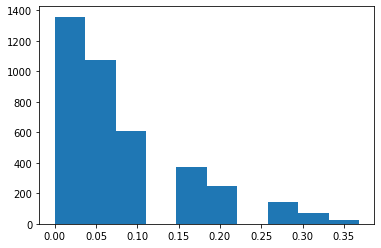

1.295836684764764e-141


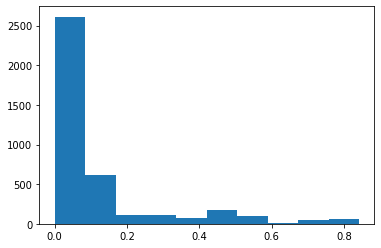

0.0


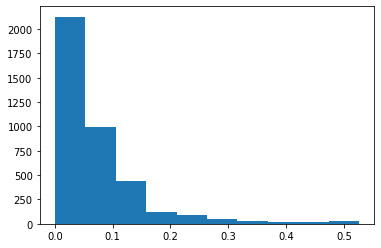

0.0


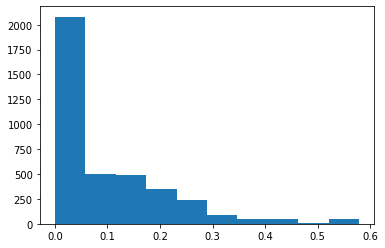

2.6637713027479463e-208


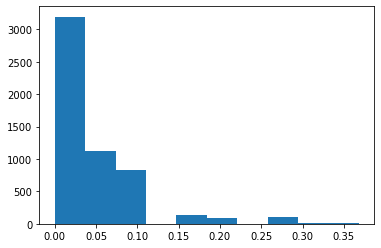

0.0


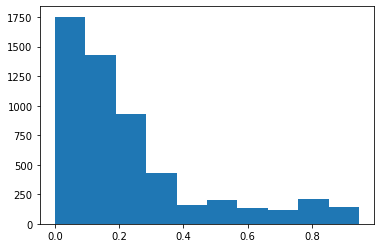

8.025593138782738e-281


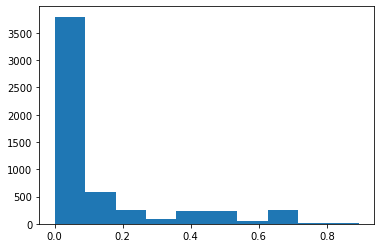

0.0


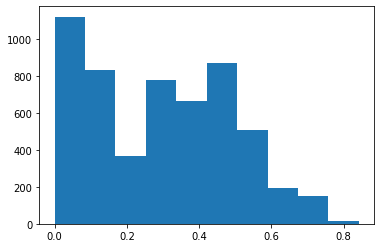

2.972255520635109e-170


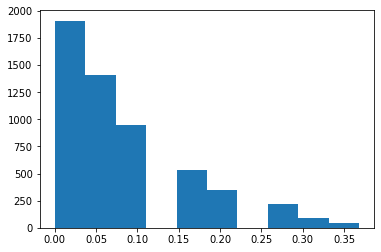

5.304821592899308e-190


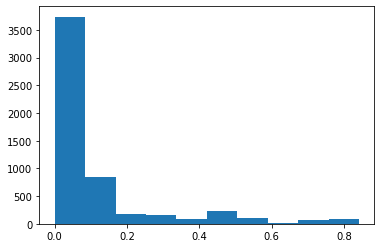

0.0


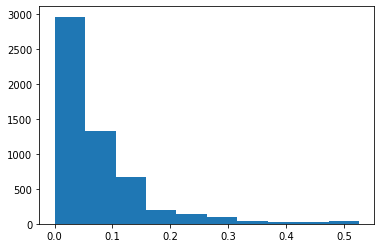

0.0


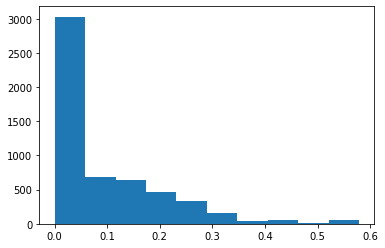

2.1645161006579544e-288


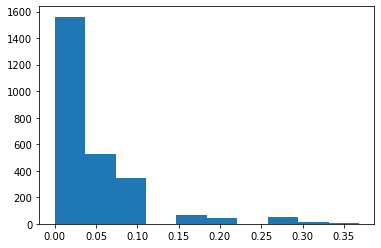

3.0896763607049987e-237


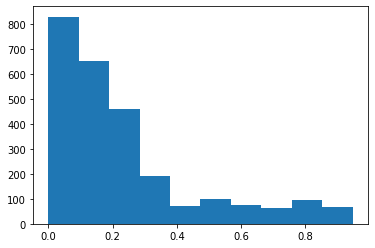

9.68037336875437e-129


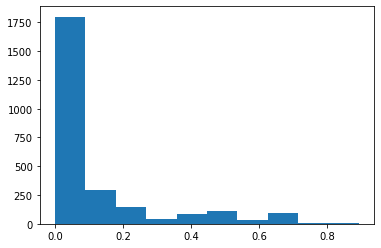

1.6345019849209088e-194


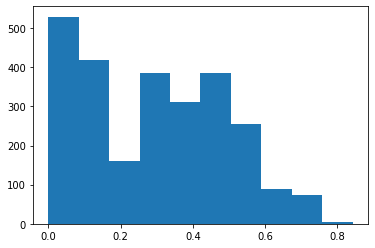

8.037229522680084e-92


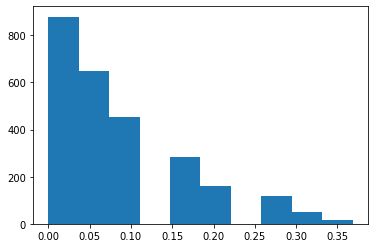

1.9050007929538027e-78


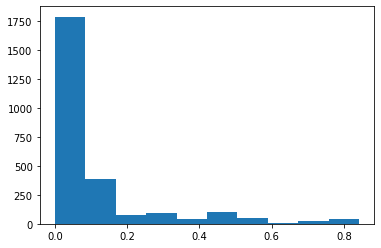

4.701895775197299e-264


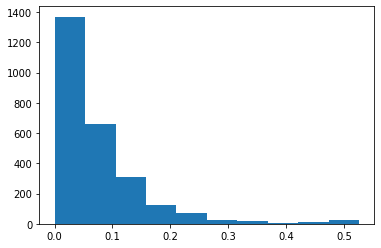

0.0


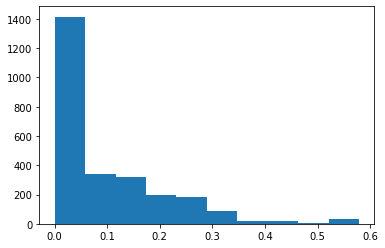

1.1438545107125216e-127


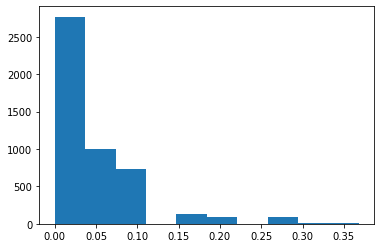

0.0


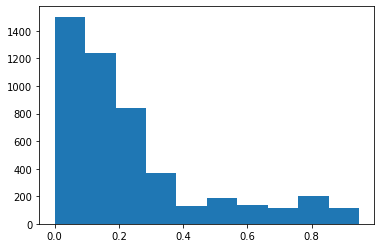

9.313549218564473e-229


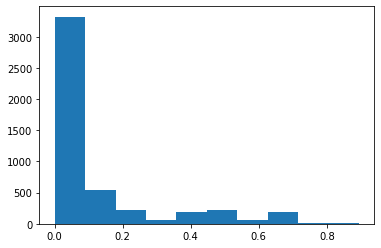

0.0


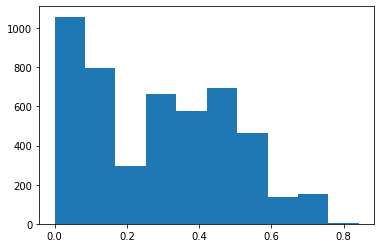

6.8563549444344146e-186


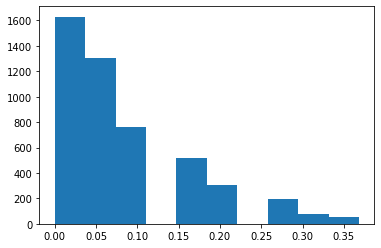

1.1280598365723822e-170


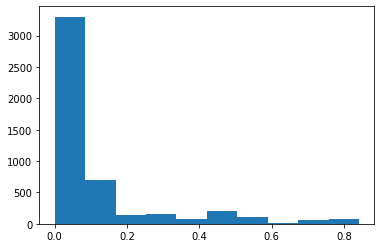

0.0


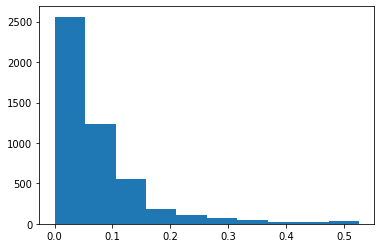

0.0


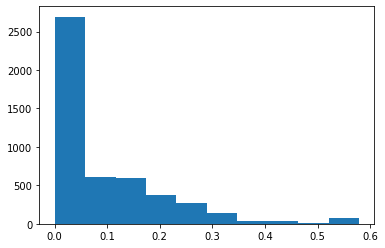

2.5501880200845732e-300
getting full data of random runs from TS
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2500']


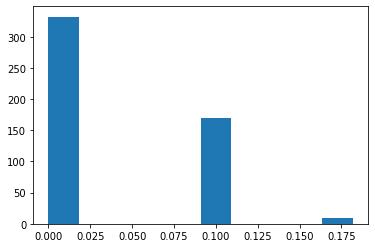

1.3212581362267079e-13


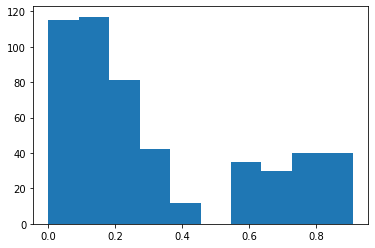

1.4593967213569182e-21


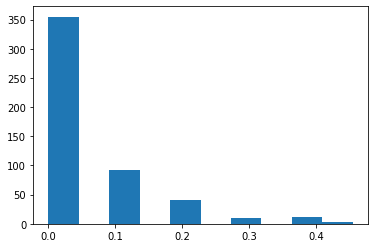

7.868052161811144e-55


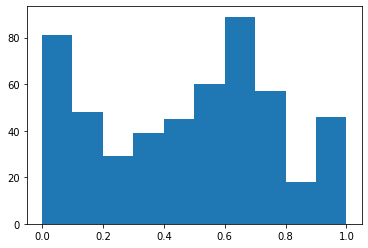

7.919821642507868e-17


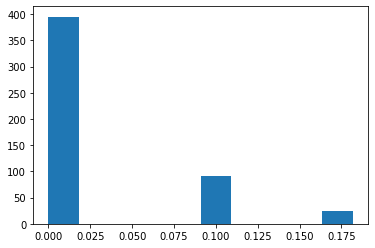

2.3805422533487964e-39


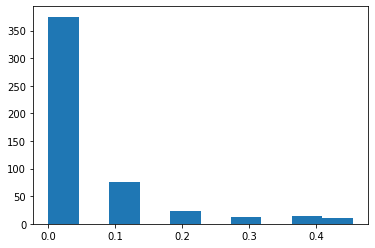

1.8419895425804532e-60


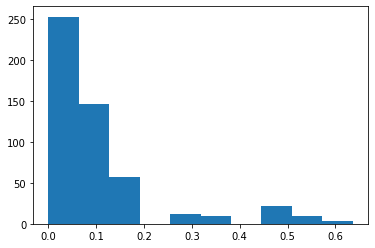

1.4677461201591479e-44


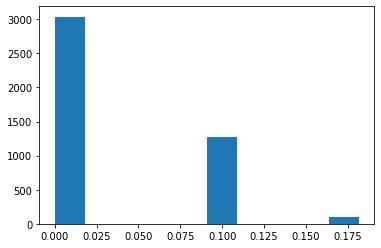

6.011470344369917e-149


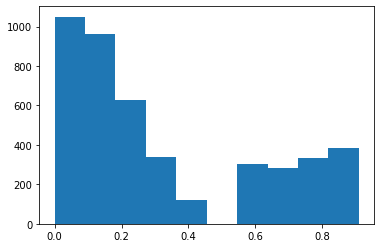

2.300688746097204e-249


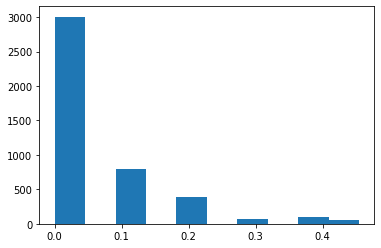

0.0


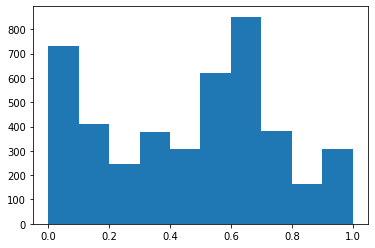

1.5722762310234224e-129


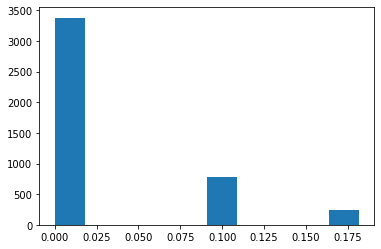

3.2339990563835144e-308


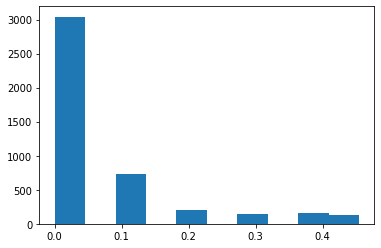

0.0


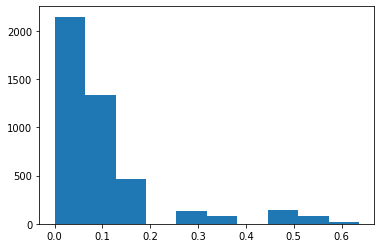

0.0


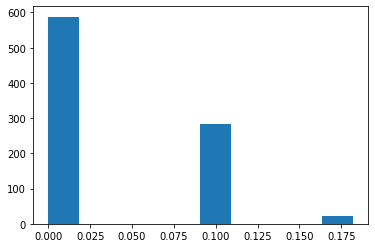

3.8522013154004605e-26


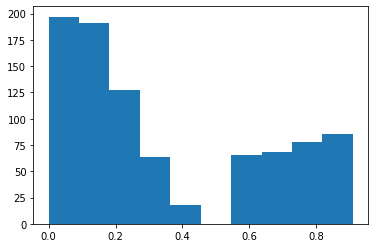

2.6810372691697017e-143


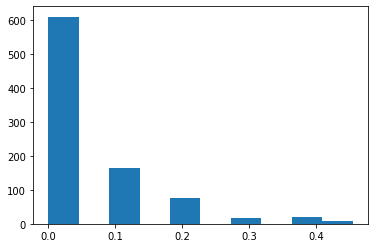

2.7460068776161984e-91


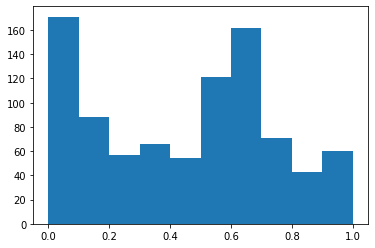

6.993639026645752e-43


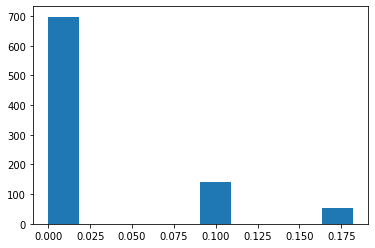

1.5870958026199458e-69


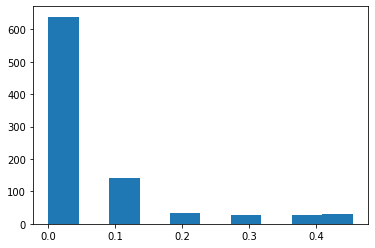

5.239710648838228e-93


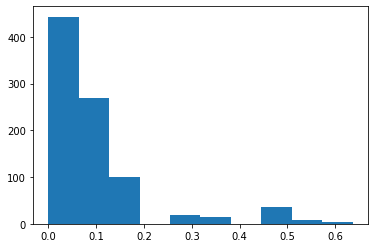

1.1056621128310557e-80


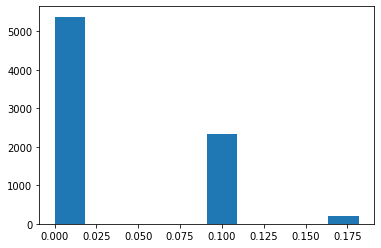

2.8965003439928885e-264


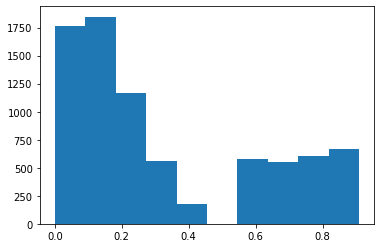

0.0


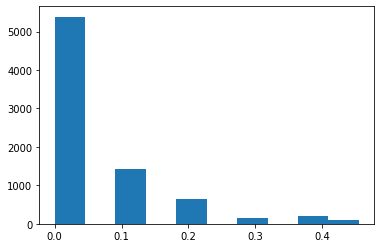

0.0


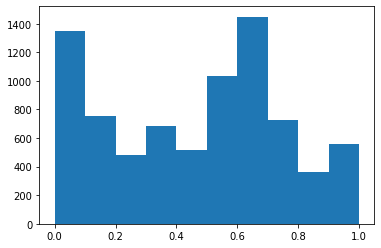

0.0


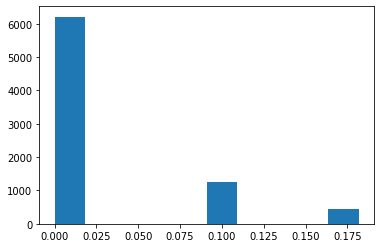

0.0


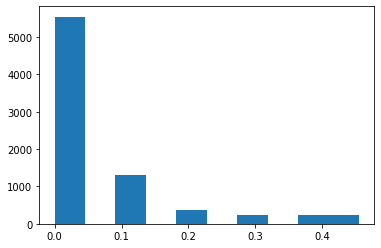

0.0


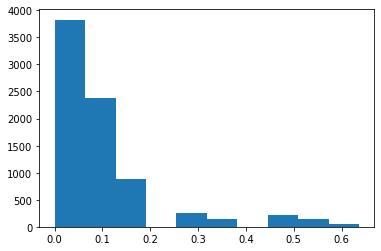

0.0


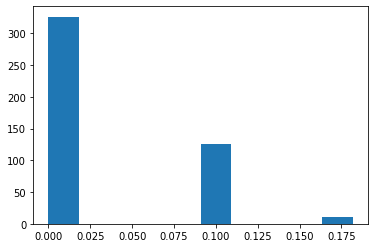

2.209855977528819e-19


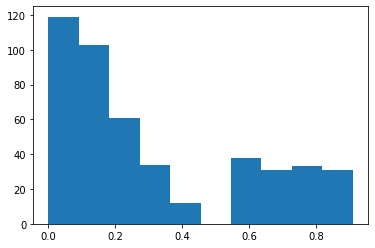

6.946657336340042e-21


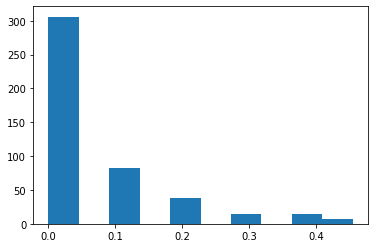

1.581056384564501e-43


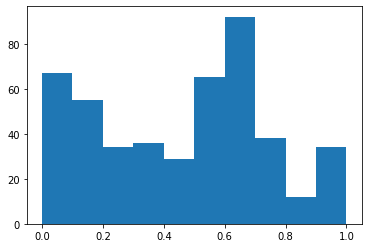

3.857012232996203e-13


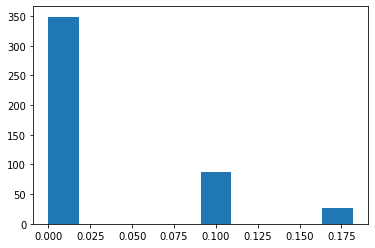

1.5266261625881407e-32


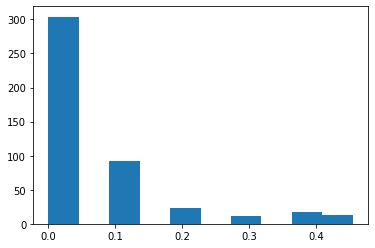

7.674700524683488e-45


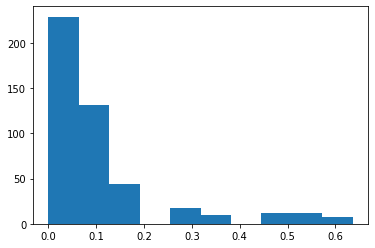

3.335094096419632e-42


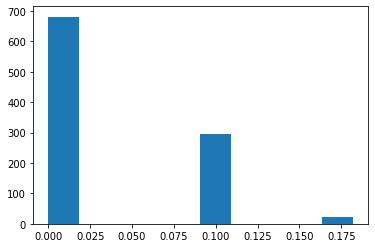

1.3582771538650428e-32


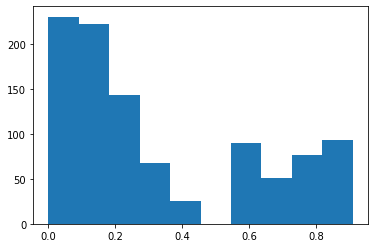

2.4150690085548216e-71


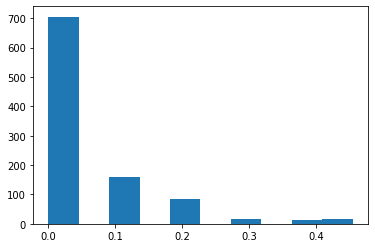

2.6901448438909197e-112


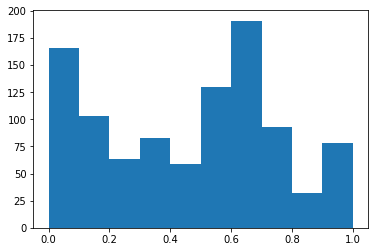

6.26379509571088e-38


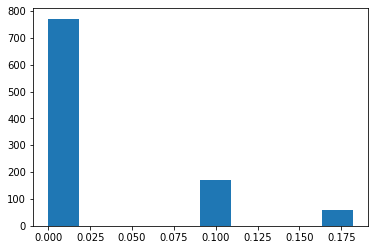

9.84717248268982e-74


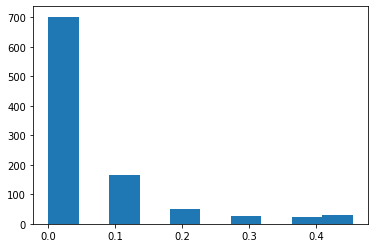

5.257361693284594e-105


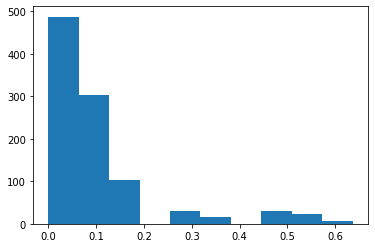

7.503614004210135e-91


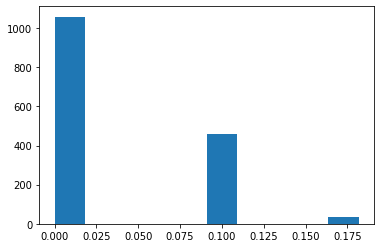

1.7223013804203904e-50


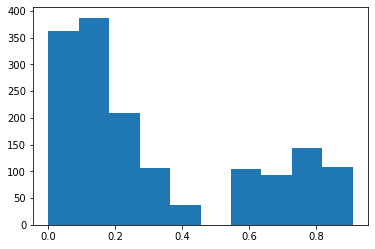

8.925500540185606e-84


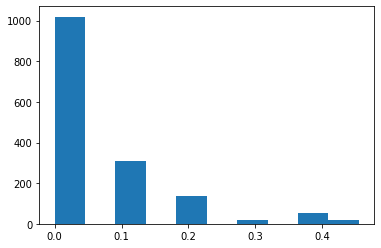

8.09746692240911e-148


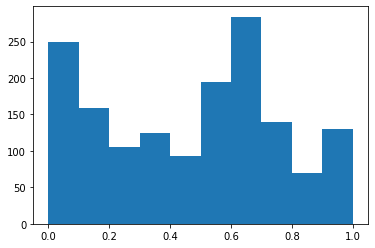

1.970805027441783e-68


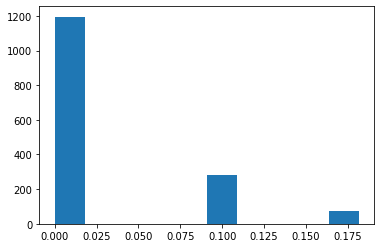

2.3988009466979936e-112


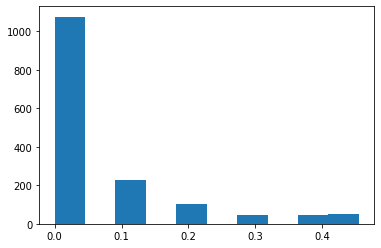

1.082970072438649e-141


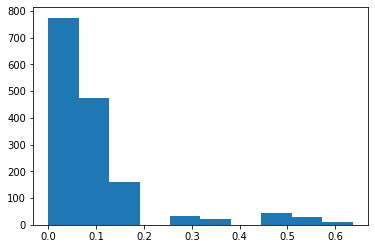

3.5810464226658744e-152
getting full data of random runs from Tectum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


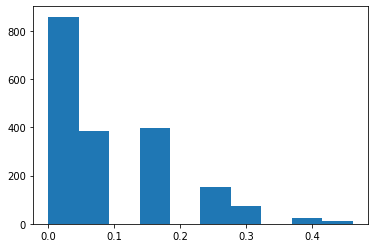

2.2064828074542843e-68


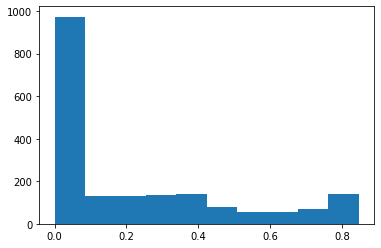

4.486836639703023e-50


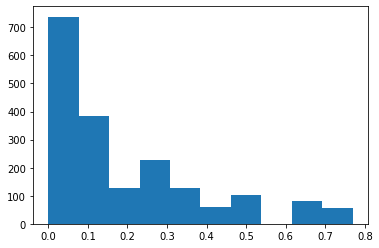

8.7237403551076e-81


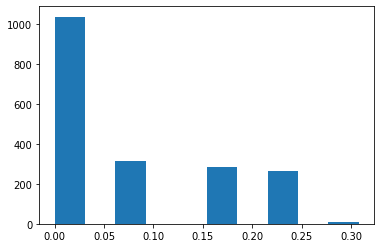

2.3647981836776183e-63


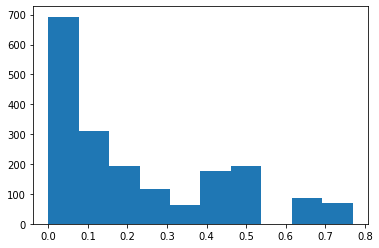

3.358020384867935e-48


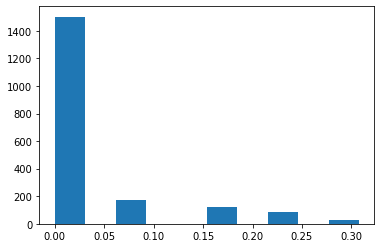

2.094456778770164e-189


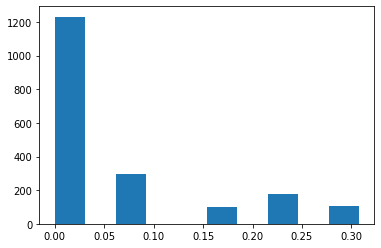

3.407250478305165e-94


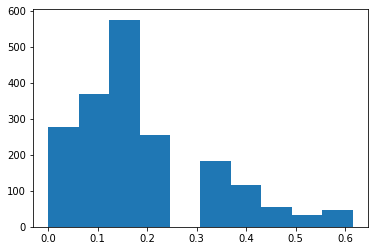

7.255689875247359e-58


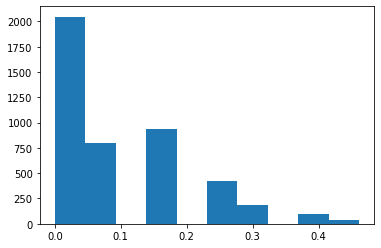

5.678381964993359e-144


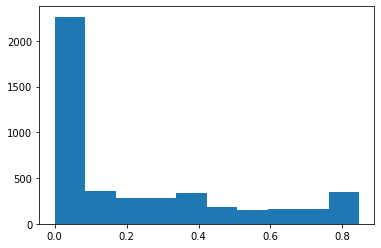

7.590999971285004e-118


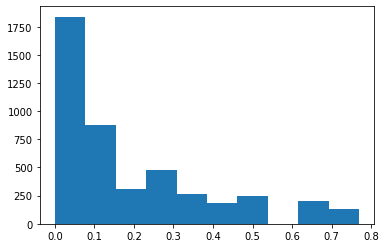

1.7120816104870332e-186


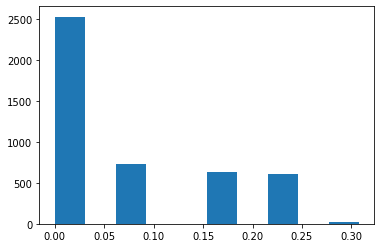

1.4853620657564426e-136


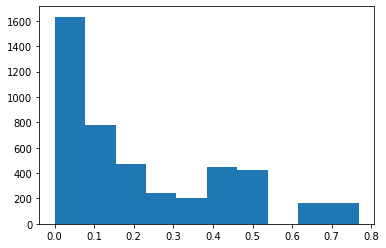

1.6131457671181999e-114


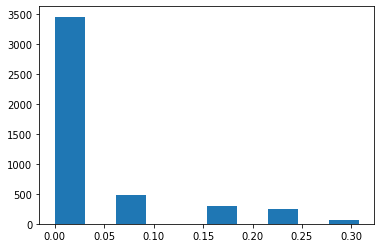

0.0


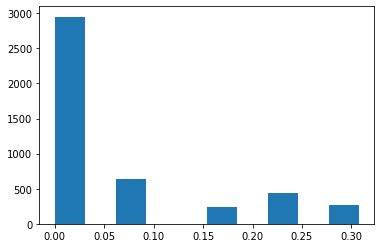

1.5506217718613369e-211


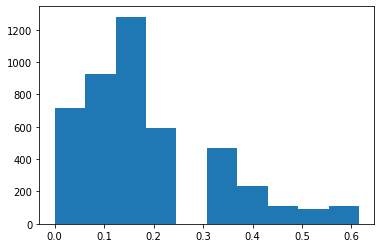

6.922056934403503e-141


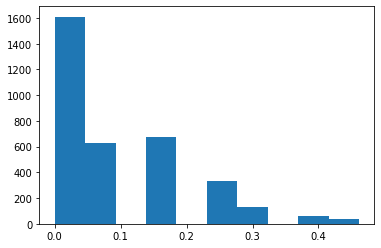

2.923308472459604e-123


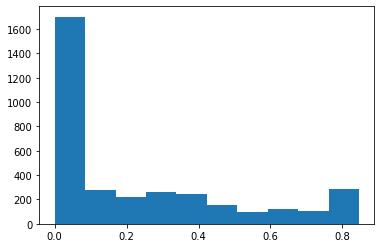

5.029701341603592e-88


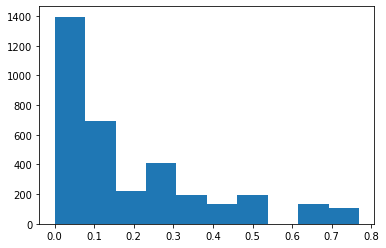

2.8141993212355003e-147


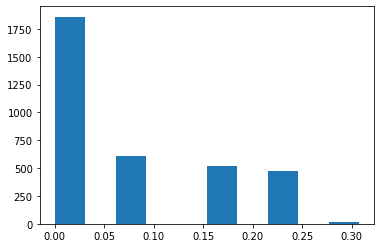

9.393132884981199e-113


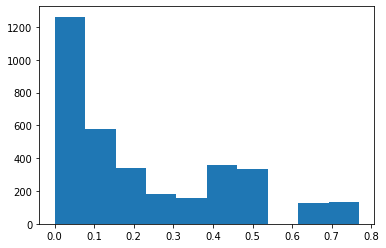

1.7868484858910657e-86


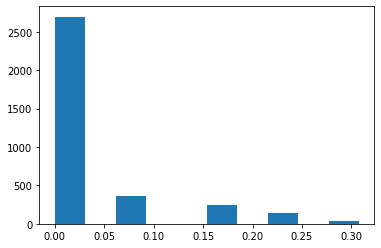

0.0


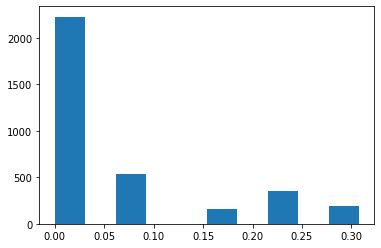

2.1444078394766084e-161


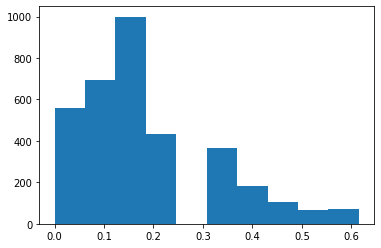

2.9810472284004526e-100


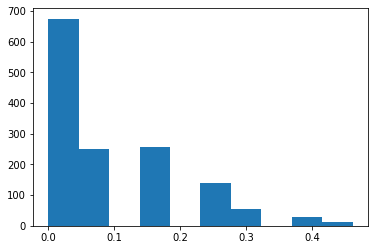

9.763353669541292e-51


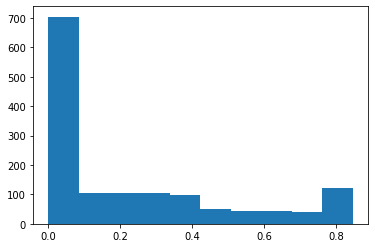

2.177067524669458e-37


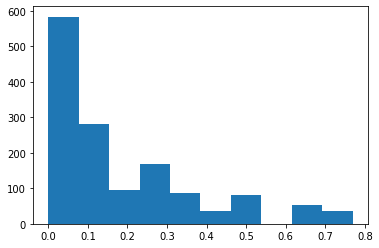

5.838657449045981e-66


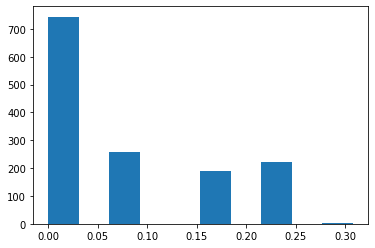

1.6549238325740098e-56


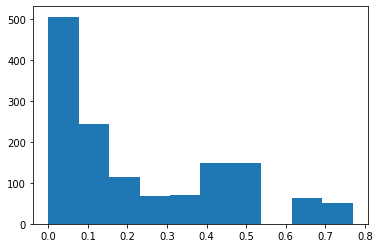

2.4065569262288377e-34


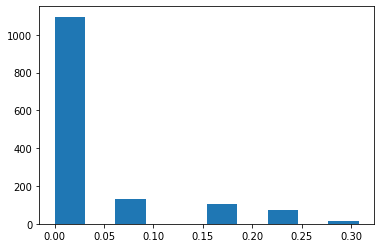

7.609976175527403e-125


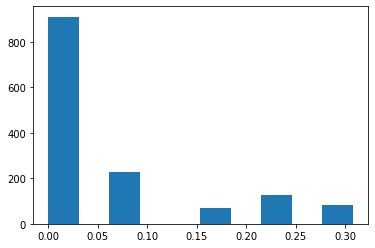

5.805850230399075e-71


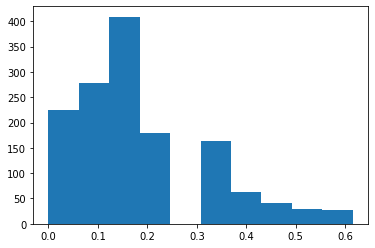

8.660752633901842e-42


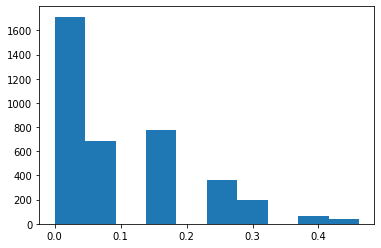

4.121970818182057e-118


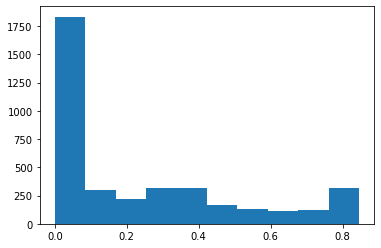

2.154347479706696e-95


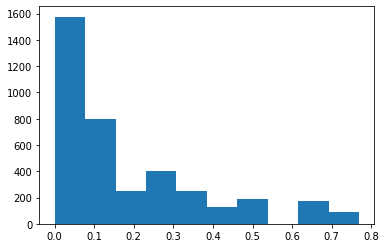

1.2940010639645319e-173


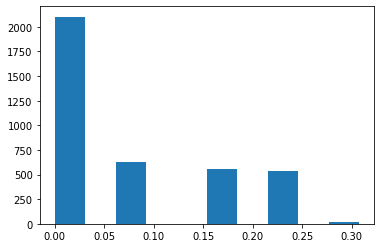

7.873013715883406e-126


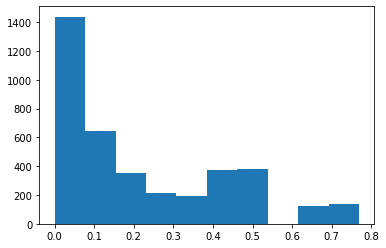

6.541491609302026e-98


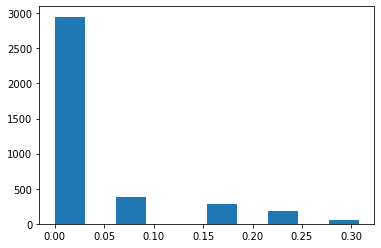

0.0


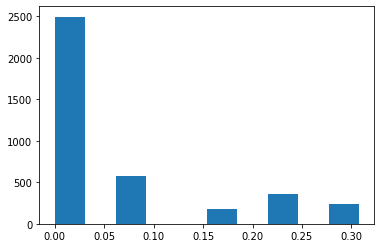

1.4030793851718217e-185


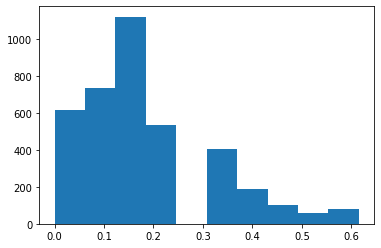

5.524095720070171e-115


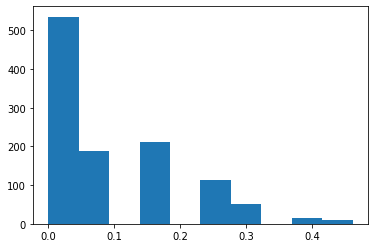

1.2301054757146147e-37


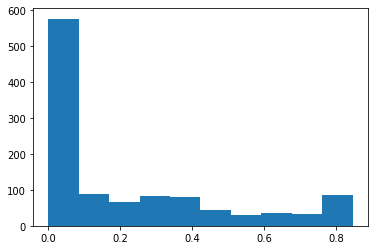

7.825174779151497e-31


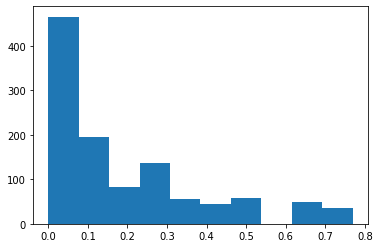

5.537009761373412e-47


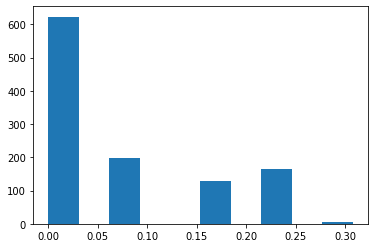

5.22690412085876e-35


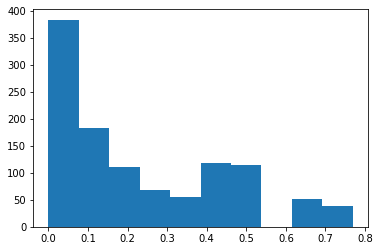

1.3171536349951402e-26


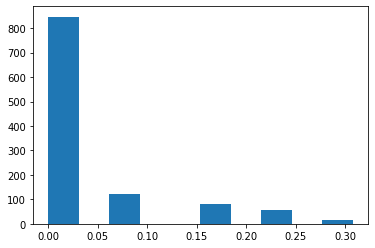

3.038332327823329e-97


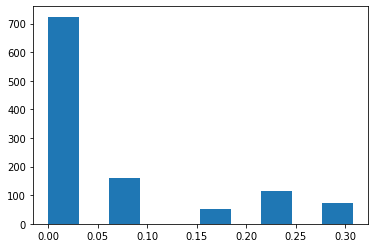

1.1732159674804357e-50


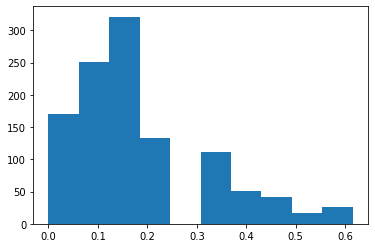

1.6577267611372414e-37


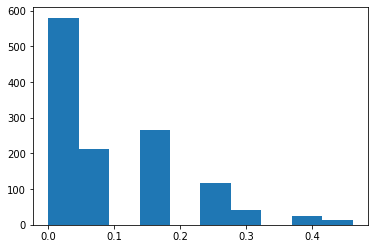

1.1735720794715322e-45


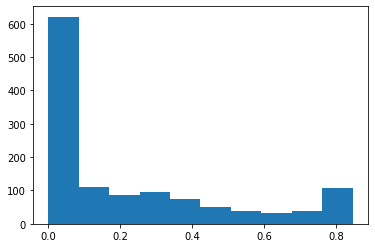

8.194208891506833e-34


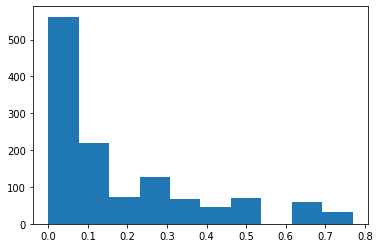

2.4635666919591802e-54


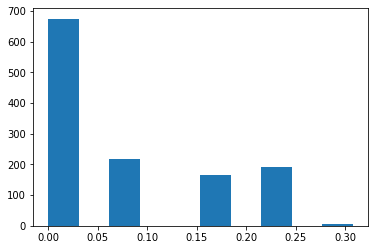

4.9979376318408264e-45


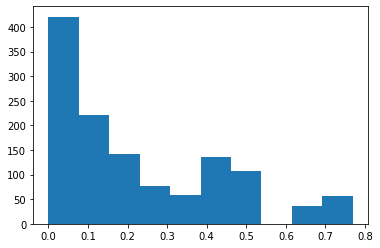

3.5595572850085177e-33


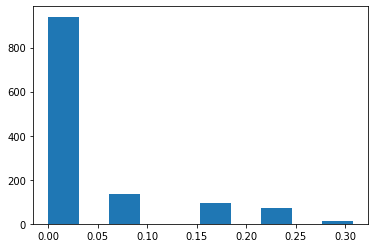

3.981445793662056e-99


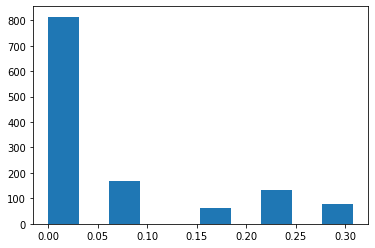

1.3428313151425393e-55


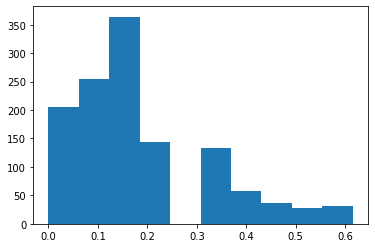

6.081548470633922e-41


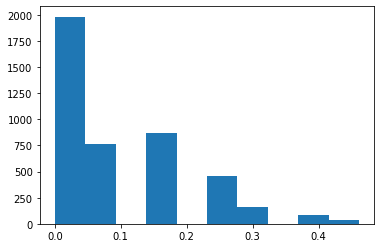

8.274976876477948e-141


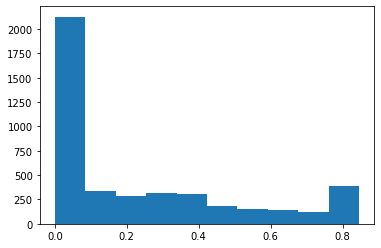

4.559184766516408e-112


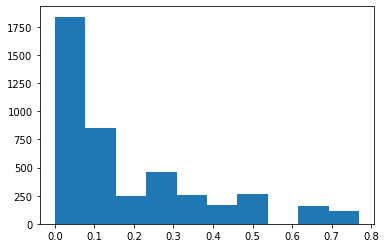

2.8543855046433224e-189


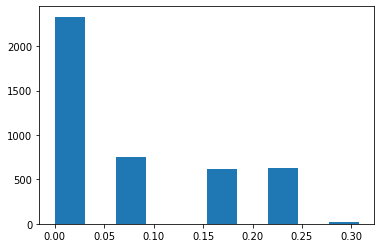

2.1131708446341444e-151


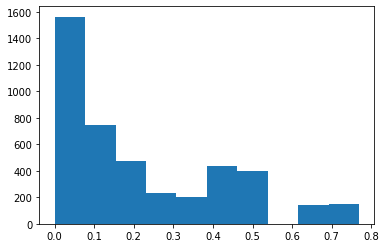

2.6083102830372413e-114


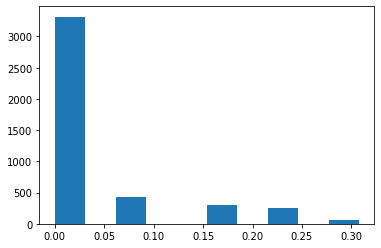

0.0


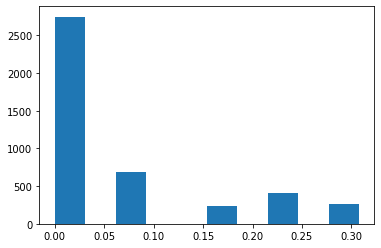

2.960995329729989e-194


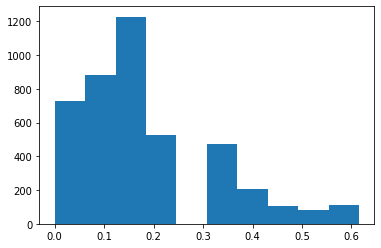

4.529313703037872e-138
getting full data of random runs from Tegmentum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


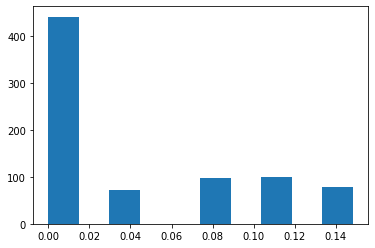

3.87559184032592e-31


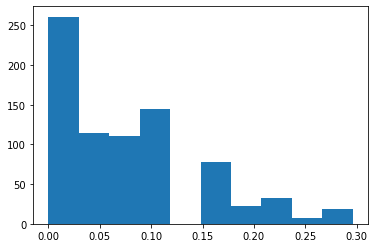

4.275022613829302e-21


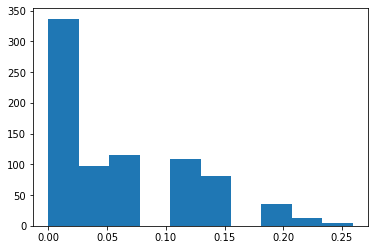

1.3618467619404294e-16


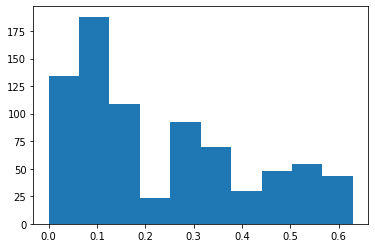

1.2898315818902956e-21


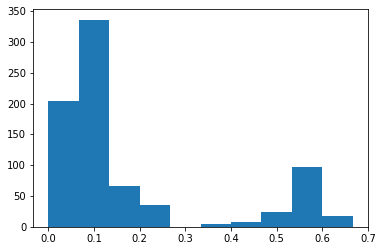

6.044260982528845e-36


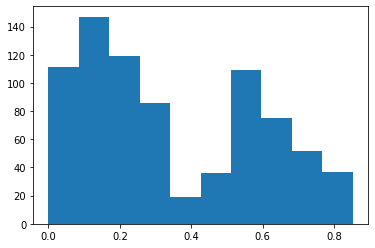

2.658244657424499e-286


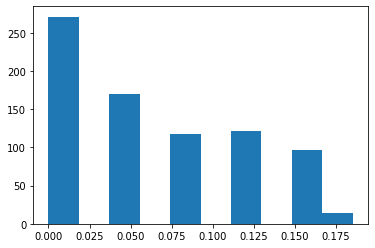

1.4666806080061646e-42


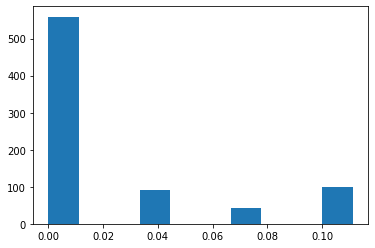

5.831975994289254e-40


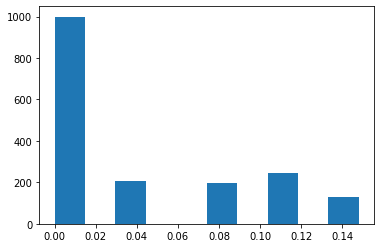

6.319146213583011e-56


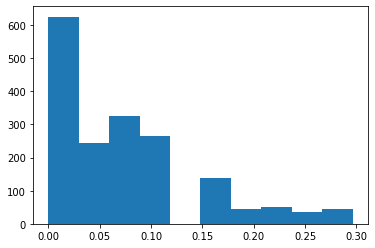

2.6119208334392447e-63


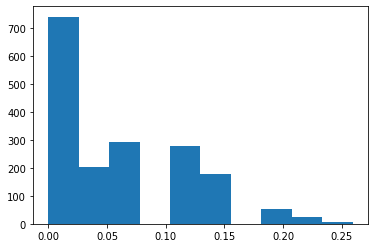

2.431682968199648e-33


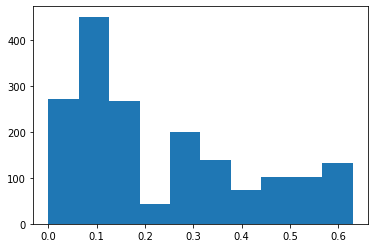

2.5462963867156928e-49


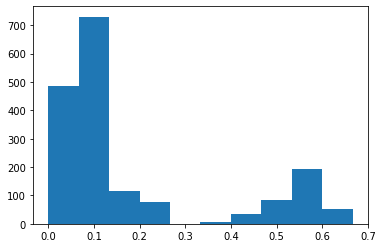

1.0254474870920203e-69


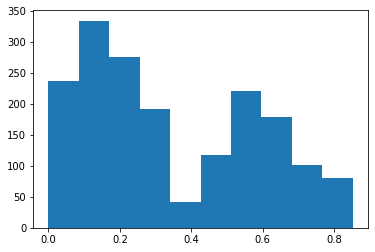

0.0


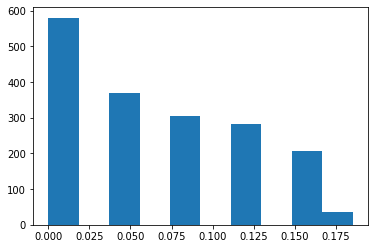

3.855007436315349e-88


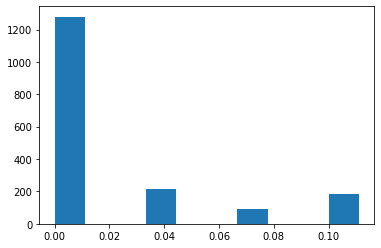

7.302959085568705e-104


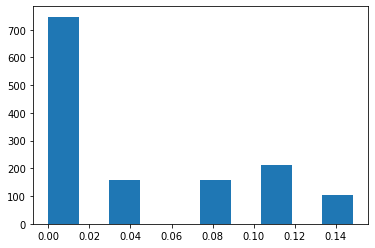

2.0233514821696508e-55


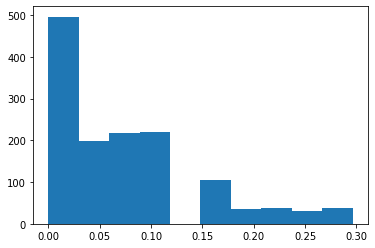

7.997557339274803e-49


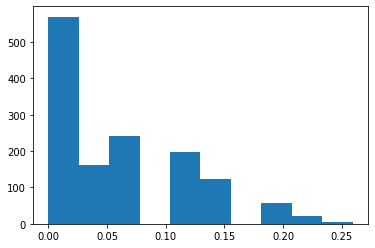

2.991078088733028e-26


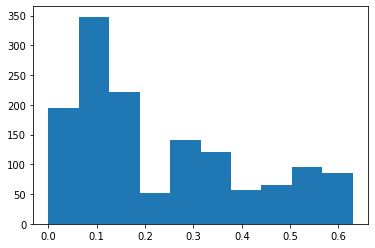

3.789049833870498e-35


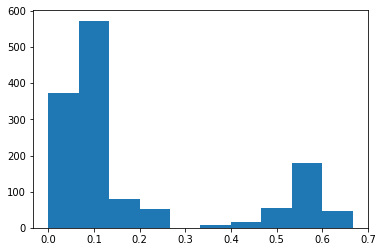

5.338940147194309e-51


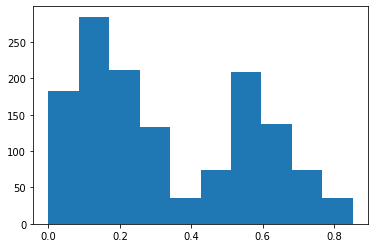

0.0


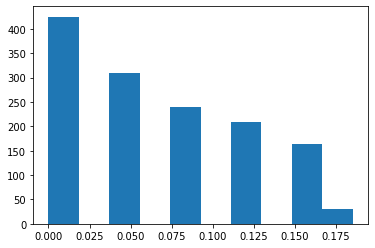

3.2382162158137364e-56


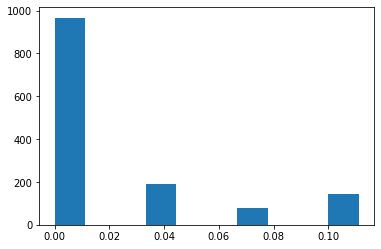

5.141520671061312e-77


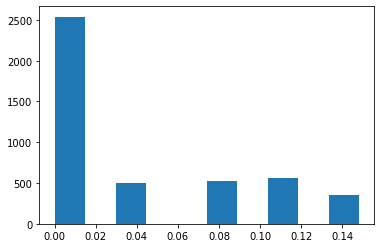

1.979840501205122e-136


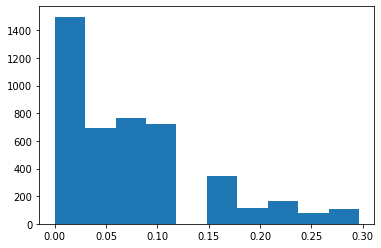

2.7388941491280704e-145


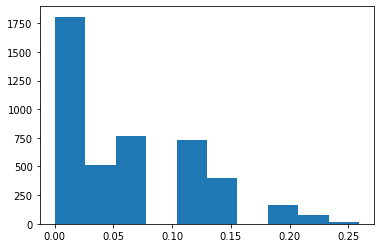

4.054750197513715e-78


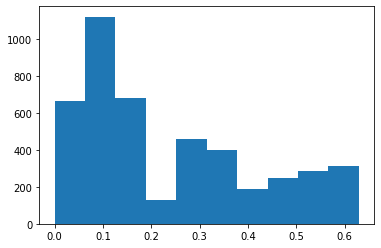

2.7348656281312536e-132


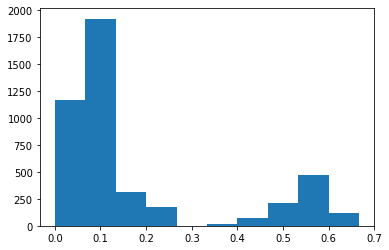

1.2197522064398031e-182


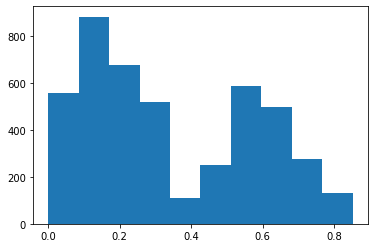

0.0


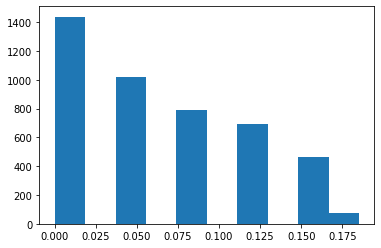

4.02679572493374e-158


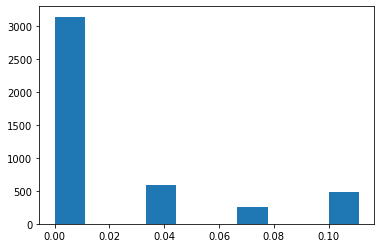

6.759466264221197e-236


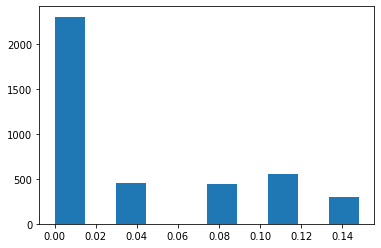

9.072806706236399e-127


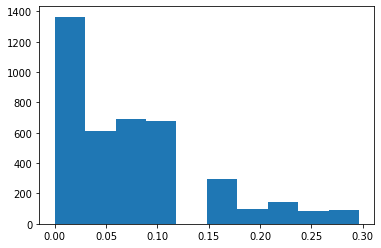

1.1151125783030483e-133


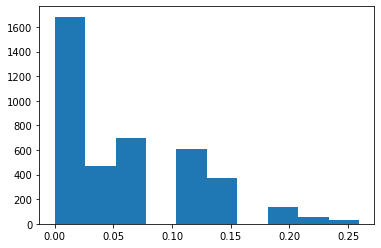

1.9667828066078724e-74


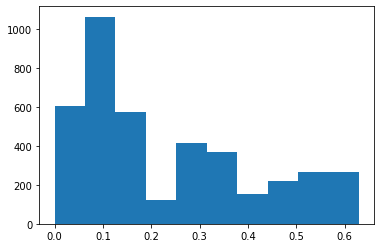

8.232777698327346e-114


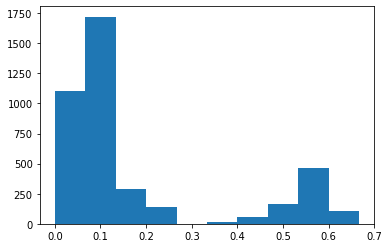

2.952159548124782e-170


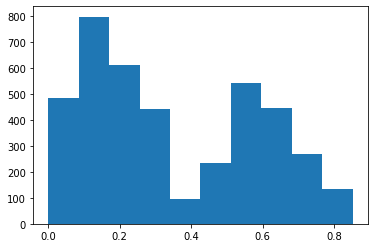

0.0


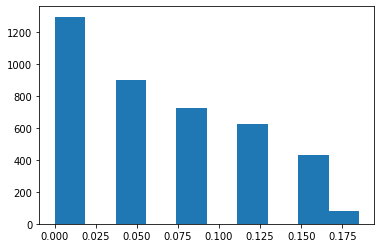

8.809554731073663e-144


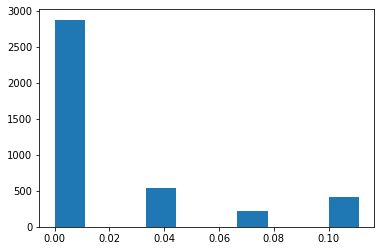

2.5773351759964154e-229


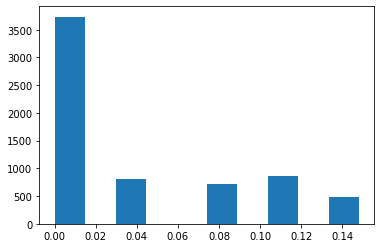

3.9916674307222657e-196


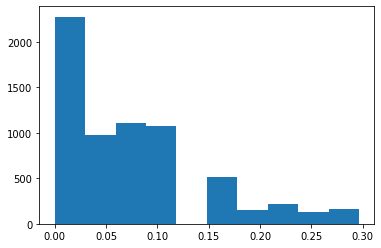

1.564755608291137e-221


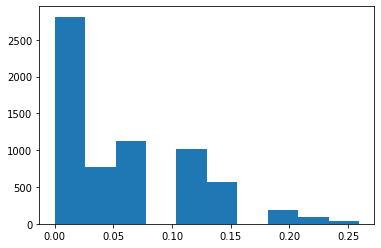

1.876757065631927e-123


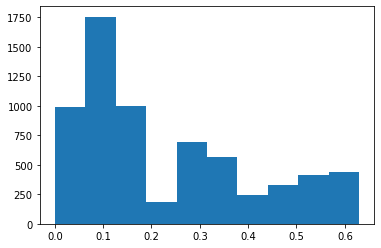

8.419140039731633e-165


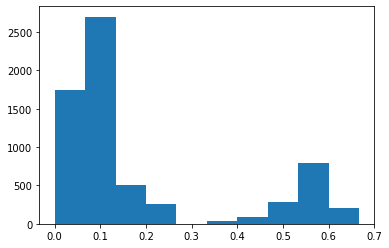

1.030042913662063e-245


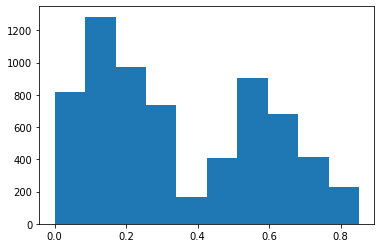

0.0


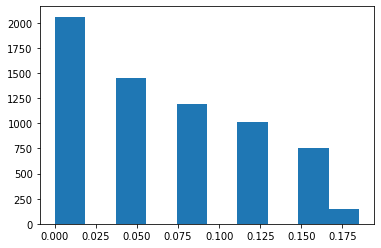

3.840730829191919e-256


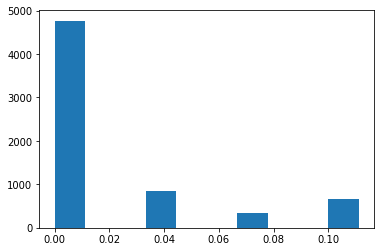

0.0


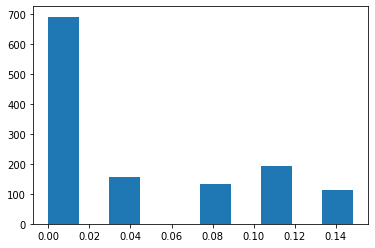

2.5559725294919212e-54


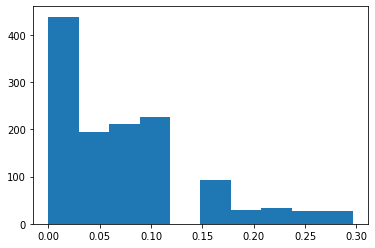

1.3926177995035559e-45


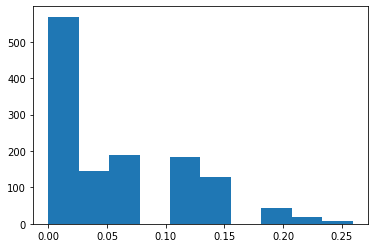

3.088615801224032e-26


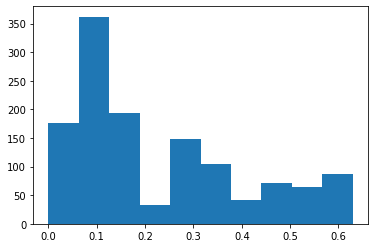

2.7675477874642086e-29


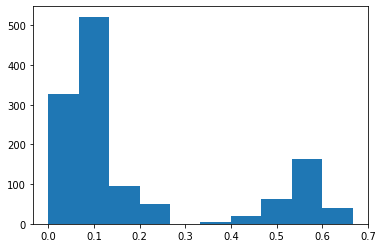

1.86936748792299e-45


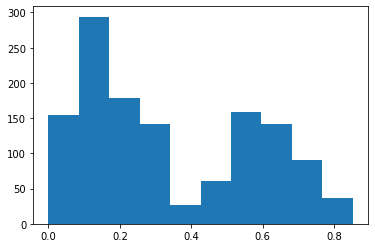

0.0


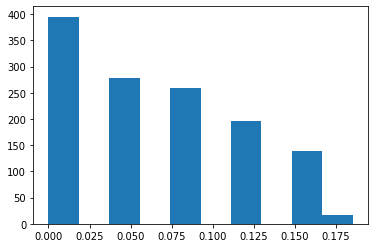

3.419128126036417e-50


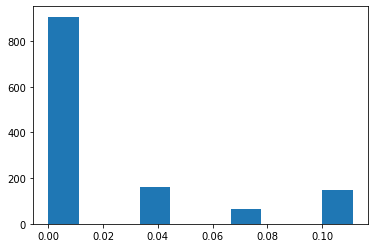

2.7166861657175396e-69


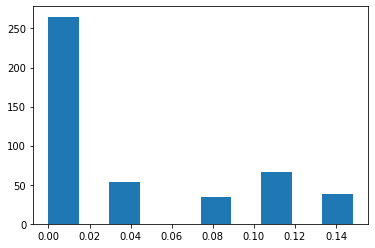

1.1955676595356742e-15


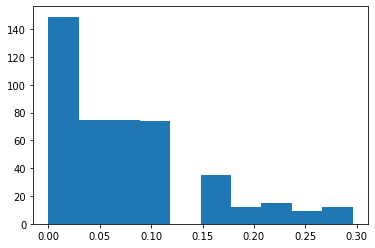

9.539941830313761e-17


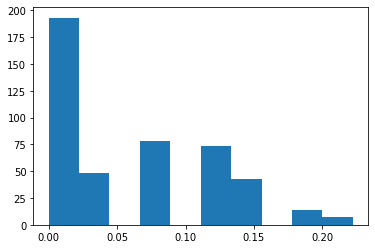

4.567770158925495e-10


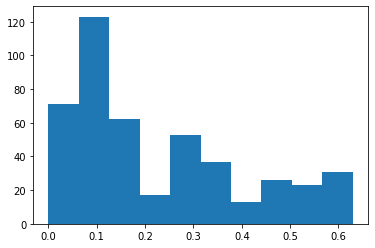

7.145741937633633e-11


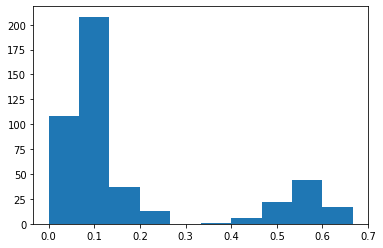

4.06978727650673e-21


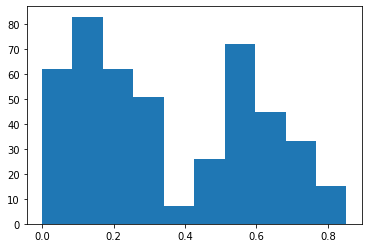

0.0


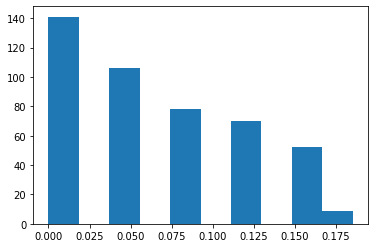

3.9412782743125415e-17


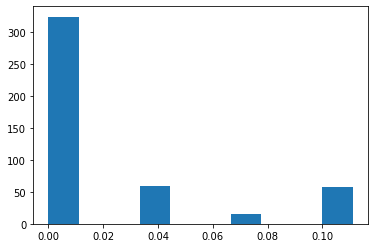

1.3524825088290712e-26
getting full data of random runs from Telencephalon
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


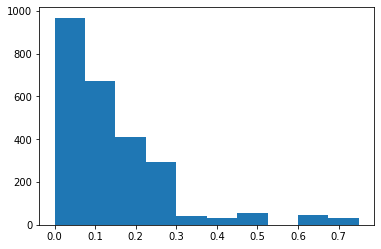

3.437652954691613e-227


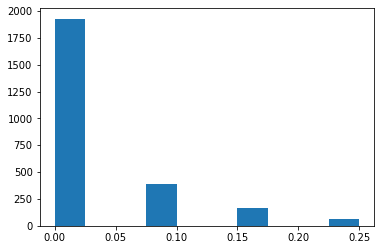

1.5547527534744918e-217


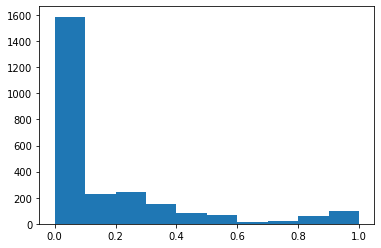

1.9133124716031505e-189


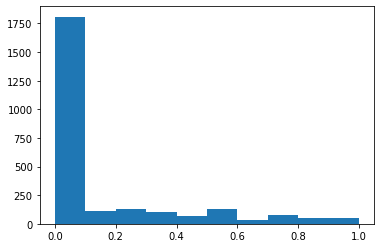

5.793648255768426e-178


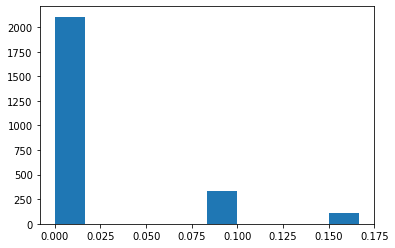

3.75577916112698e-247


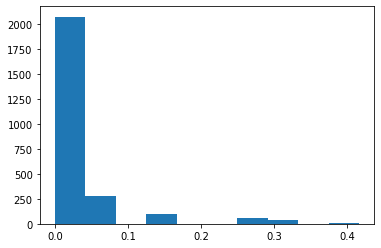

0.0


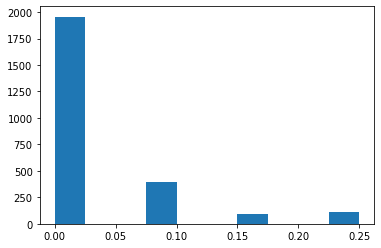

9.482188265293318e-252


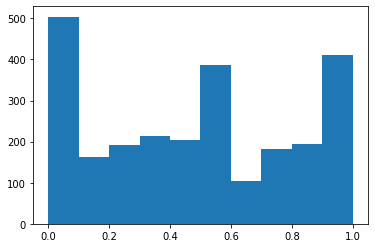

0.0


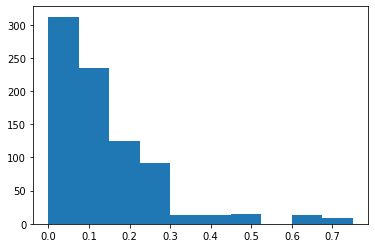

1.2423725437981046e-78


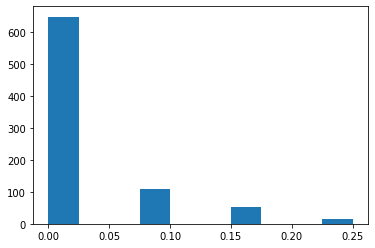

1.6106282515498723e-80


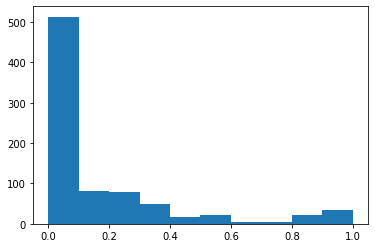

1.8632126785408738e-64


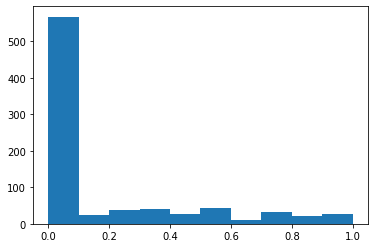

3.932356441847211e-48


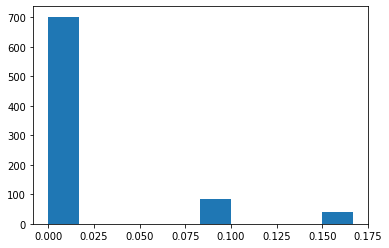

2.0499435987924806e-93


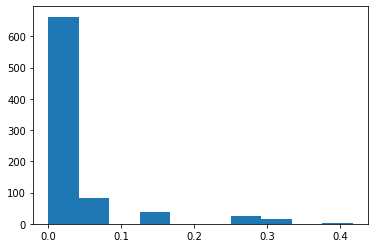

1.2794667914465642e-103


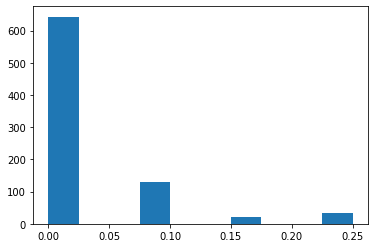

3.778797043180186e-93


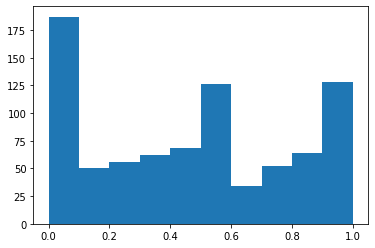

1.4017584146260596e-251


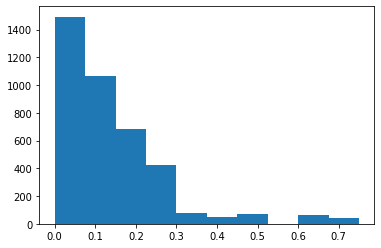

0.0


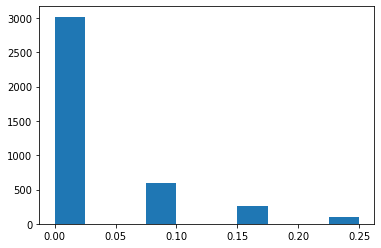

0.0


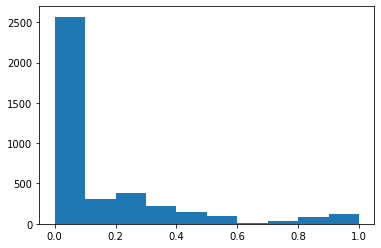

0.0


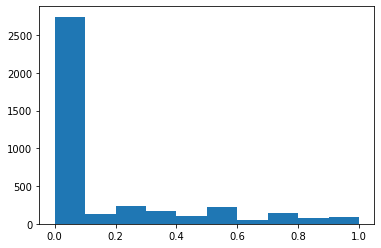

6.568490984729524e-243


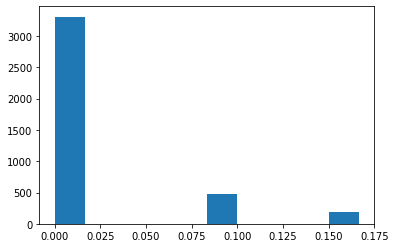

0.0


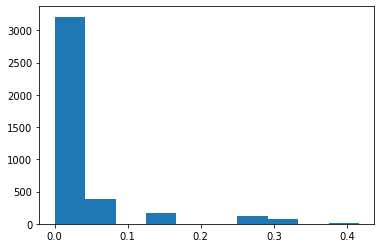

0.0


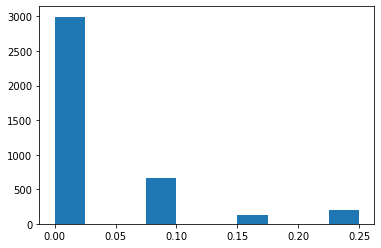

0.0


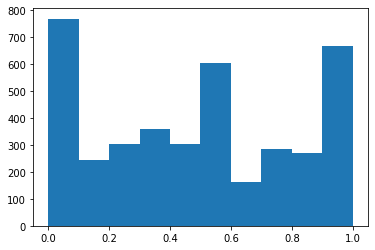

0.0


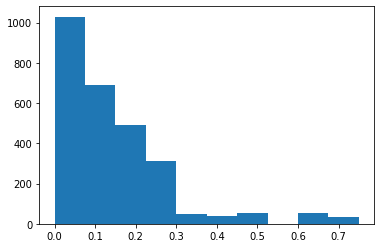

3.8692153589324054e-243


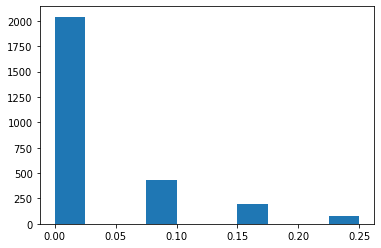

2.0575042759722445e-219


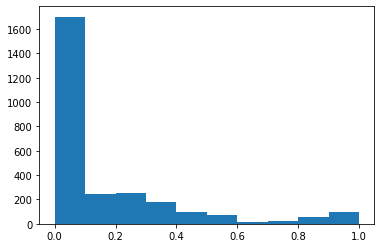

4.710816812357685e-208


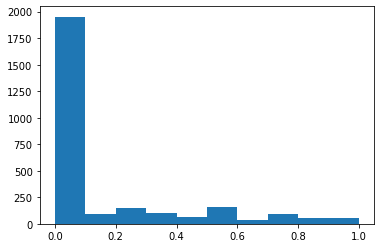

4.804582606286629e-182


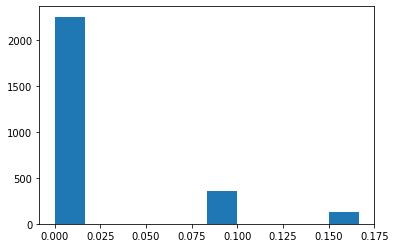

1.3008665774700404e-262


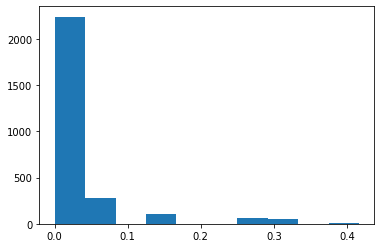

0.0


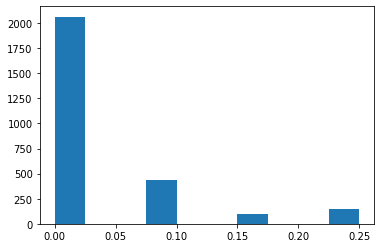

9.30669675335612e-250


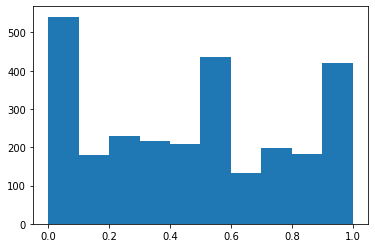

0.0


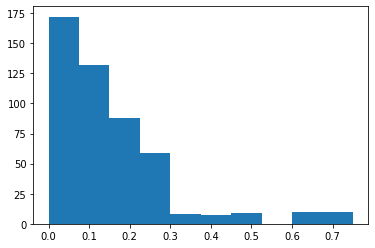

3.1609924835039006e-47


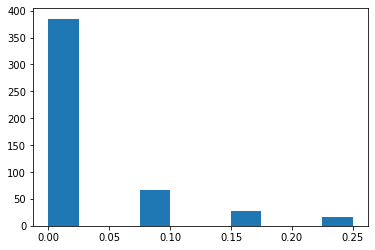

1.223901374526241e-50


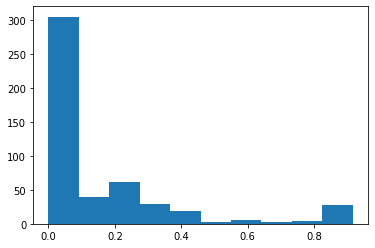

4.155485551708175e-41


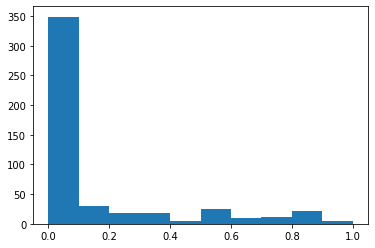

1.2913753776438189e-34


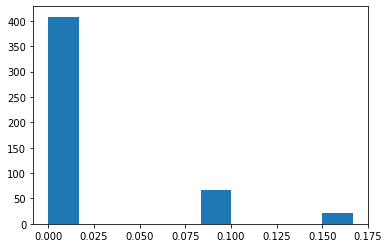

2.2098614860698822e-51


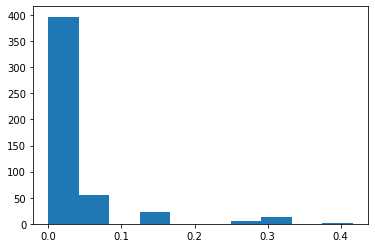

1.5079794257207945e-70


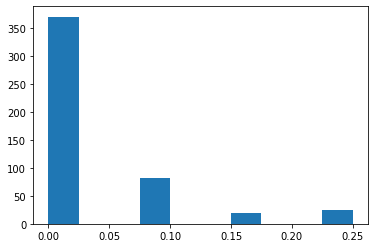

8.25456018929914e-48


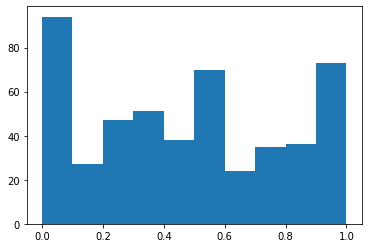

1.1313605572427698e-62


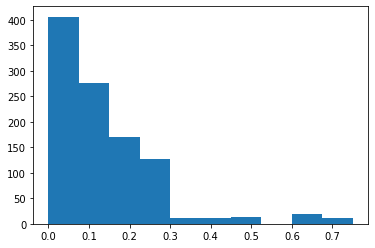

1.0341881802431475e-104


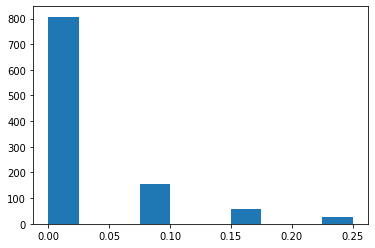

1.577909937749149e-101


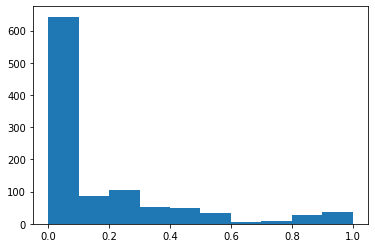

3.561069764393235e-73


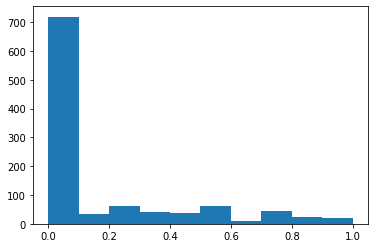

8.909322759342049e-64


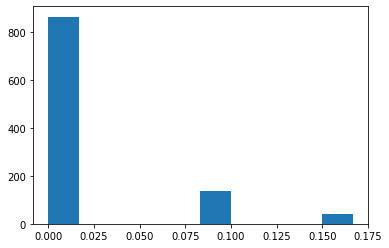

2.8207395389355203e-105


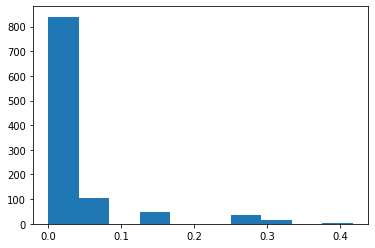

3.139655313639204e-131


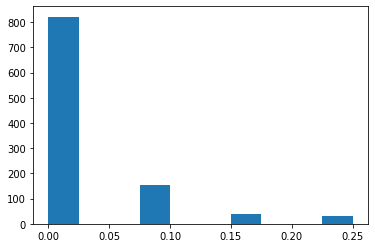

8.065151115969738e-116


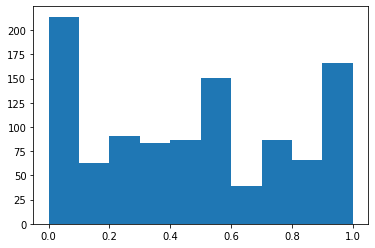

7.268155292027603e-266


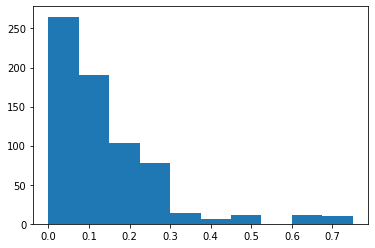

5.136555678685595e-70


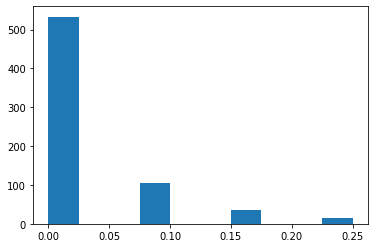

2.374797784842168e-70


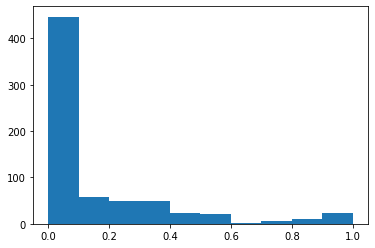

2.817052689709923e-57


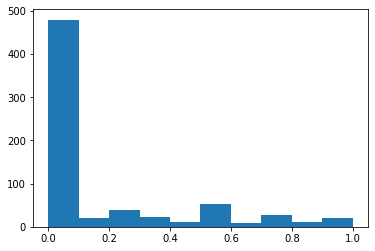

5.2392129703781647e-42


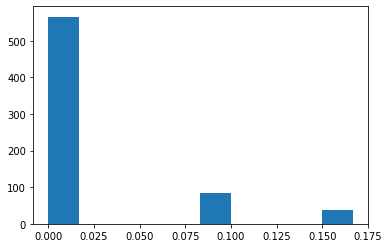

2.6118551922855257e-67


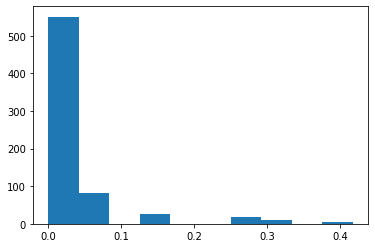

2.3818782168774065e-97


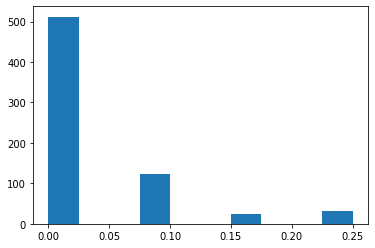

1.4752733364482604e-67


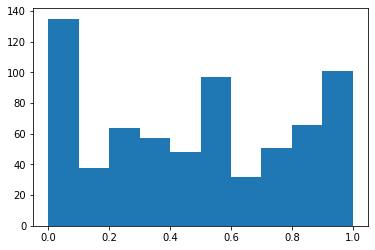

4.123944901735644e-215


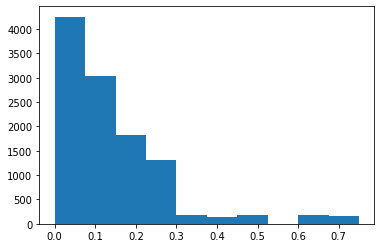

0.0


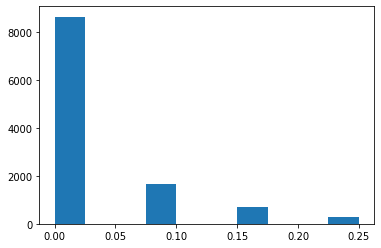

0.0


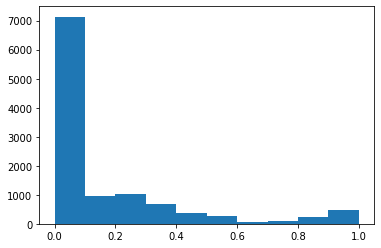

0.0


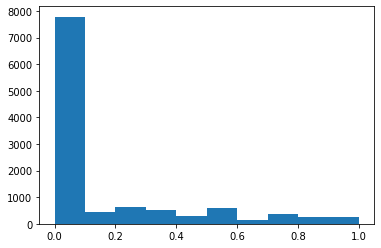

0.0


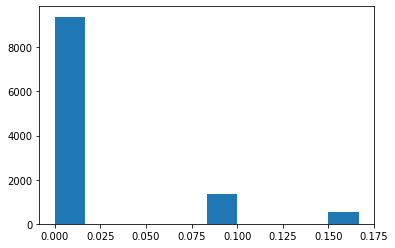

0.0


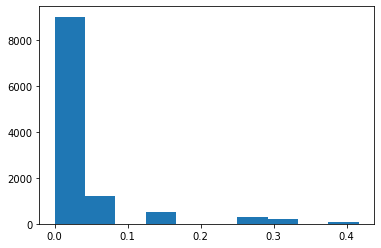

0.0


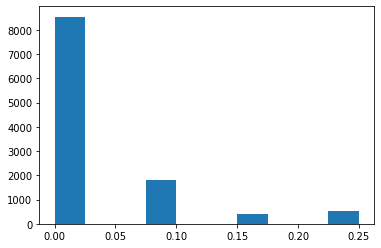

0.0


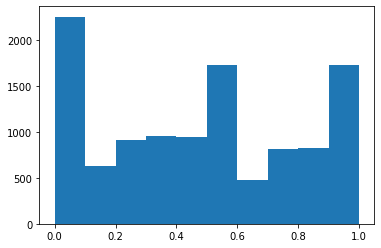

0.0
getting full data of random runs from Cerebellum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']
getting full data of random runs from Hindbrain
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']
getting full data of random runs from OLN
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']
getting full data of random runs from TS
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2500']
getting full data of random runs from Tectum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']
getting full data of random runs from Tegmentum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']
getting full data of random runs from Telencephalon
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


In [9]:
# set to true if you wish to save things
save_flag = False

for brain_reg, freqs_dict in neighbor_dist_rand.items():
    print("getting full data of random runs from {}".format(brain_reg))
    freq_list = list(freqs_dict.keys())
    print('freq labels in this region:')
    print(freq_list)

    for freq, neighbor_frac in freqs_dict.items():
        df = pd.DataFrame(neighbor_frac, columns=freq_list)
        if save_flag:
            df.to_csv(folder_path + '\\' + brain_reg + '_' + freq + '_rnd'+ str(n_iter) +'_full_data.csv')
         
        for col in df.columns:
            _, p = normaltest(df[col])
            plt.hist(df[col])
            plt.show()
            print(p)
        #print(test)
        
for brain_reg, freqs_dict in neighbor_dist_rand_summary.items():
    print("getting full data of random runs from {}".format(brain_reg))
    freq_list = list(freqs_dict.keys())
    print('freq labels in this region:')
    print(freq_list)

    for freq, neighbor_frac in freqs_dict.items():
        df = pd.DataFrame(neighbor_frac['mean'], columns=freq_list)
        
        if save_flag:
            df.to_csv(folder_path + '\\' + brain_reg + '_' + freq + '_mean_rnd'+ str(n_iter) +'_full_data.csv')
            

getting full data of random runs from Cerebellum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


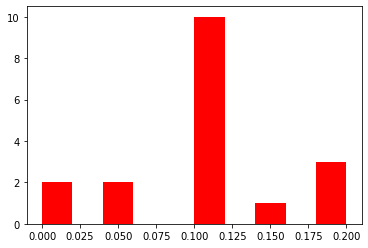

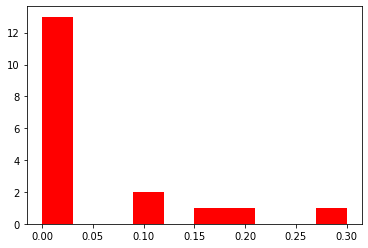

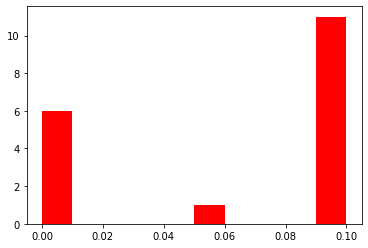

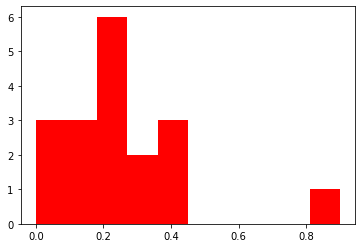

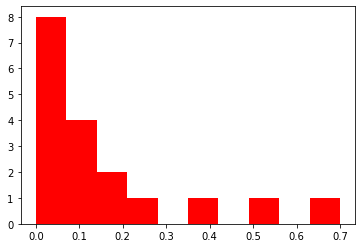

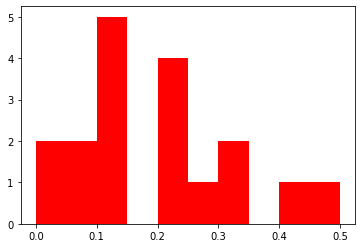

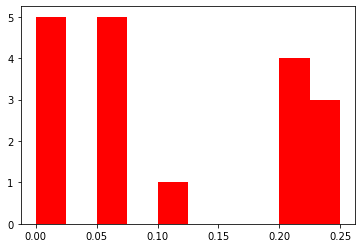

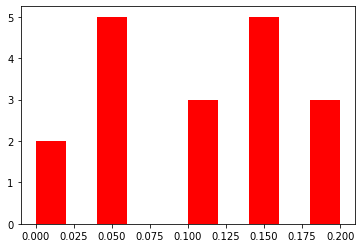

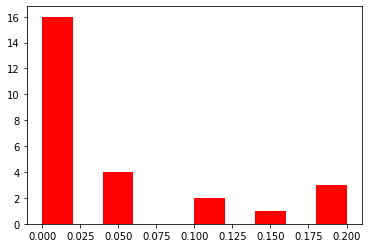

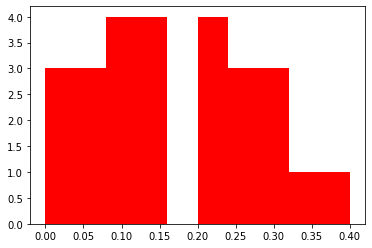

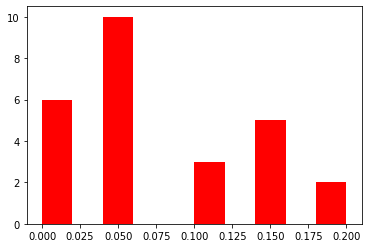

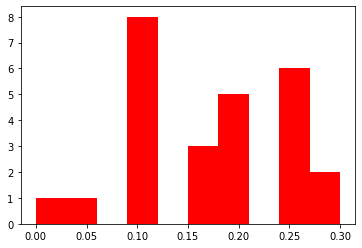

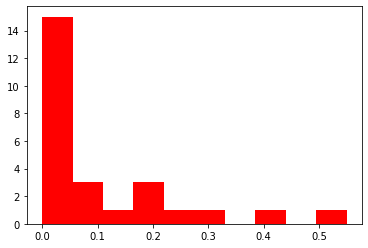

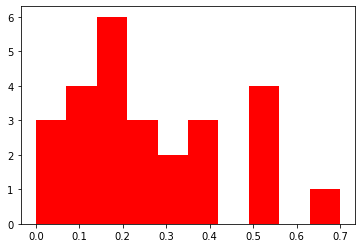

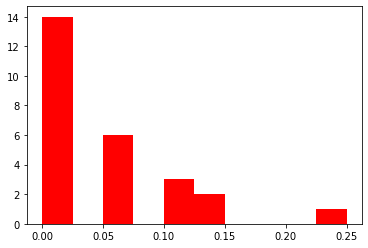

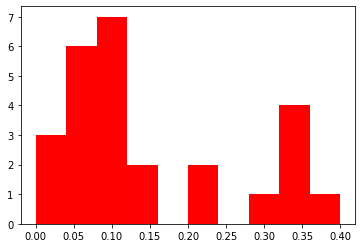

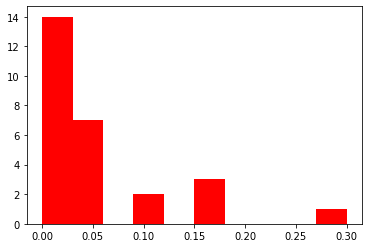

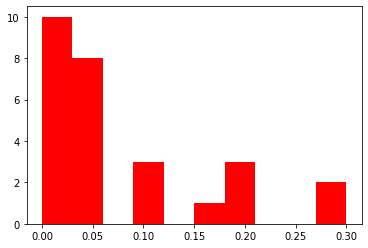

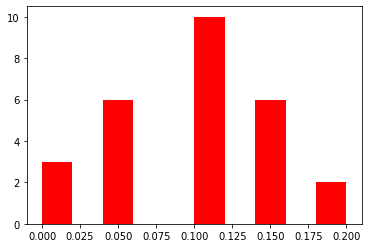

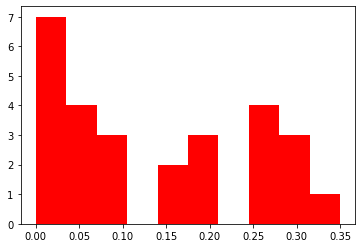

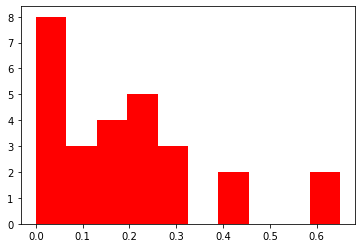

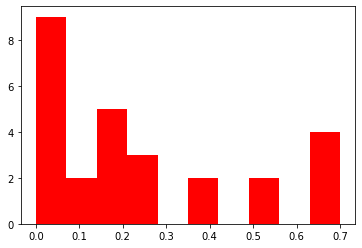

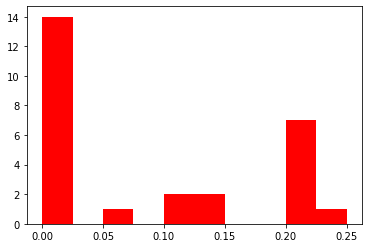

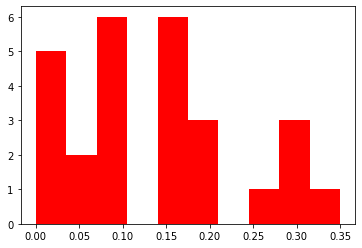

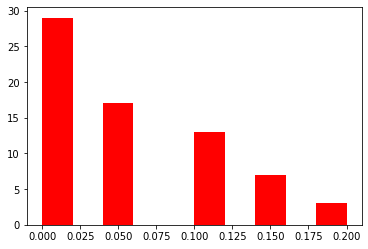

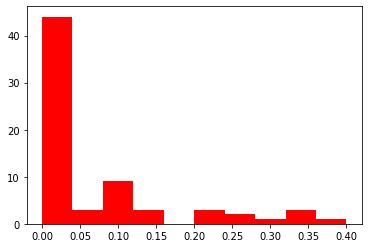

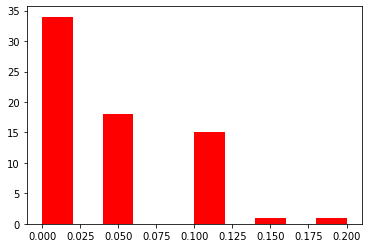

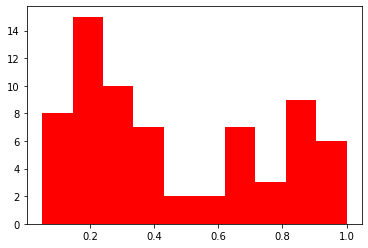

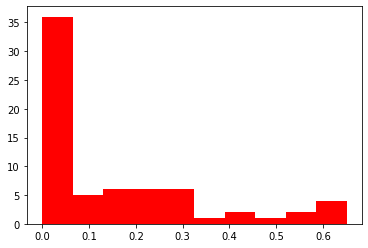

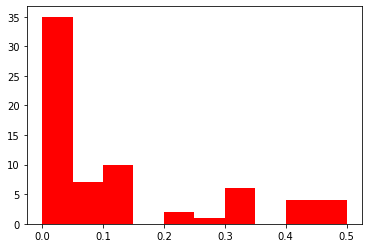

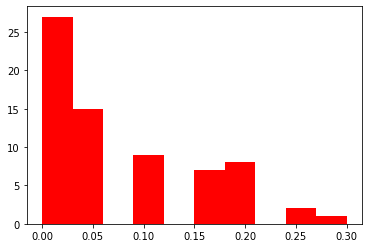

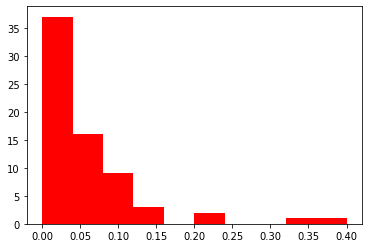

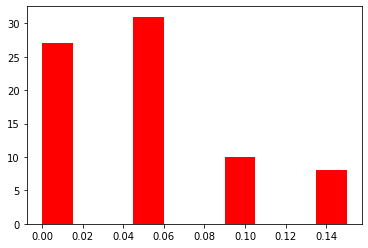

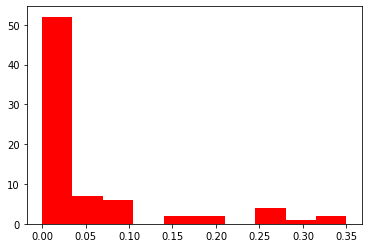

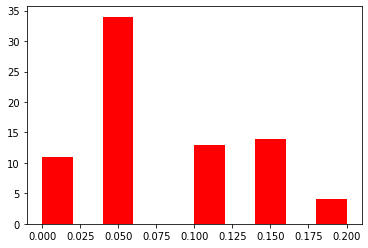

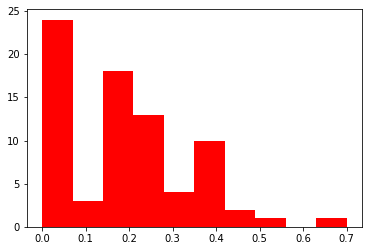

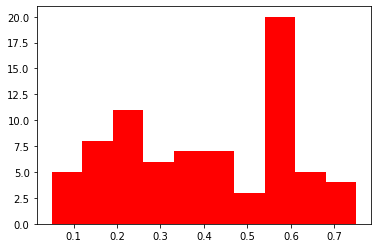

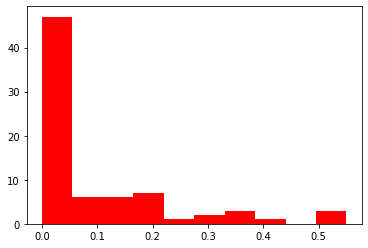

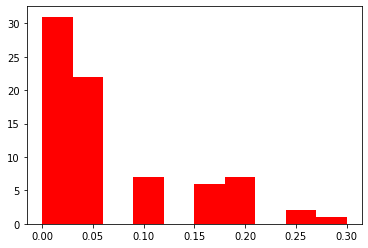

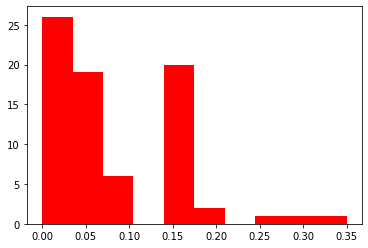

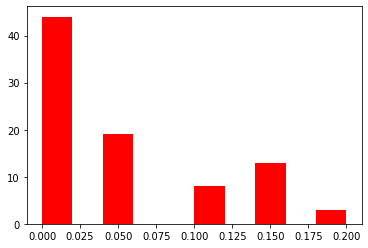

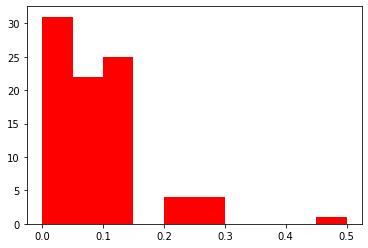

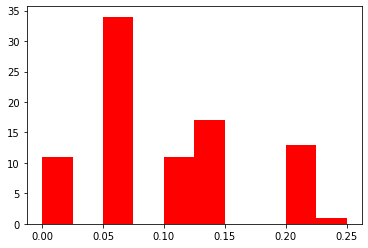

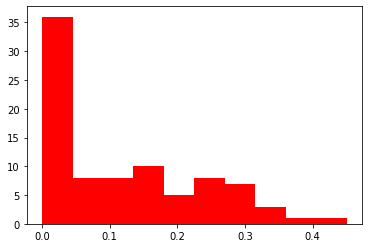

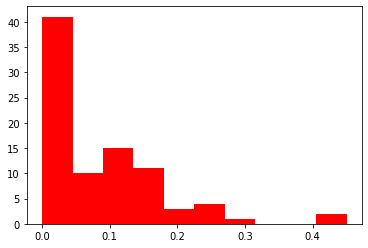

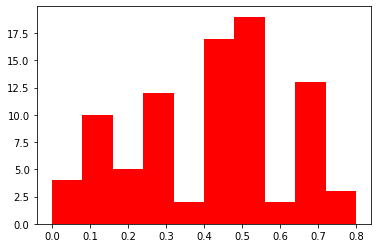

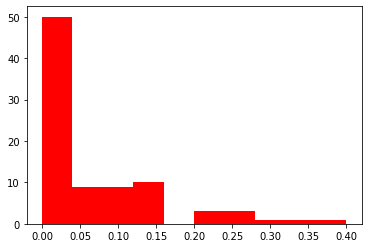

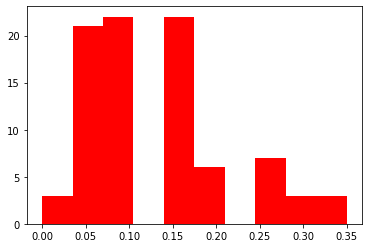

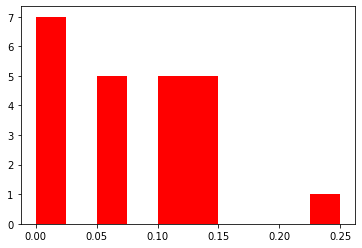

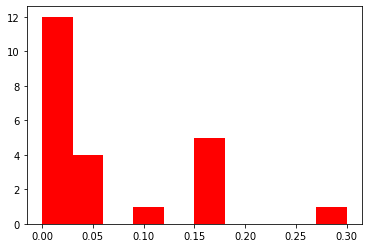

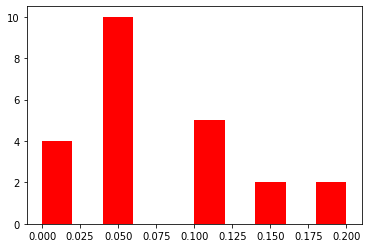

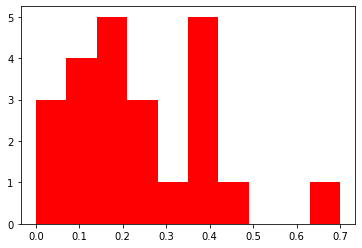

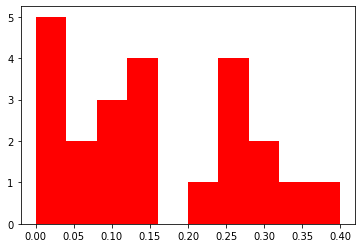

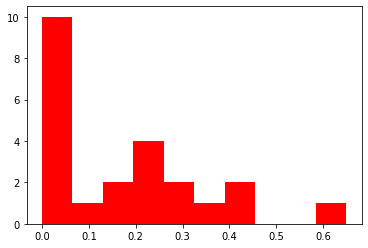

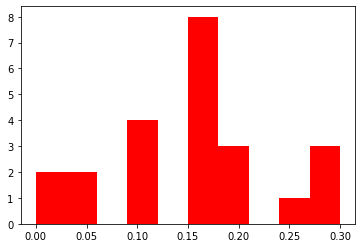

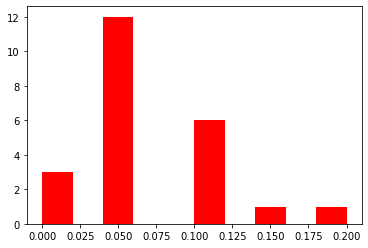

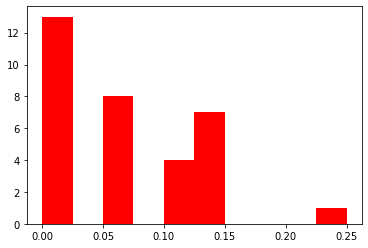

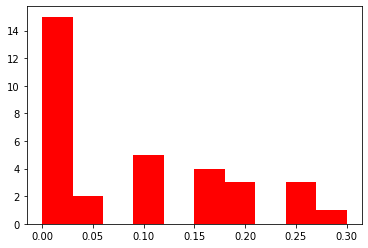

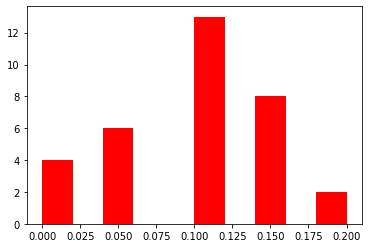

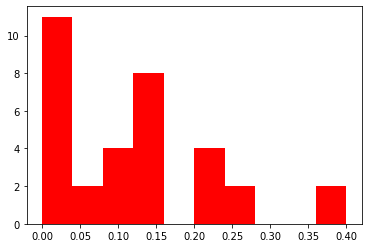

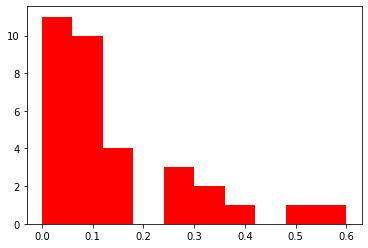

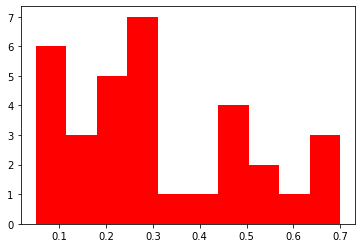

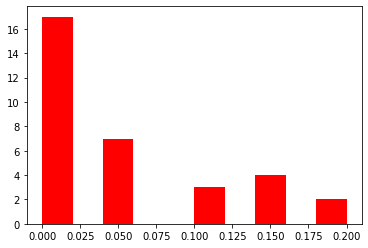

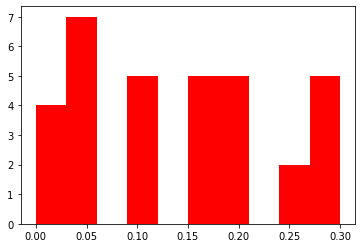

getting full data of random runs from Hindbrain
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


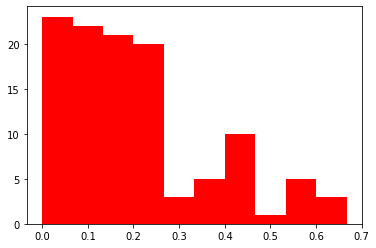

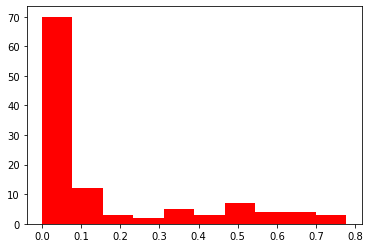

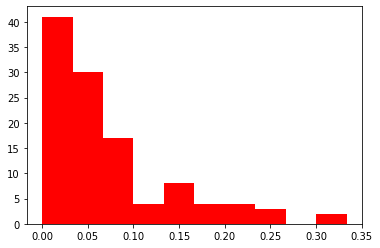

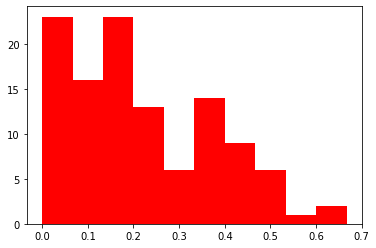

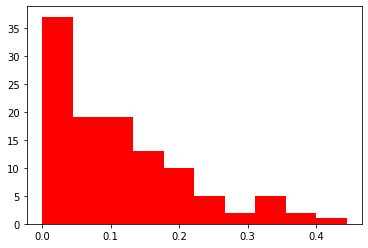

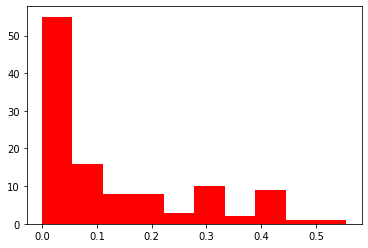

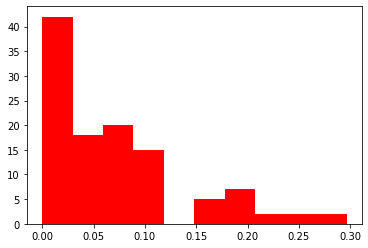

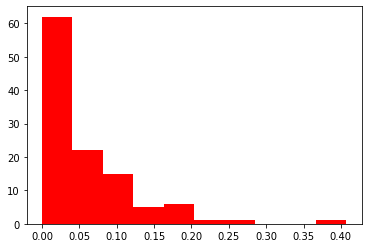

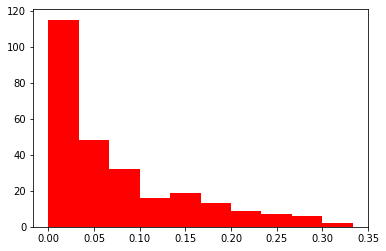

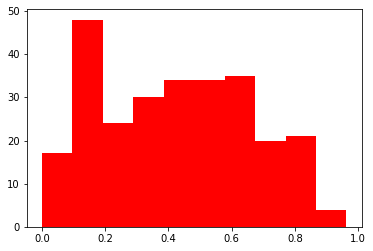

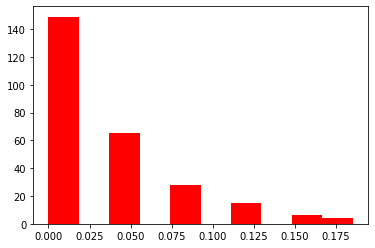

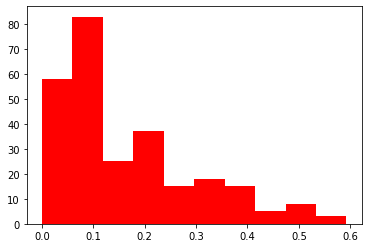

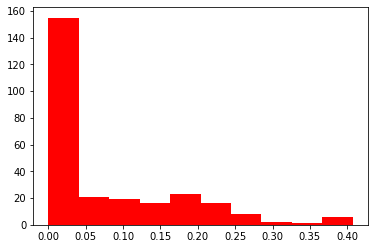

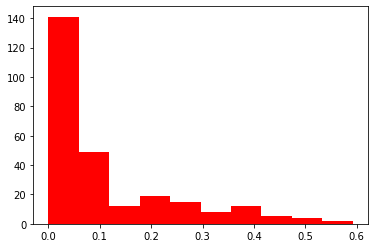

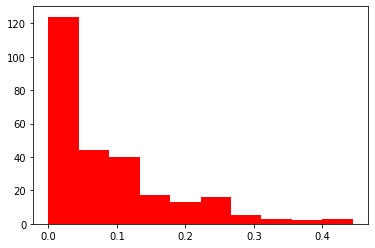

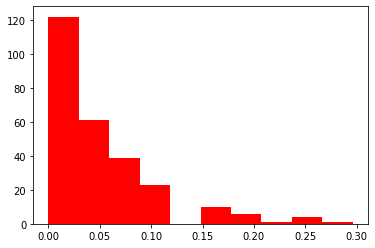

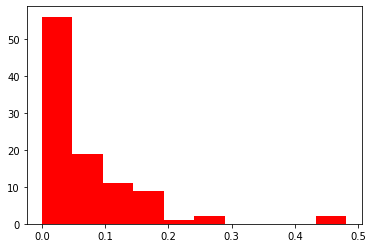

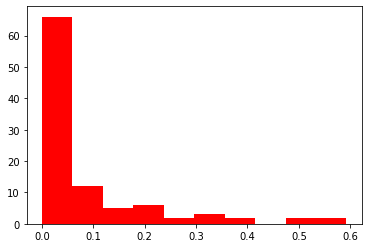

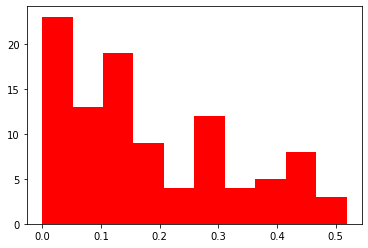

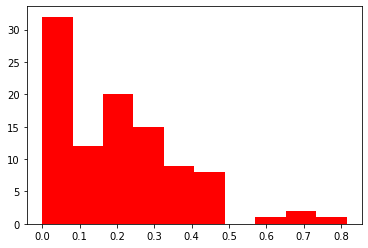

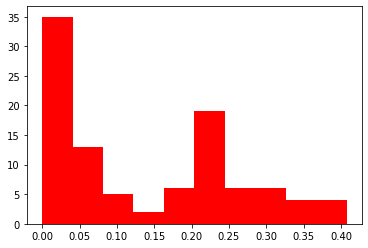

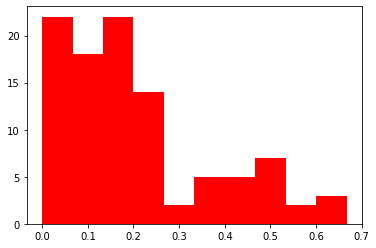

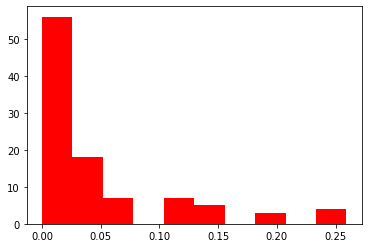

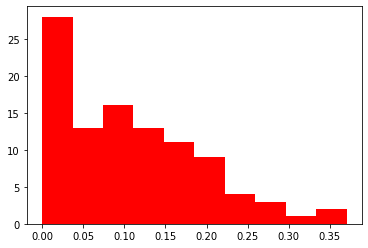

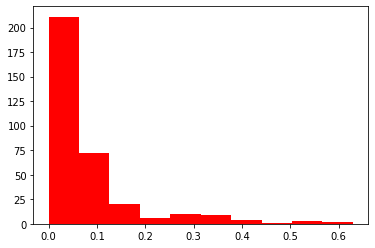

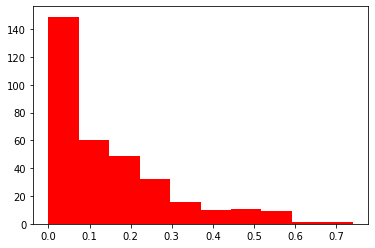

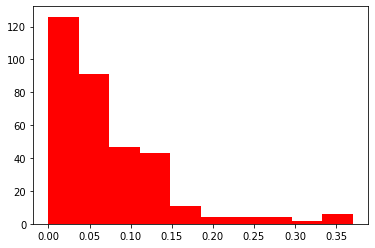

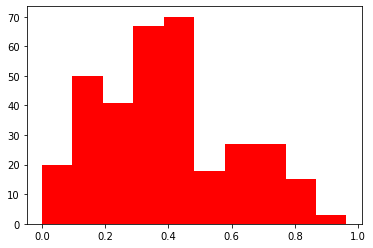

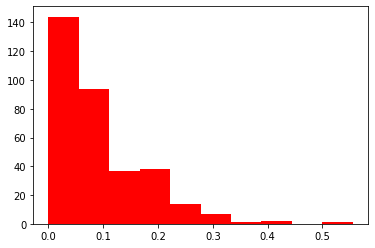

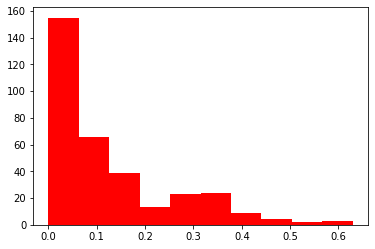

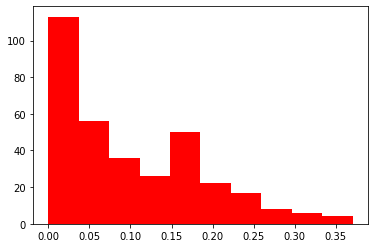

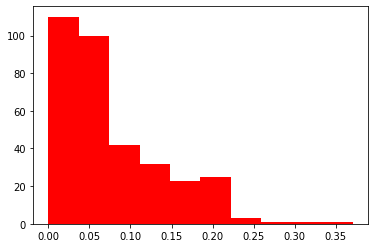

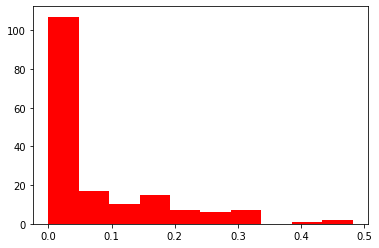

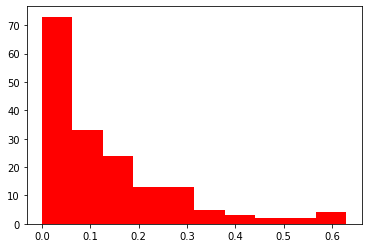

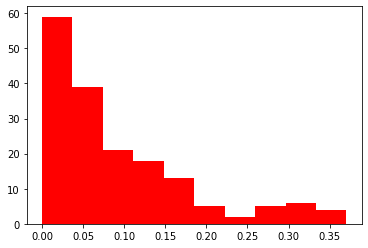

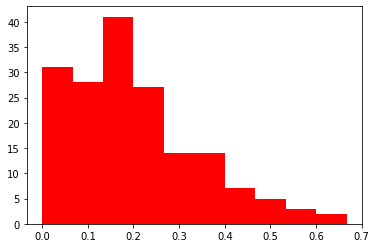

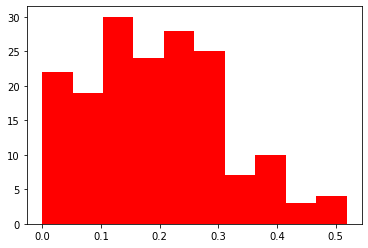

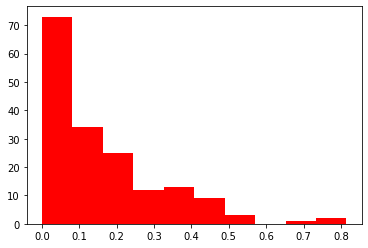

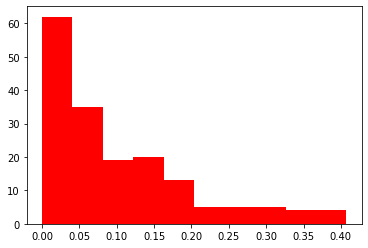

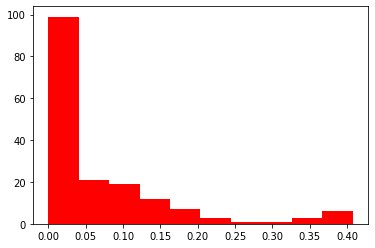

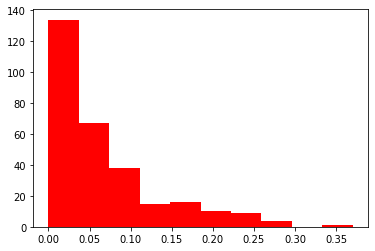

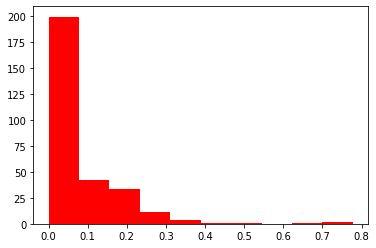

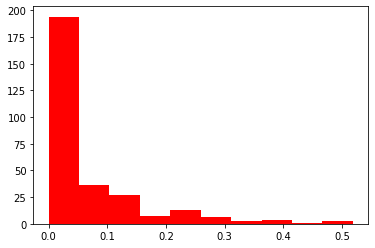

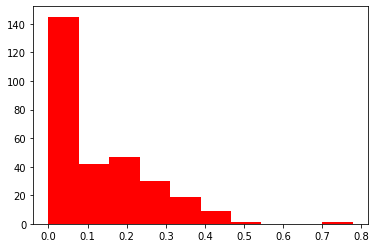

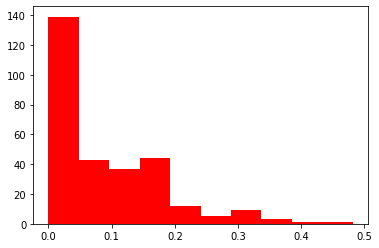

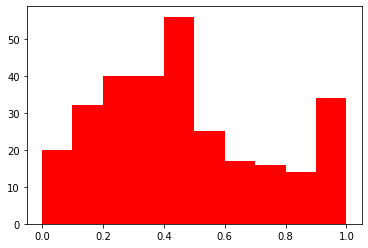

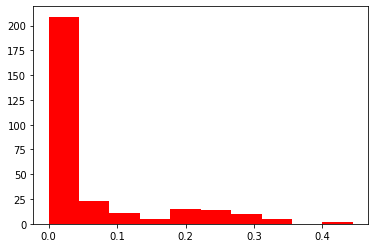

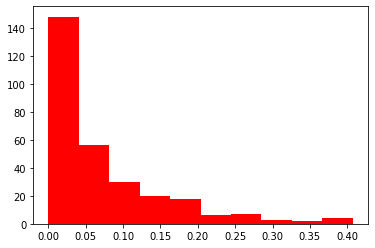

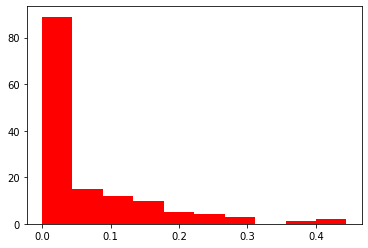

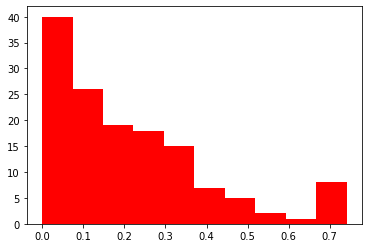

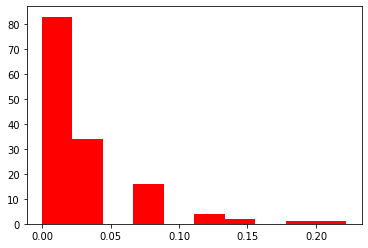

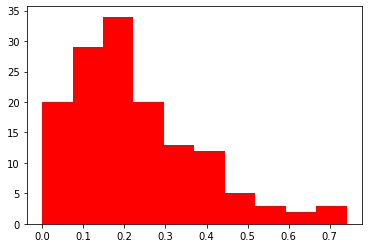

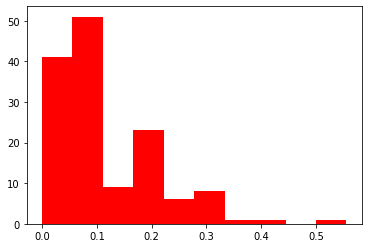

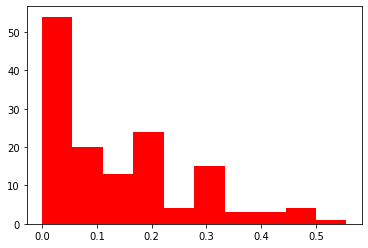

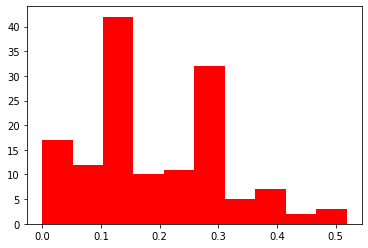

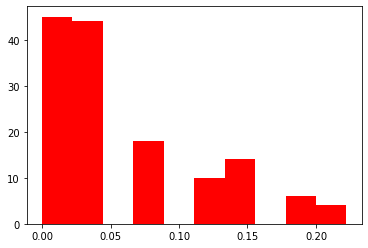

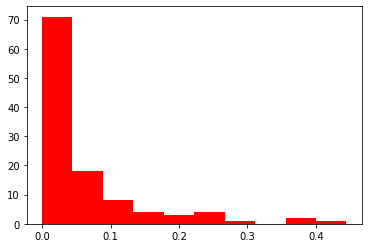

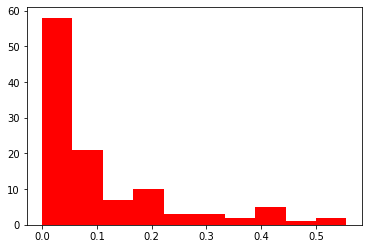

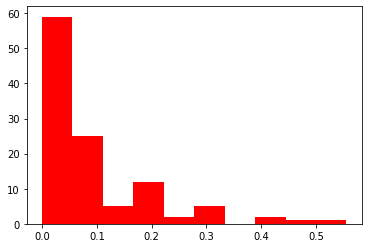

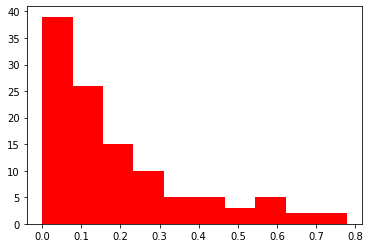

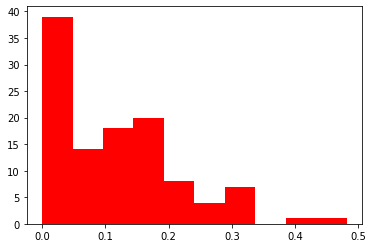

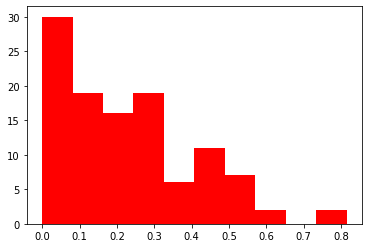

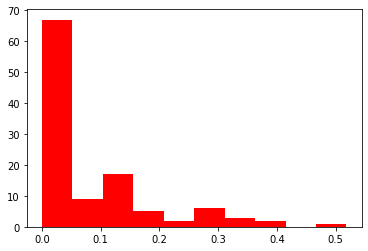

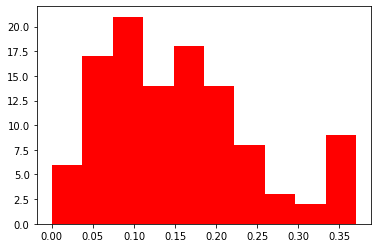

getting full data of random runs from OLN
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


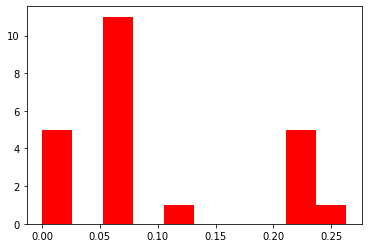

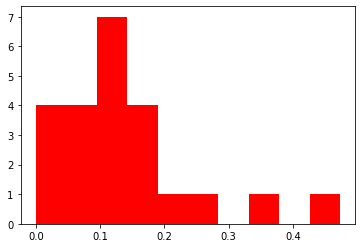

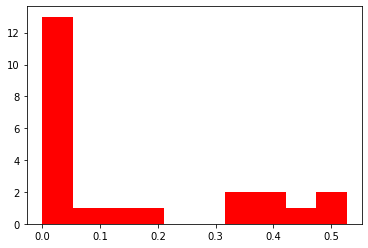

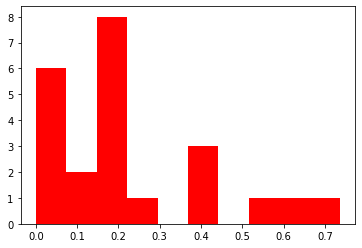

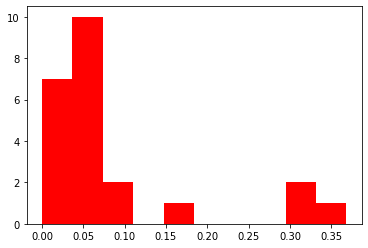

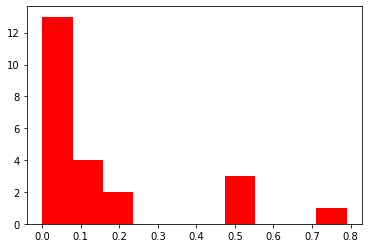

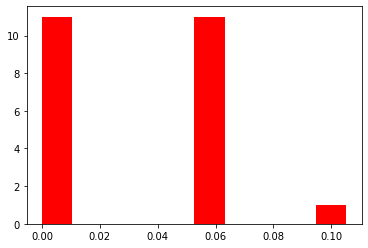

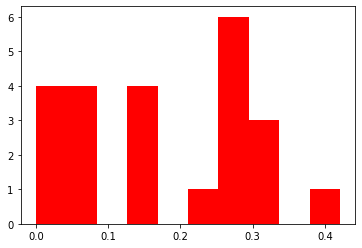

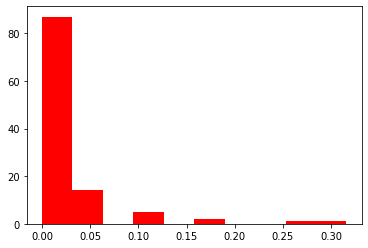

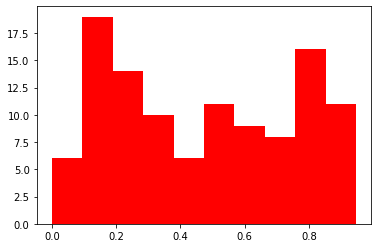

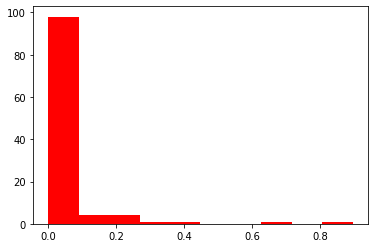

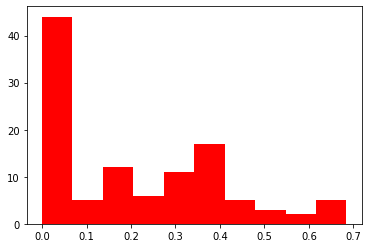

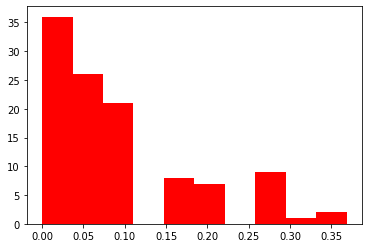

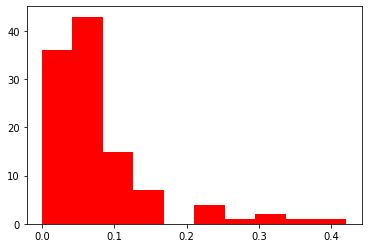

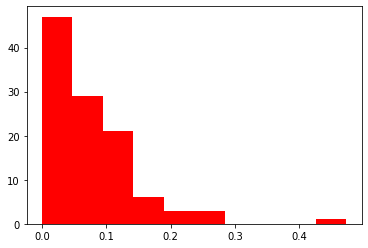

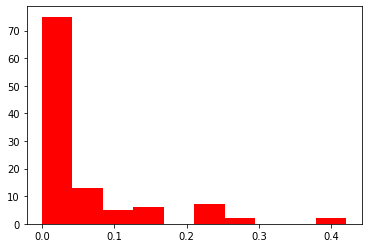

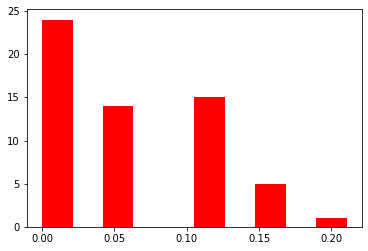

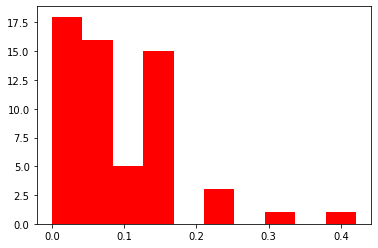

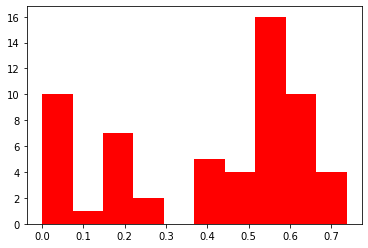

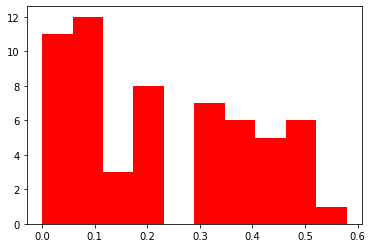

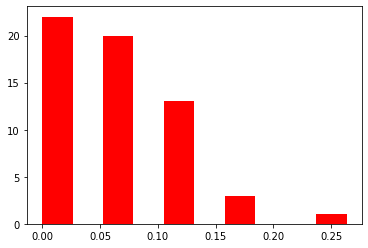

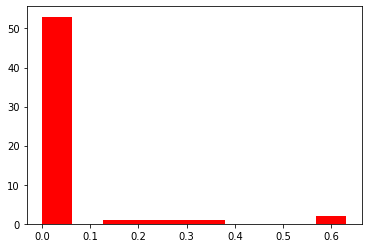

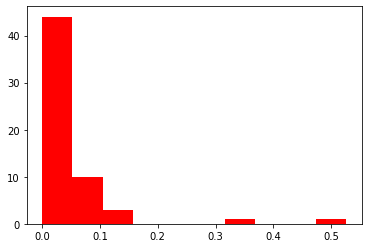

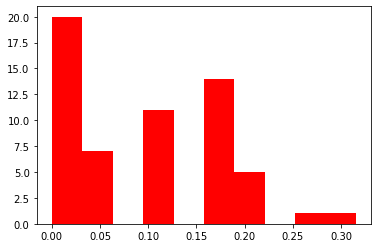

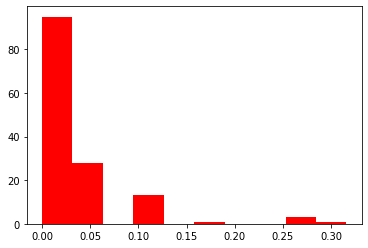

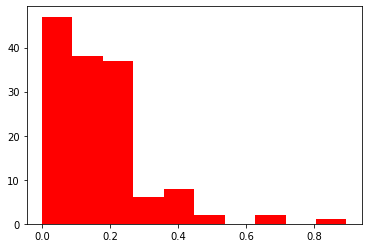

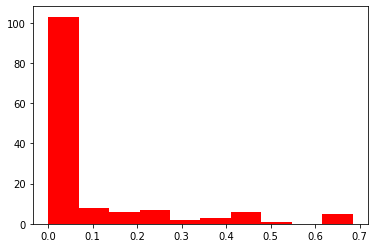

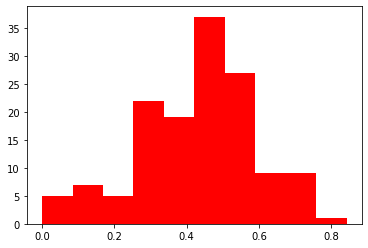

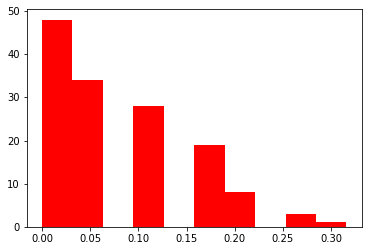

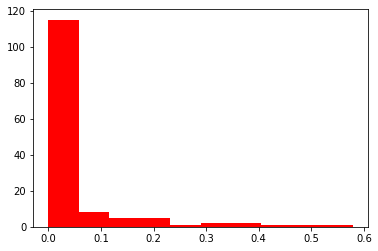

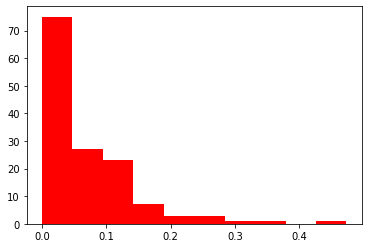

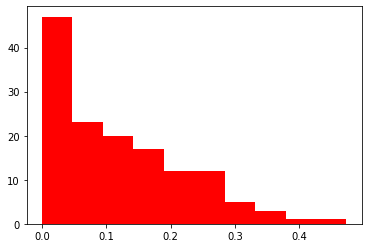

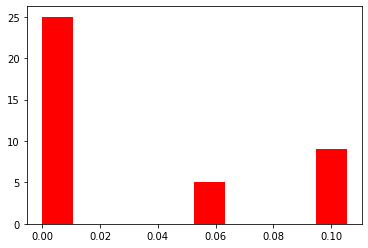

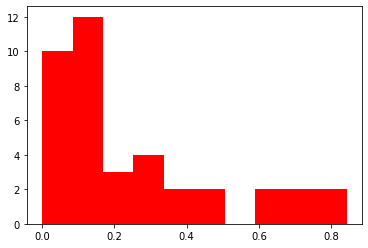

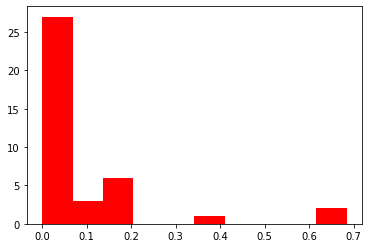

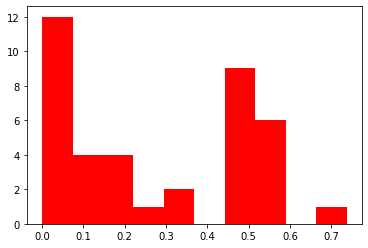

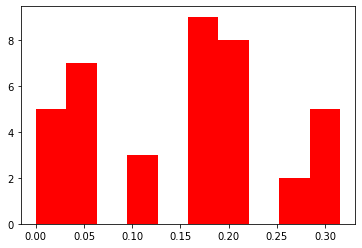

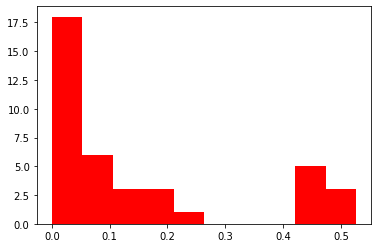

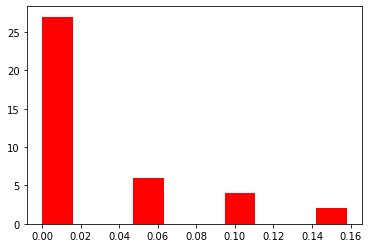

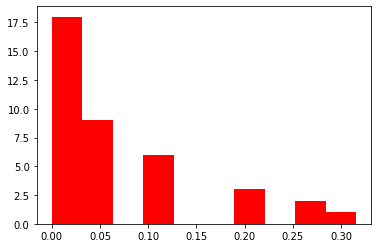

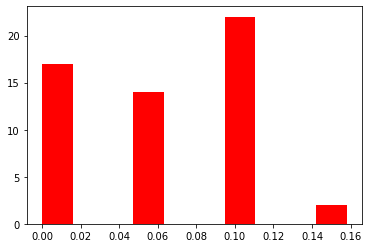

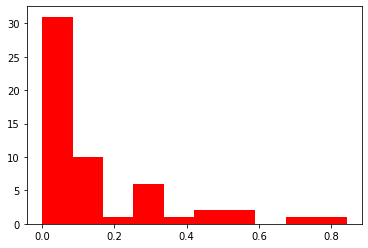

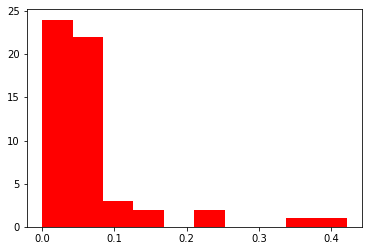

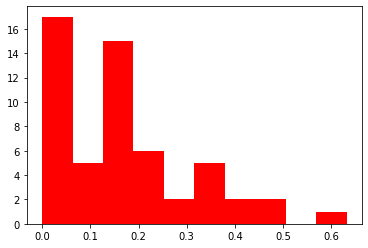

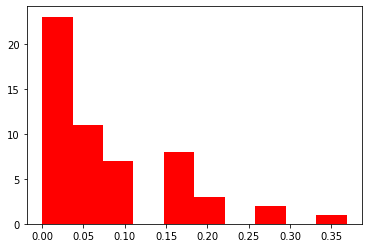

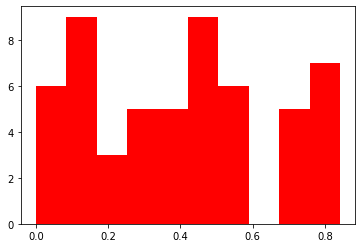

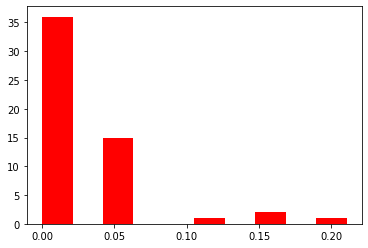

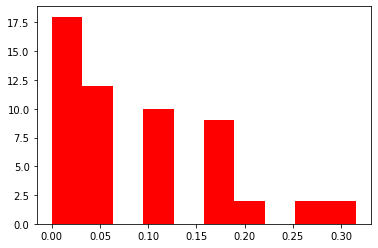

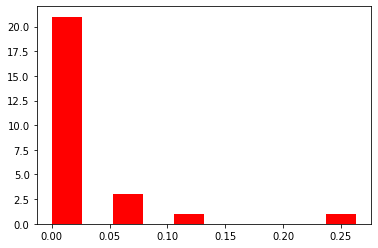

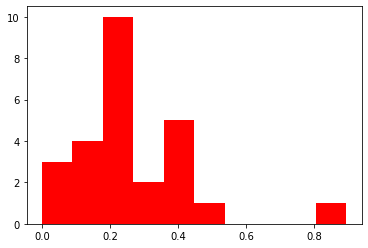

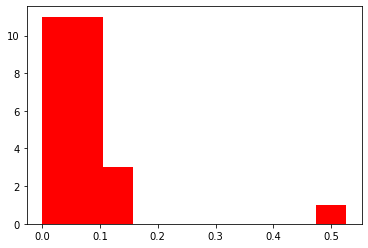

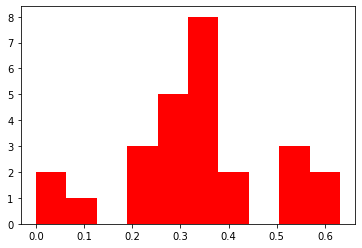

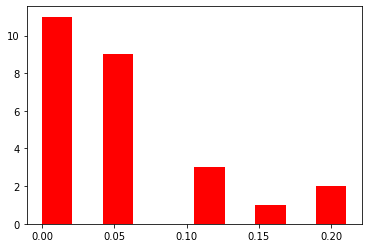

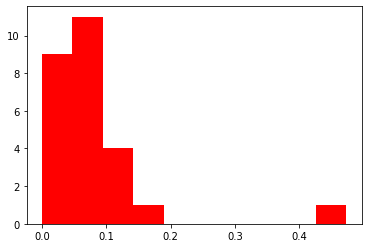

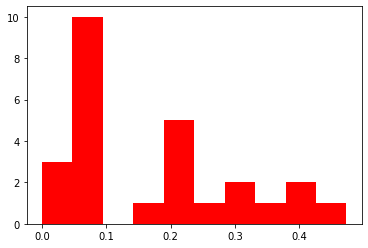

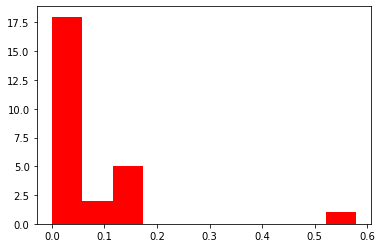

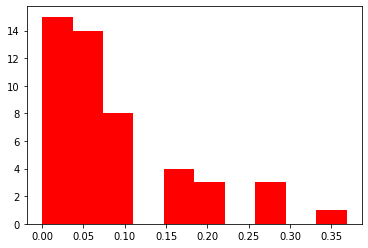

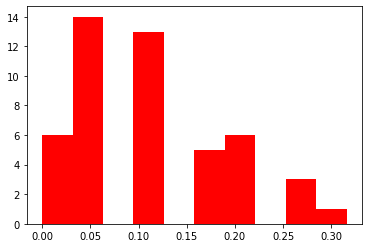

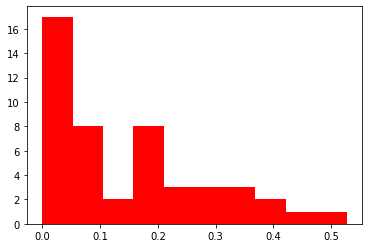

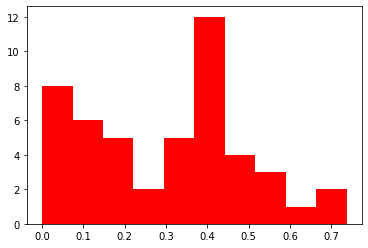

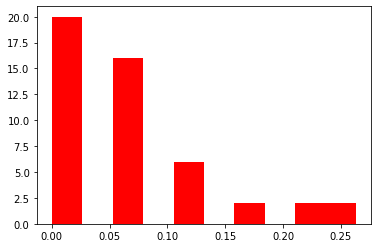

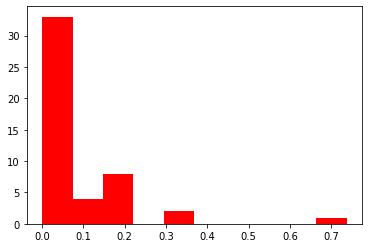

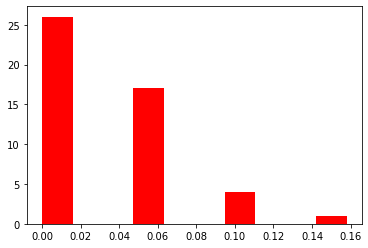

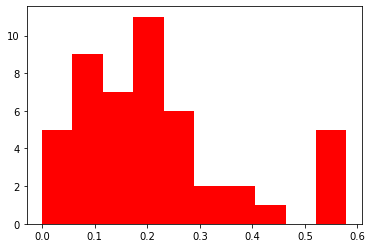

getting full data of random runs from TS
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2500']


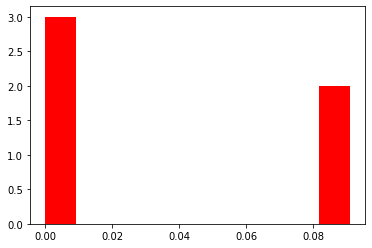

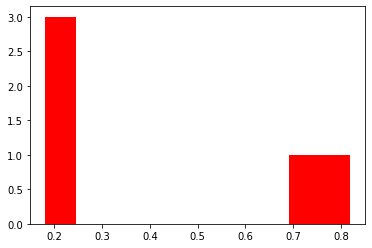

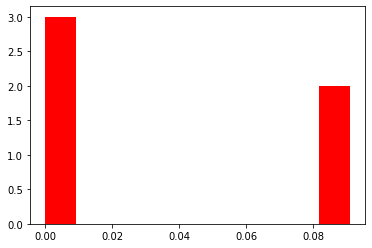

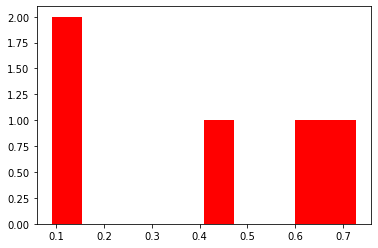

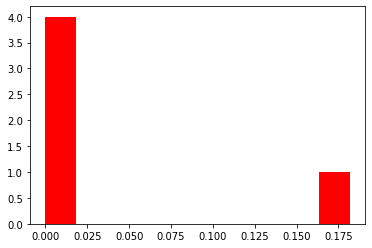

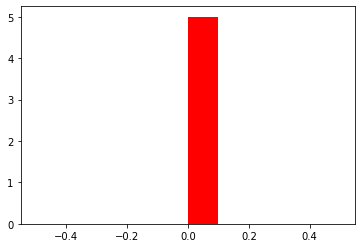

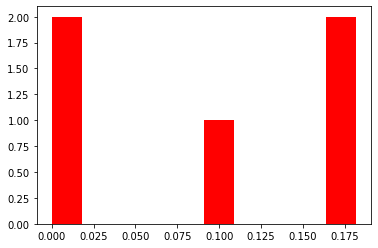

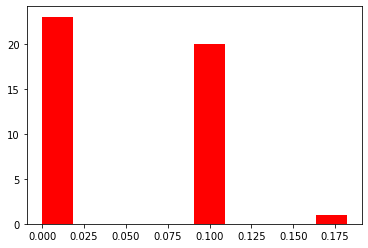

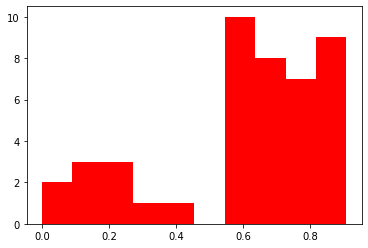

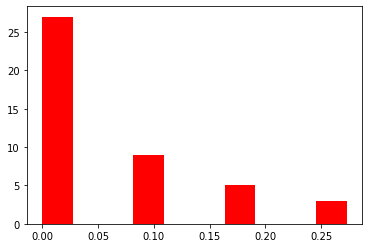

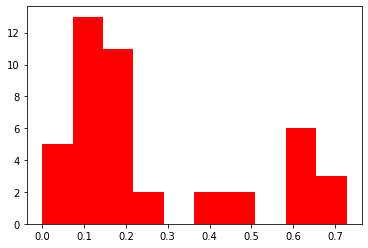

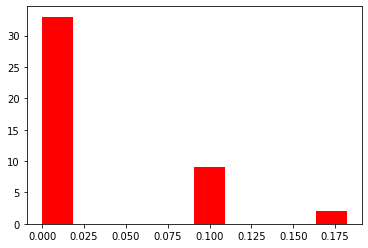

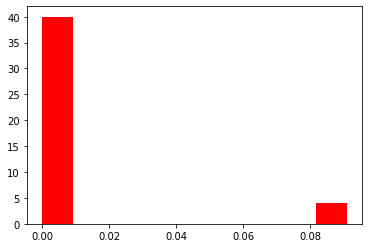

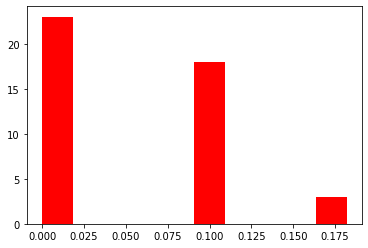

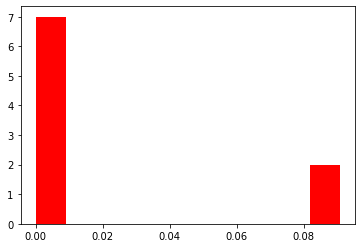

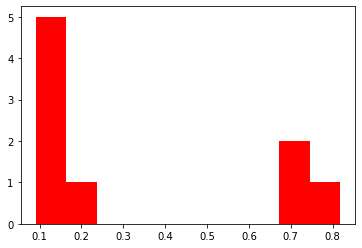

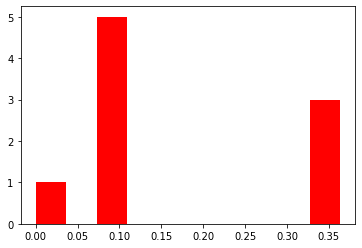

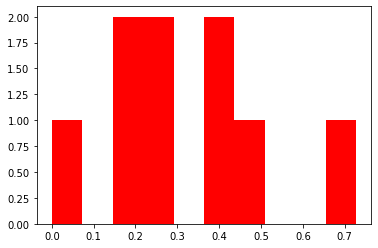

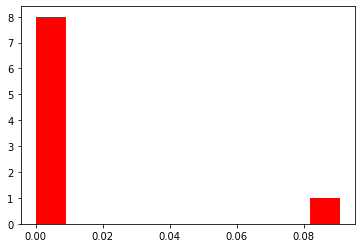

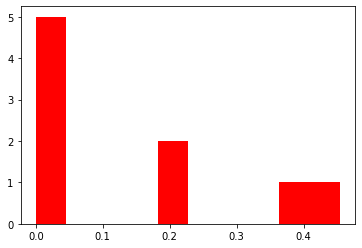

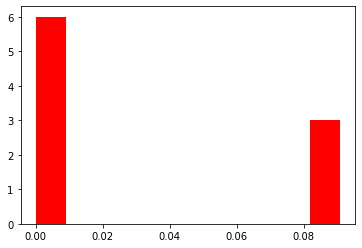

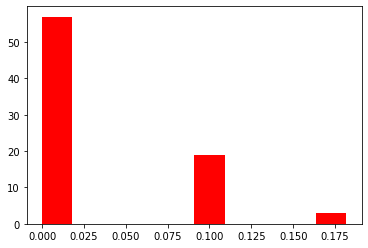

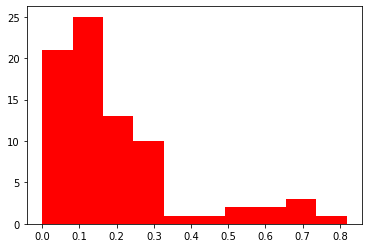

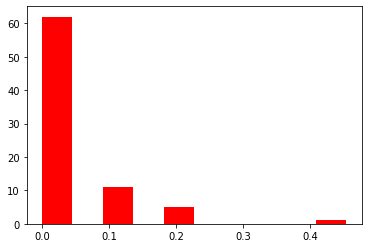

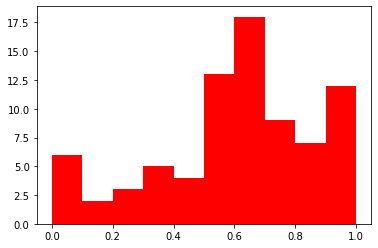

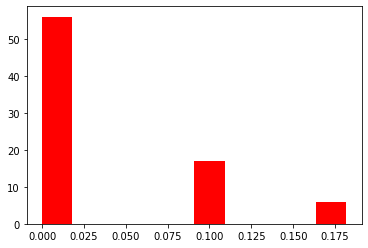

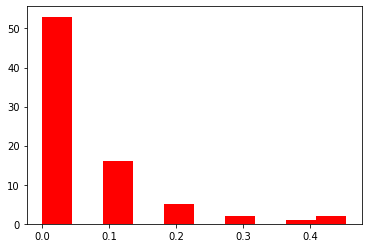

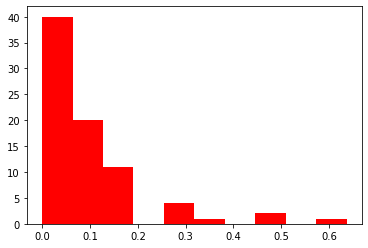

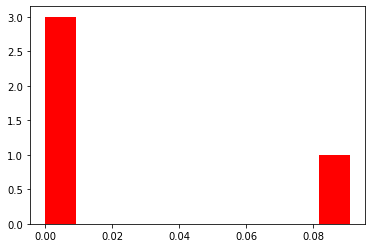

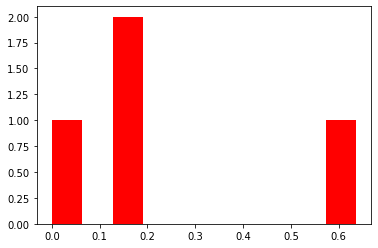

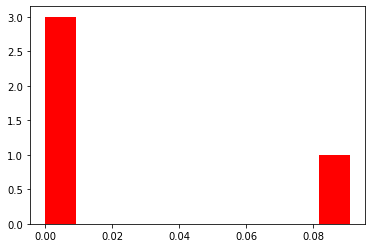

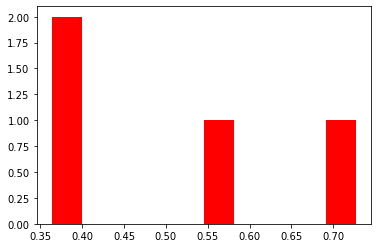

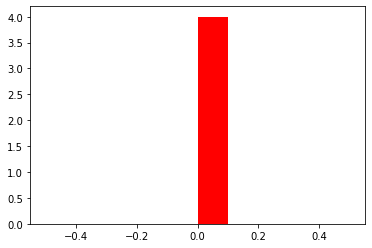

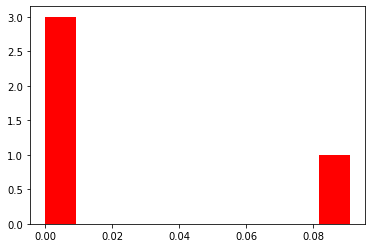

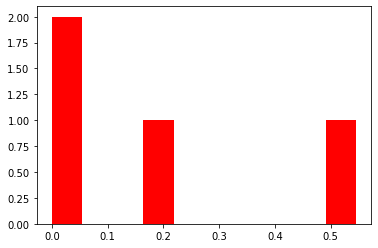

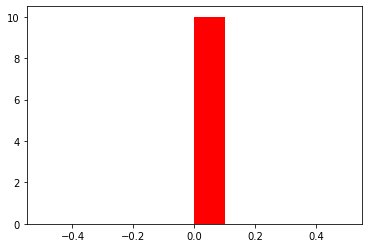

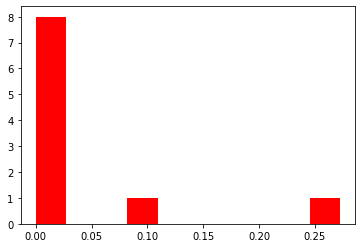

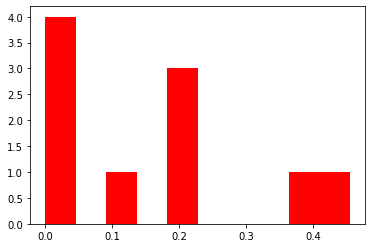

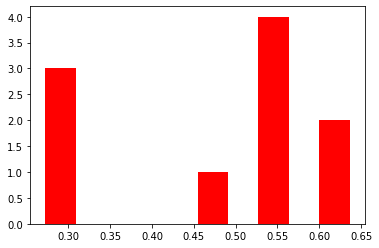

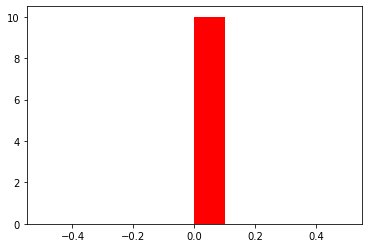

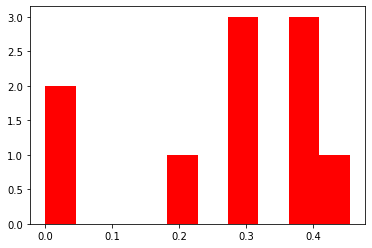

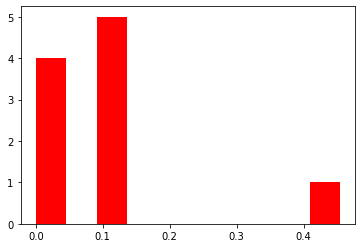

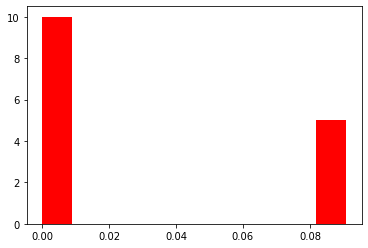

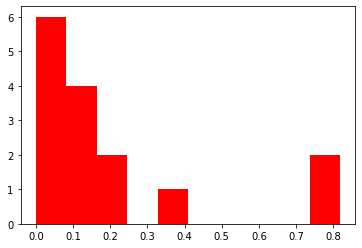

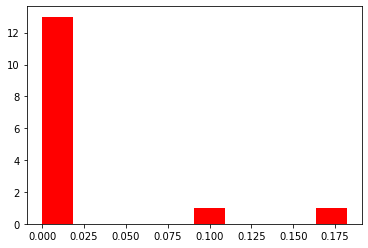

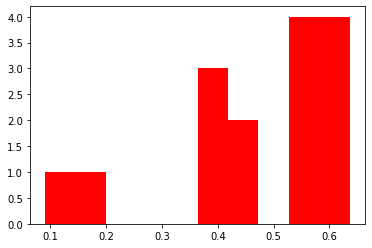

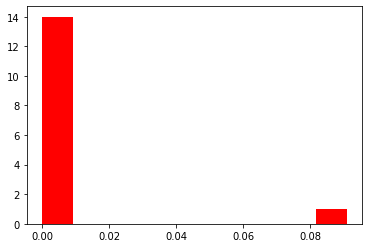

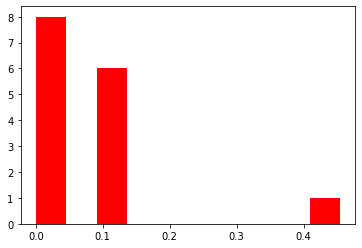

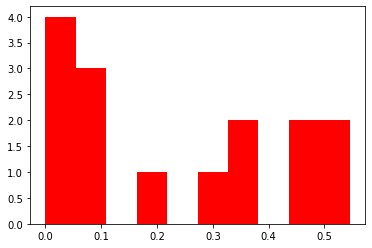

getting full data of random runs from Tectum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


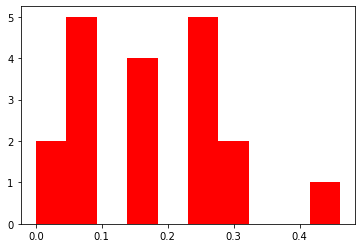

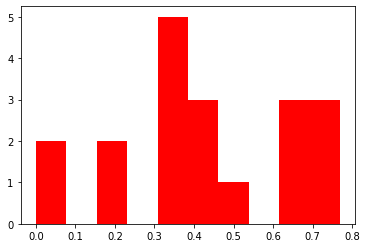

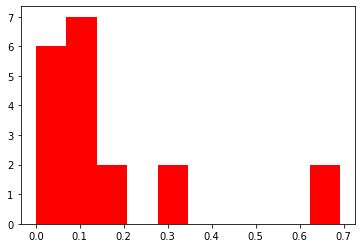

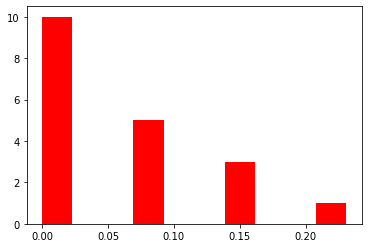

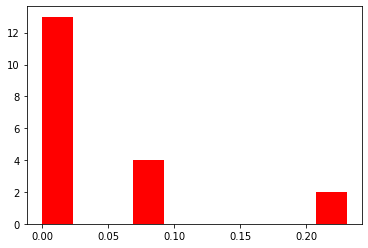

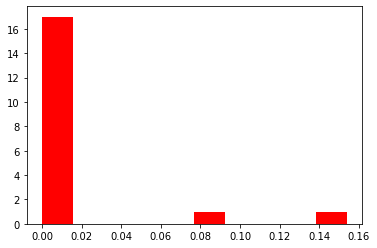

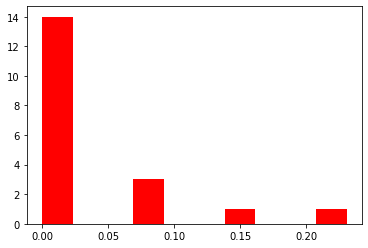

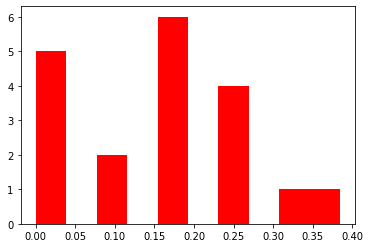

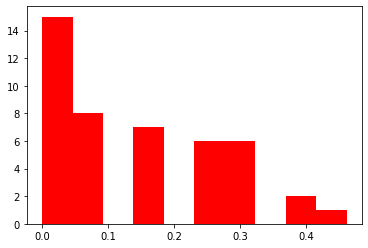

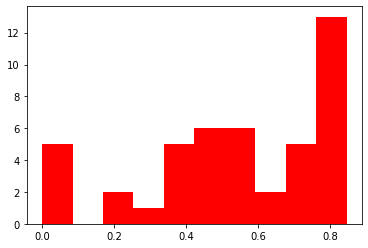

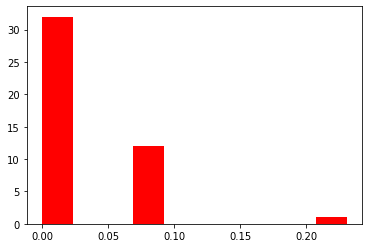

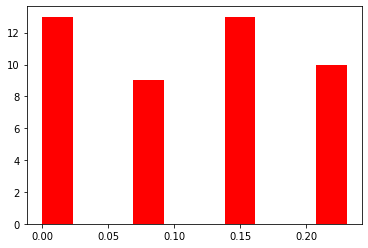

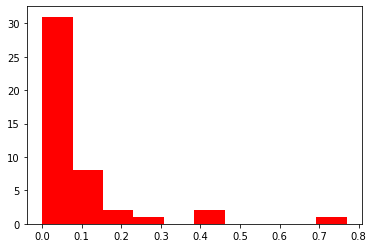

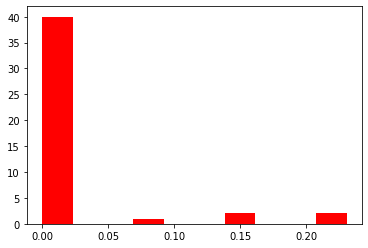

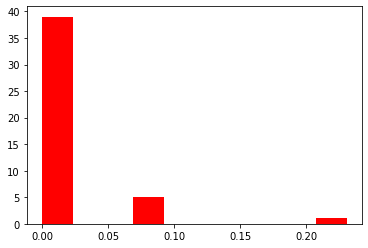

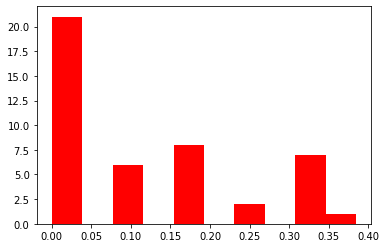

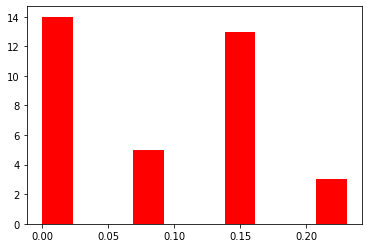

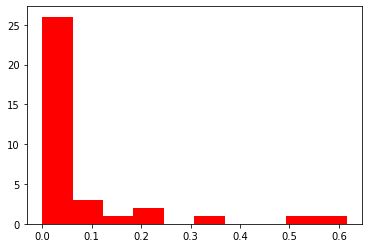

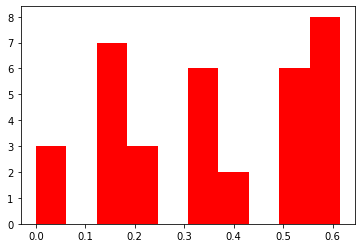

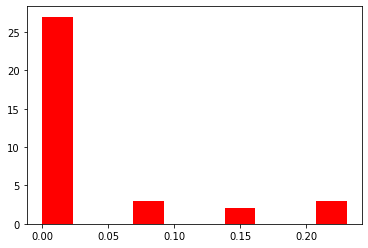

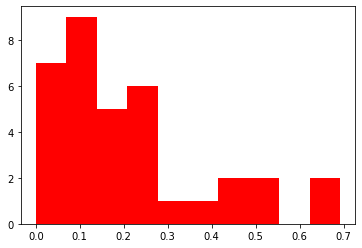

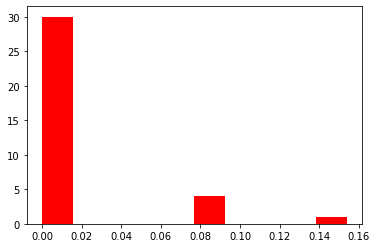

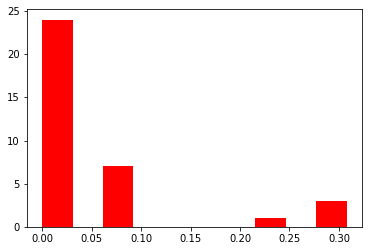

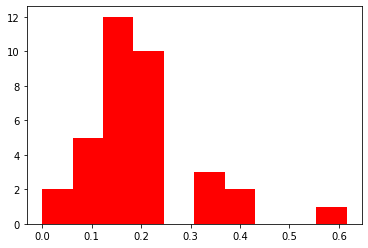

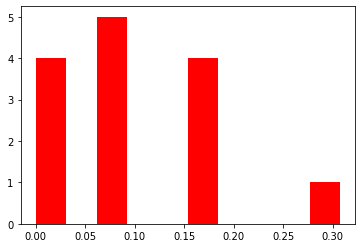

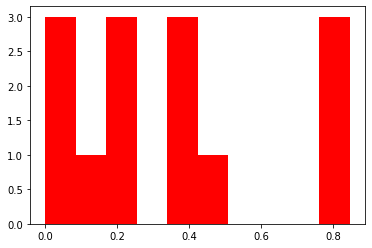

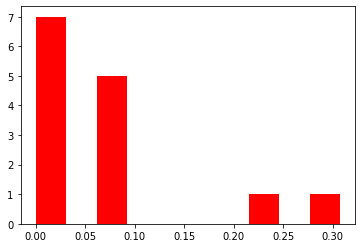

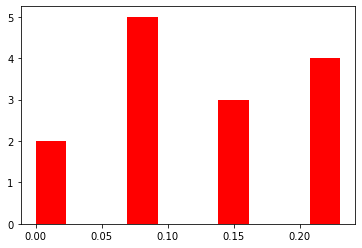

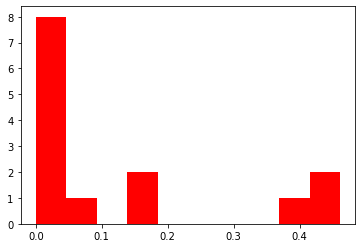

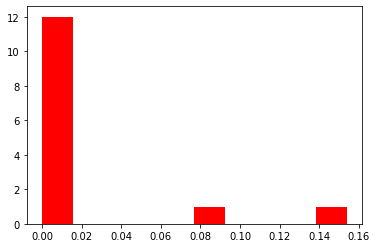

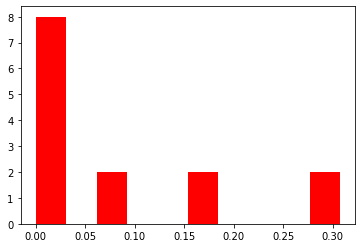

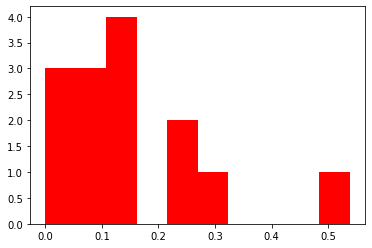

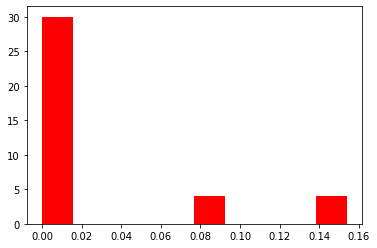

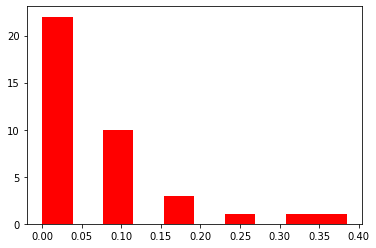

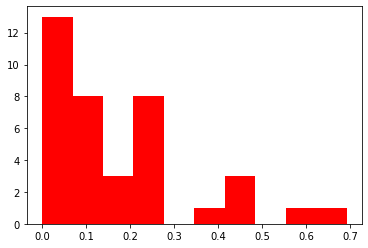

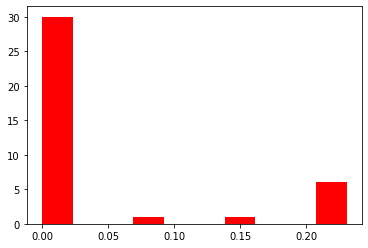

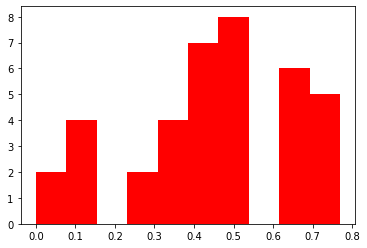

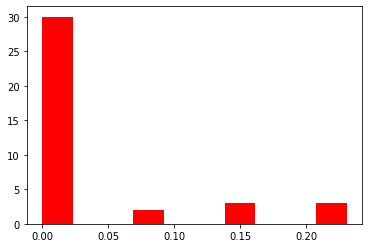

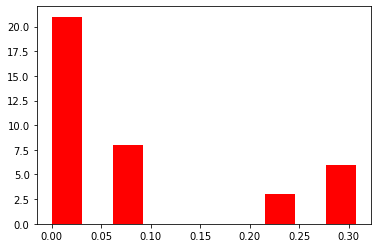

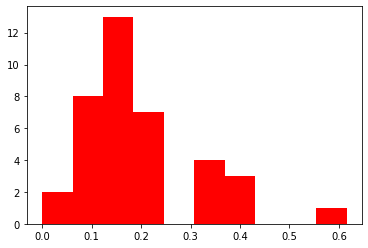

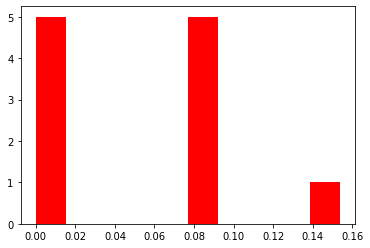

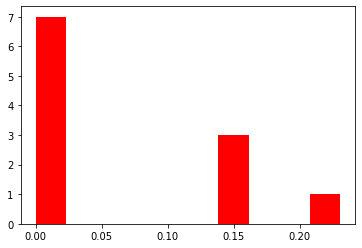

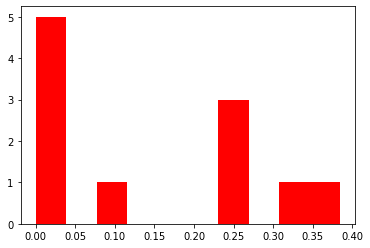

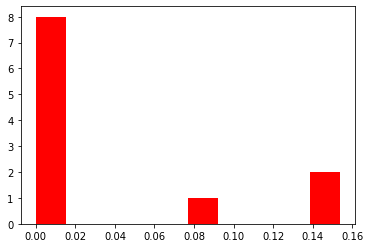

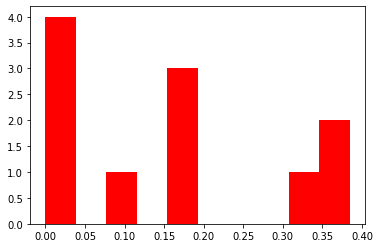

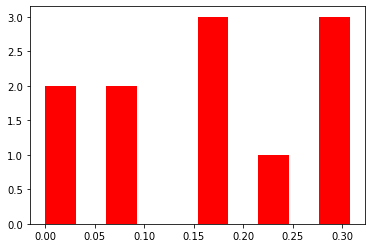

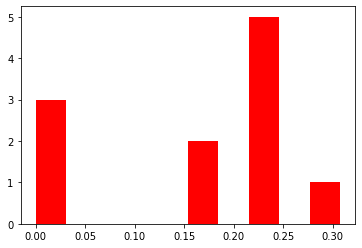

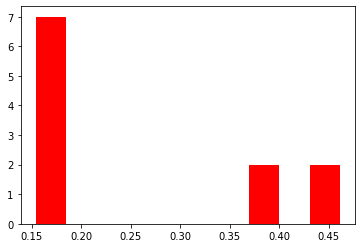

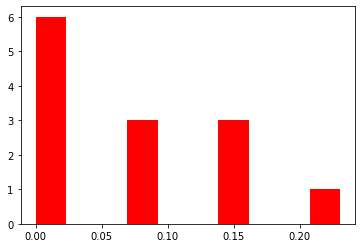

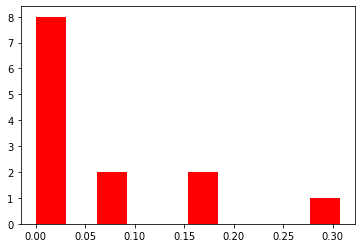

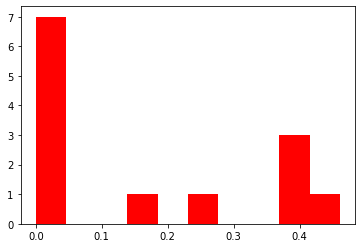

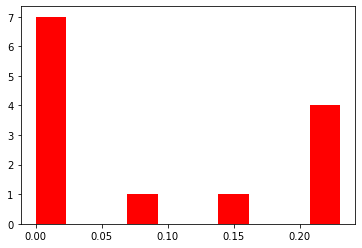

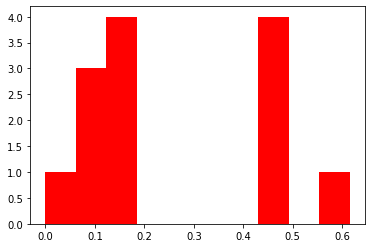

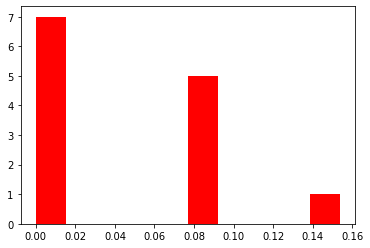

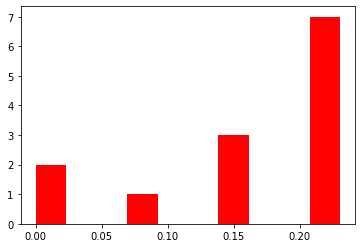

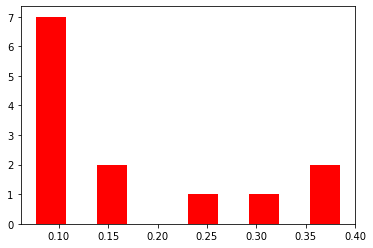

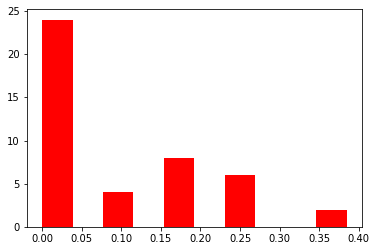

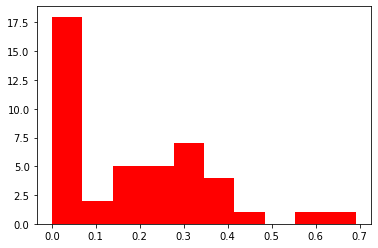

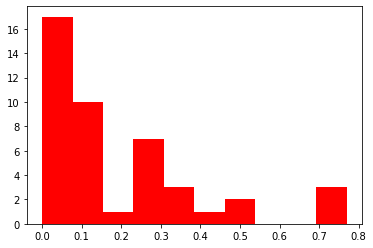

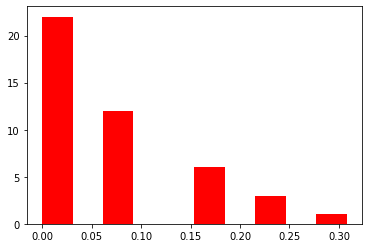

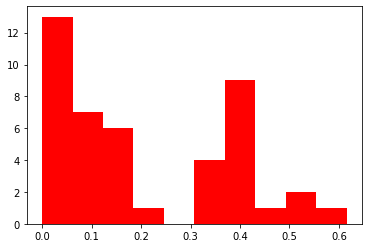

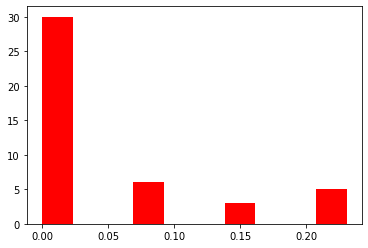

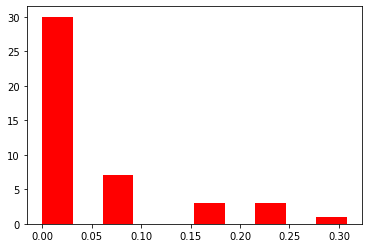

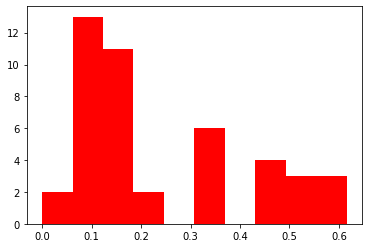

getting full data of random runs from Tegmentum
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


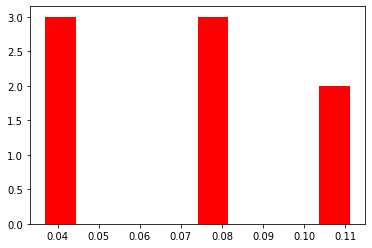

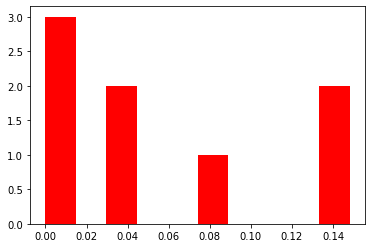

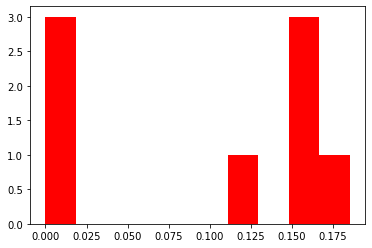

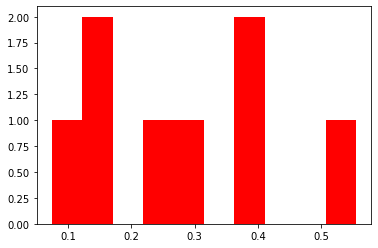

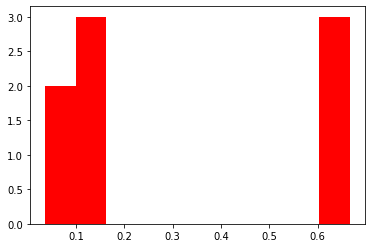

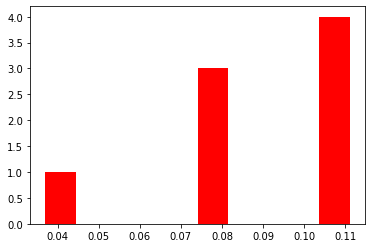

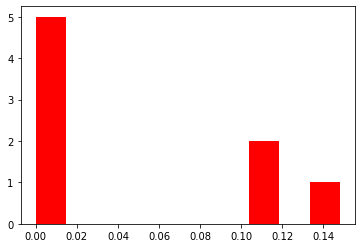

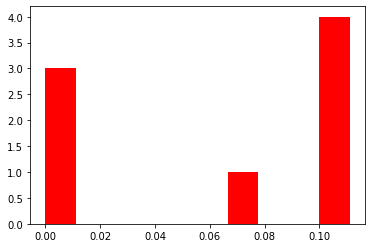

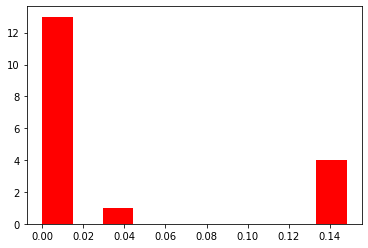

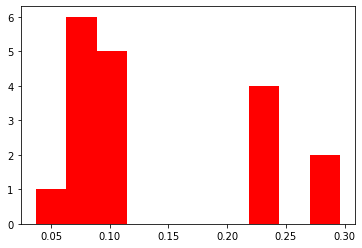

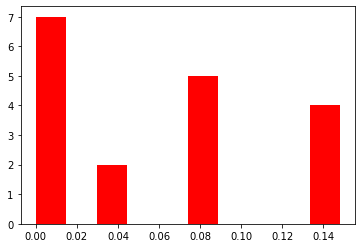

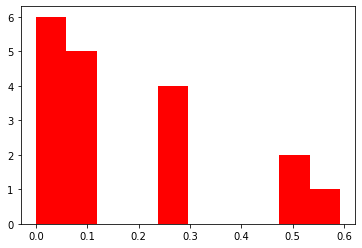

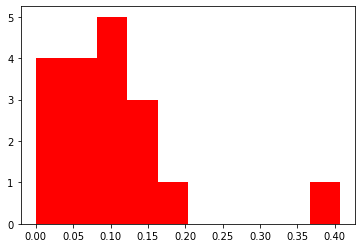

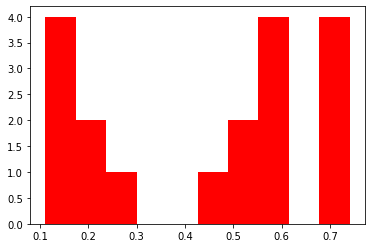

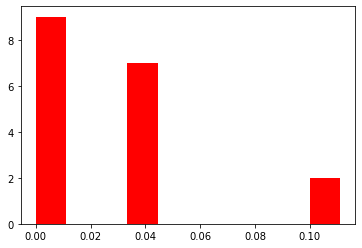

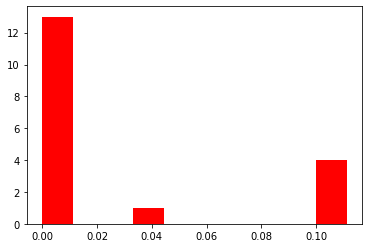

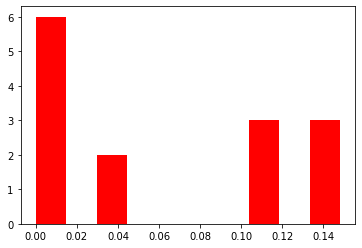

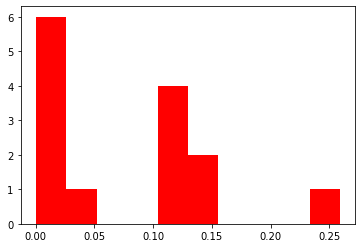

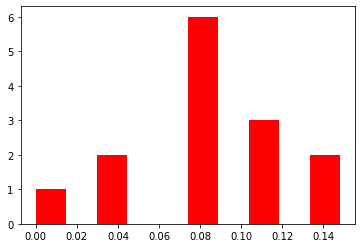

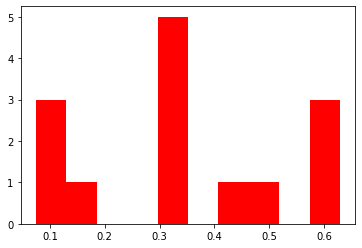

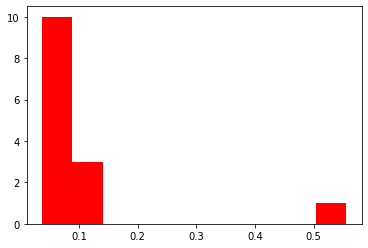

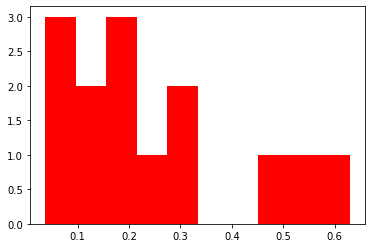

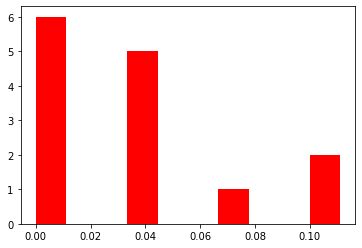

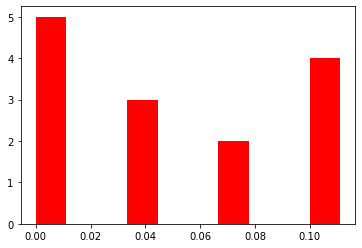

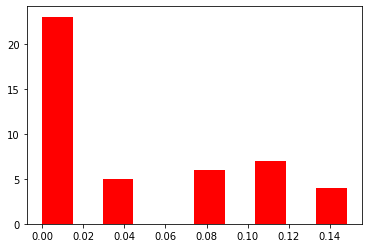

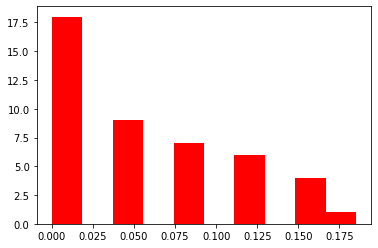

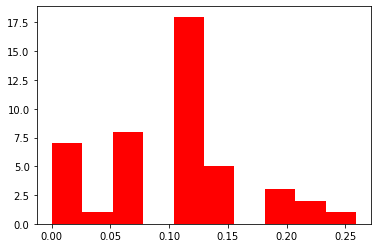

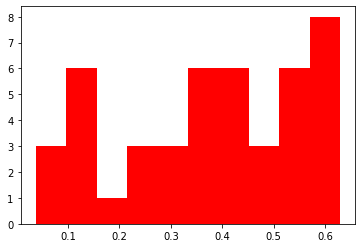

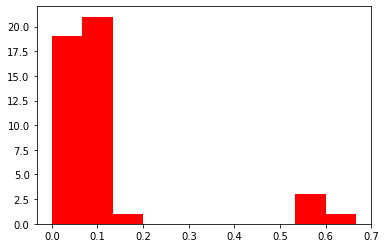

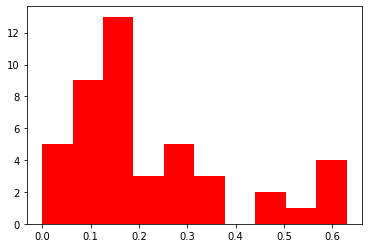

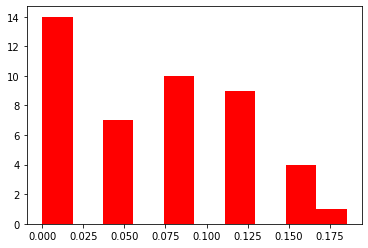

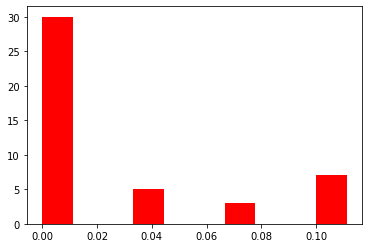

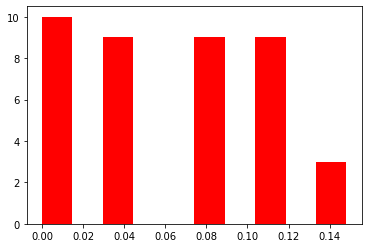

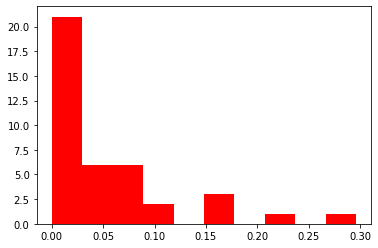

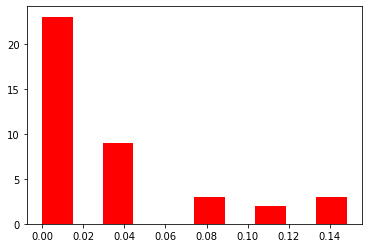

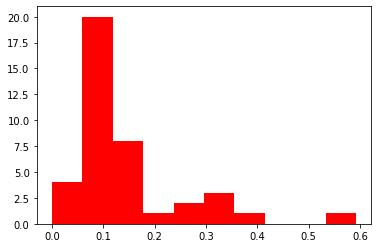

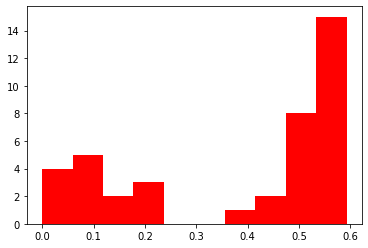

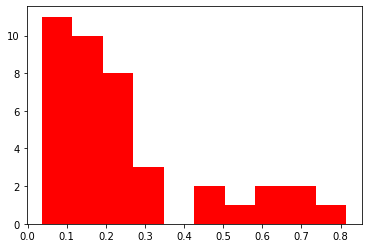

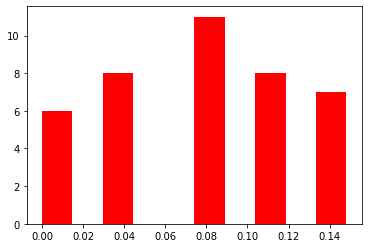

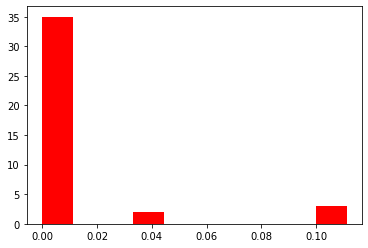

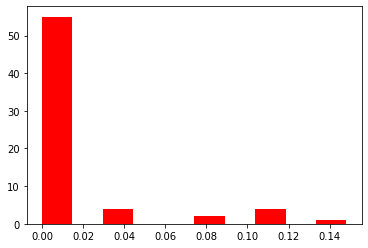

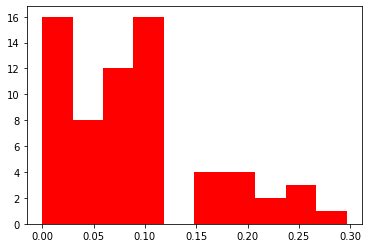

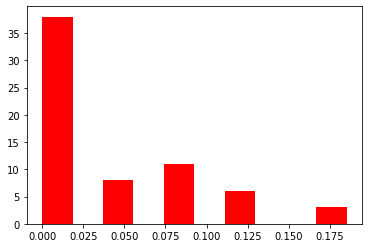

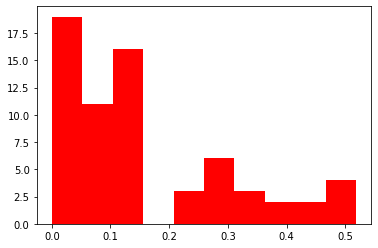

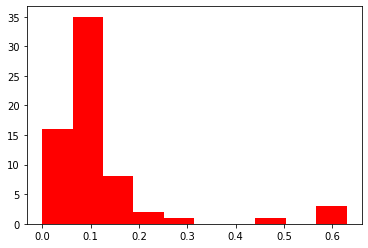

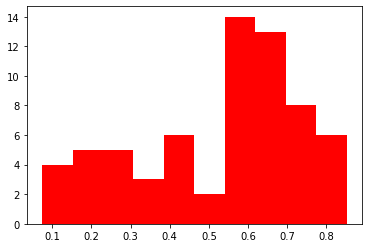

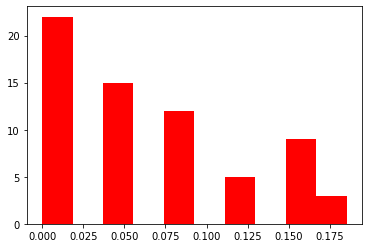

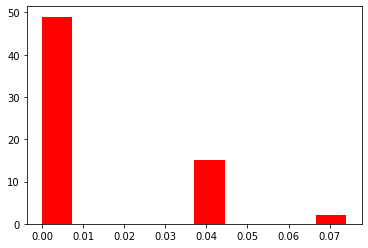

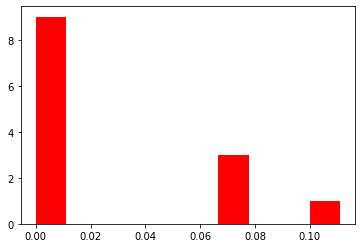

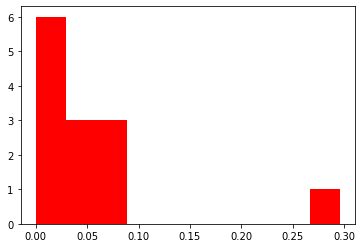

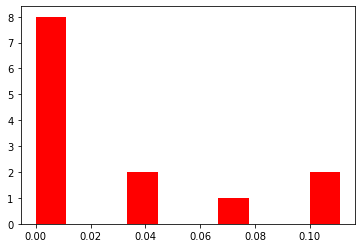

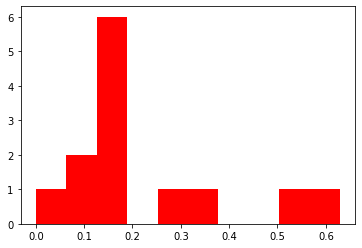

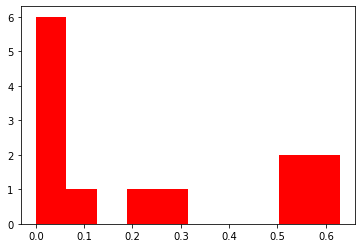

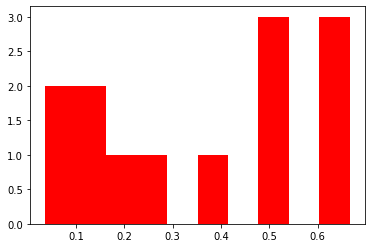

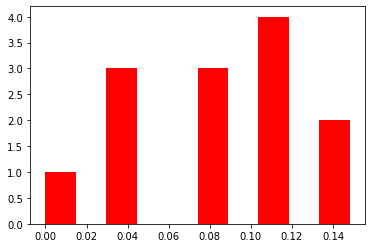

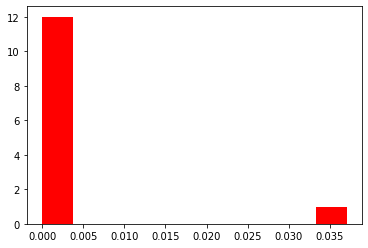

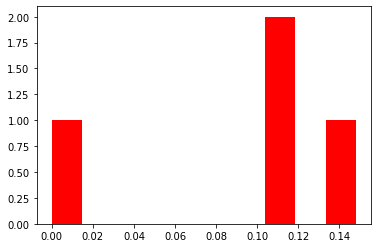

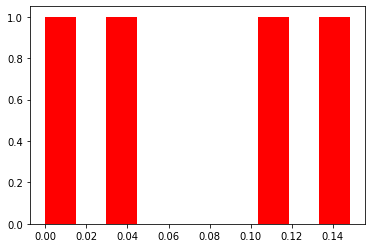

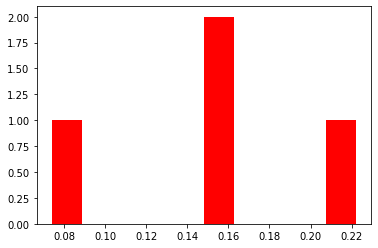

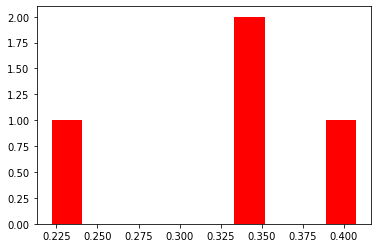

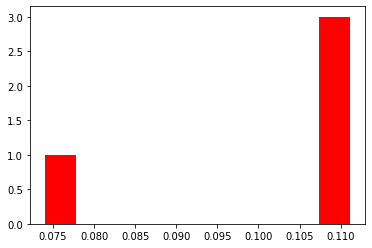

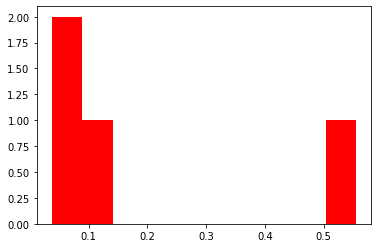

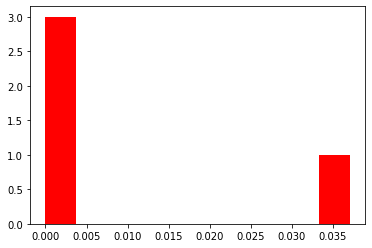

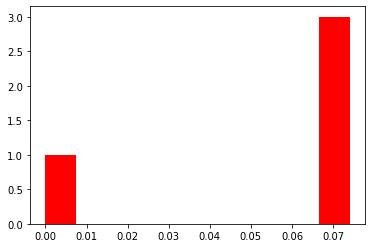

getting full data of random runs from Telencephalon
freq labels in this region:
['100', '250', '500', '750', '1000', '1500', '2000', '2500']


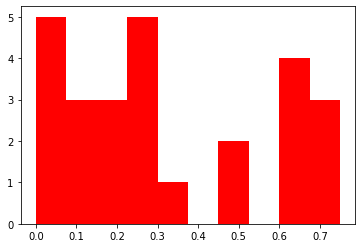

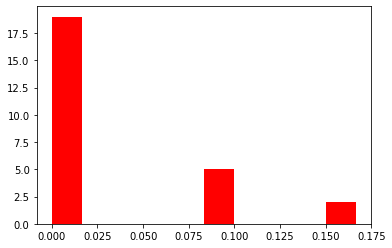

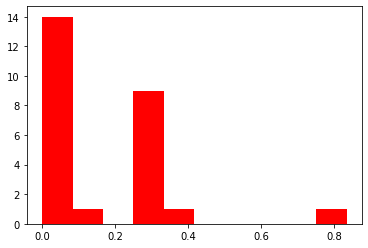

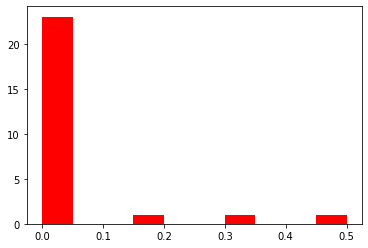

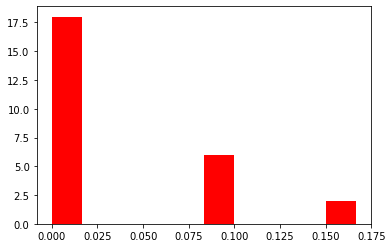

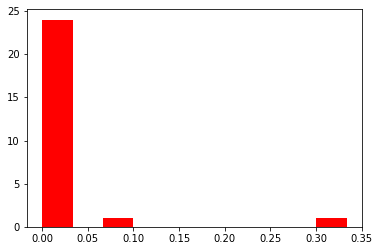

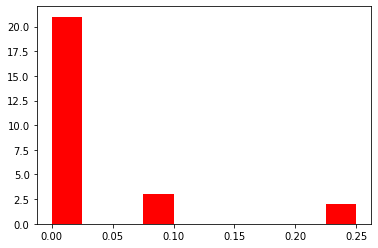

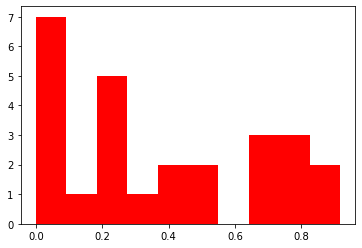

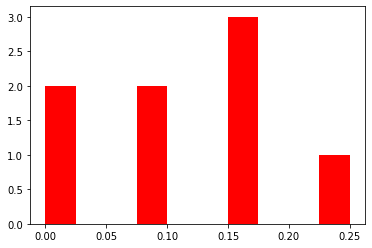

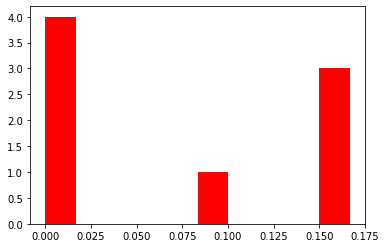

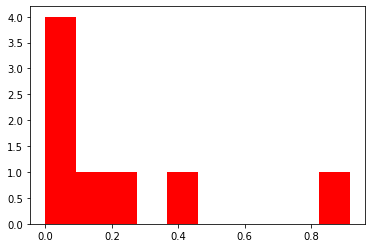

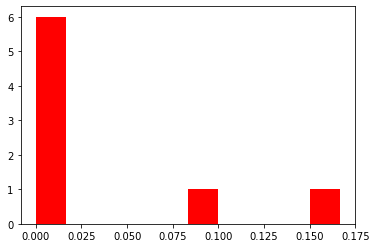

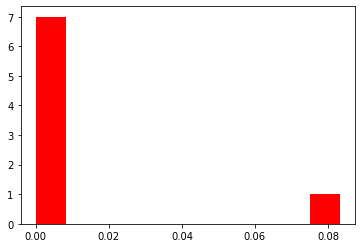

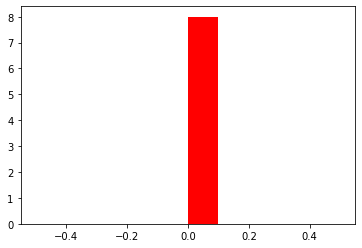

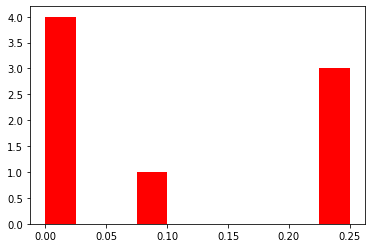

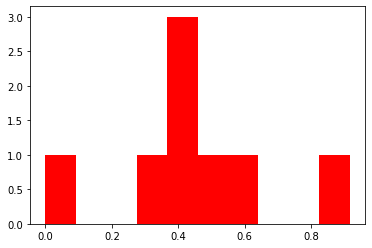

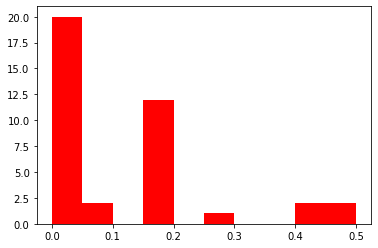

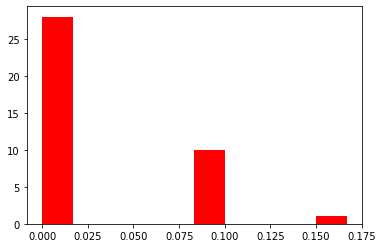

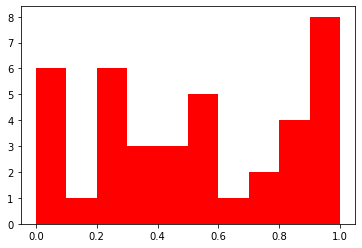

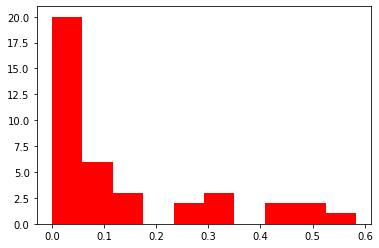

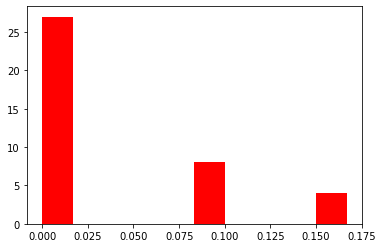

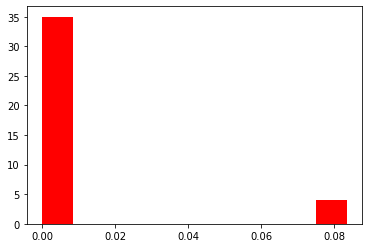

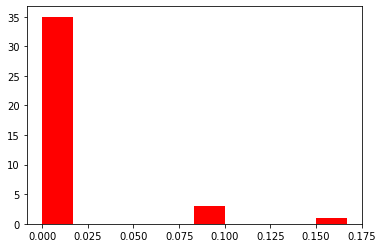

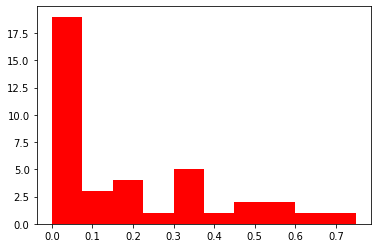

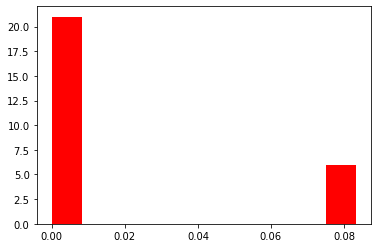

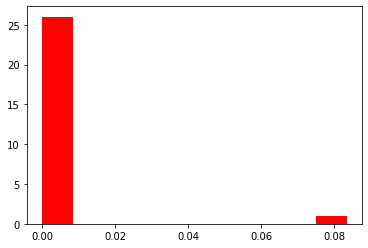

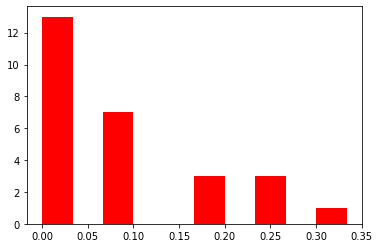

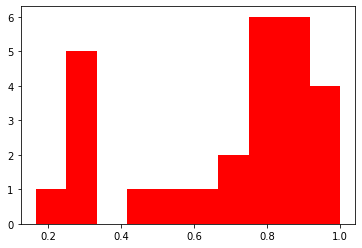

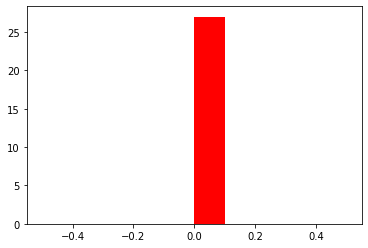

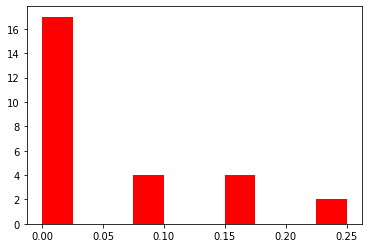

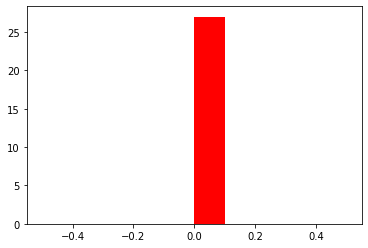

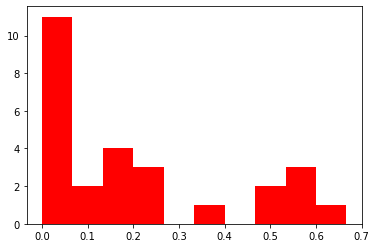

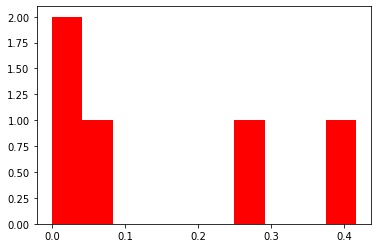

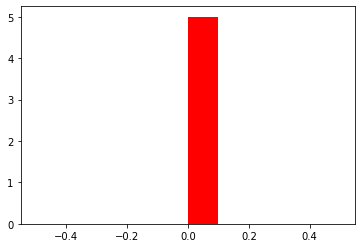

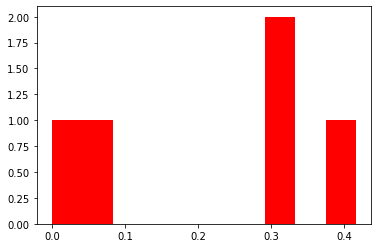

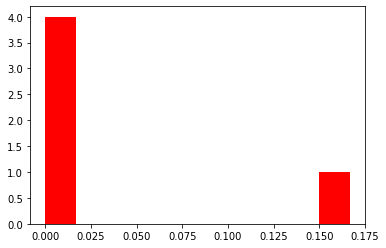

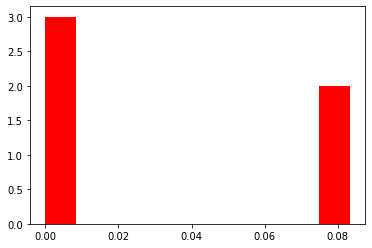

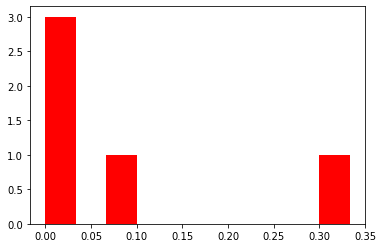

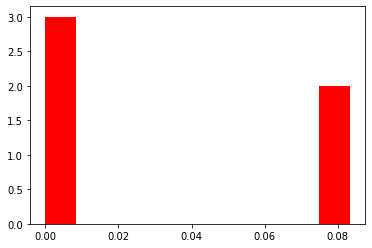

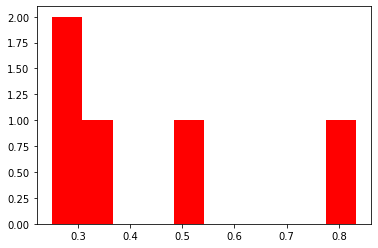

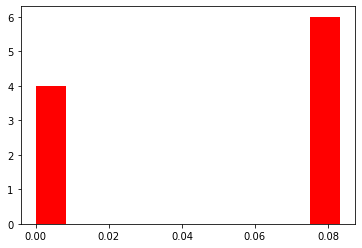

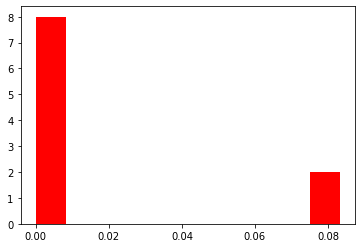

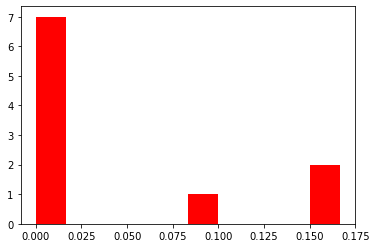

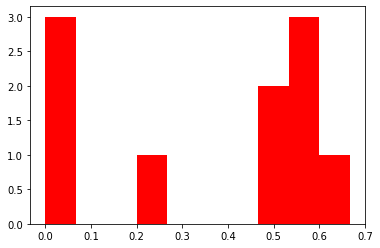

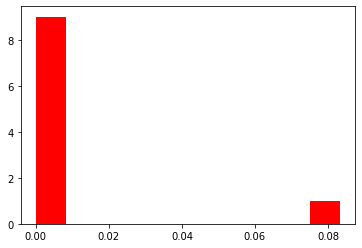

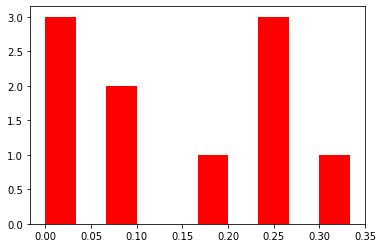

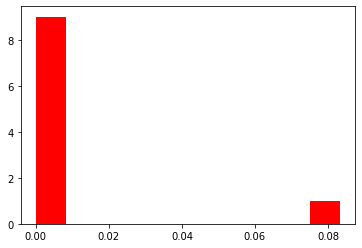

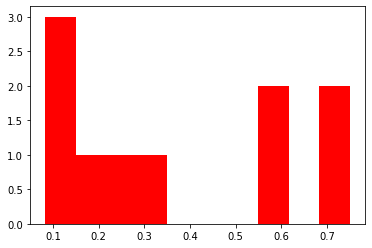

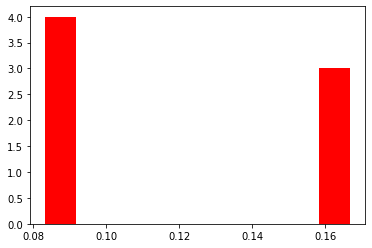

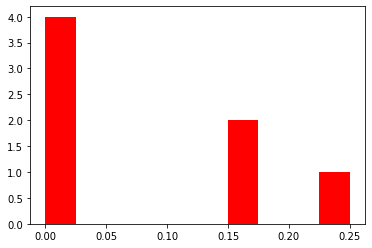

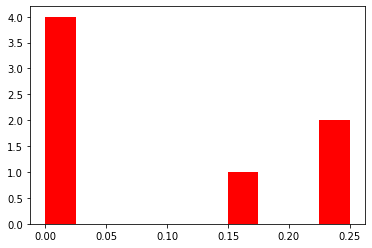

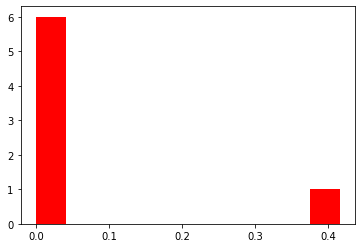

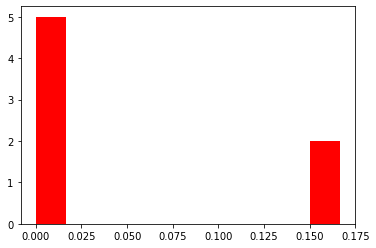

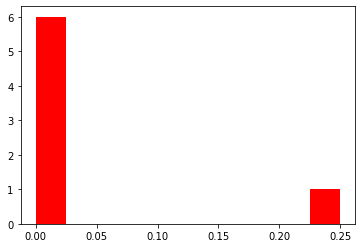

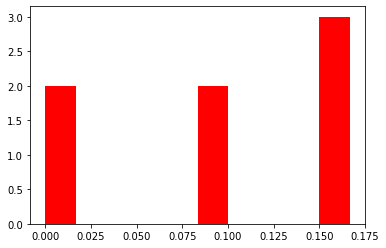

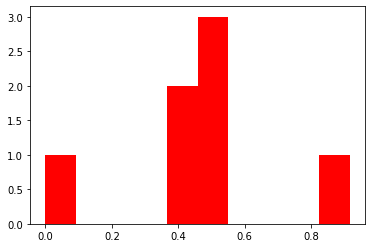

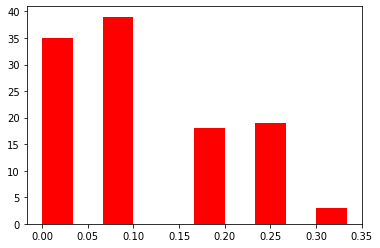

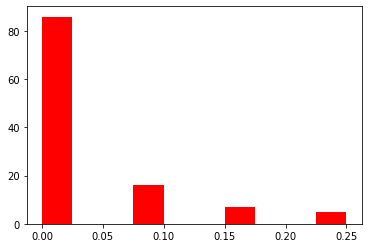

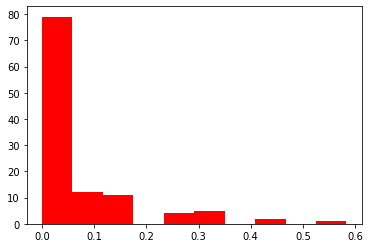

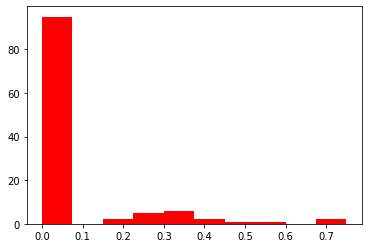

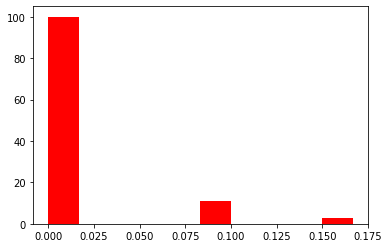

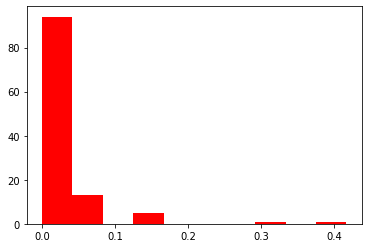

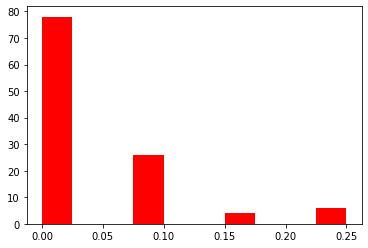

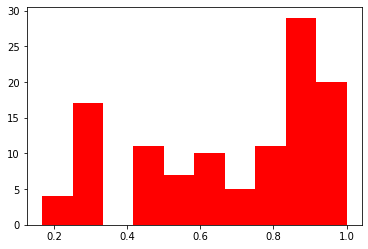

In [10]:
#you may run this once to save raw distributions of neigbor fractions
for brain_reg, freqs_dict in neighbor_dist.items():
    print("getting full data of random runs from {}".format(brain_reg))
    freq_list = list(freqs_dict.keys())
    print('freq labels in this region:')
    print(freq_list)

    for freq, neighbor_frac in freqs_dict.items():
        df = pd.DataFrame(neighbor_frac, columns=freq_list)
        
        if save_flag:
            df.to_csv(folder_path + '\\' + brain_reg + '_' + freq + '_RAW' +'_full_data.csv')
        for col in df.columns:
            plt.hist(df[col],color='red')
            plt.show()

In [11]:
condensed_rand_summary = {}
condensed_summary = {}

str_labels_TS = ['100', '250', '500', '750', '1000', '1500', '2500']
str_labels = ['100', '250', '500', '750', '1000', '1500', '2000', '2500']

# mean of the means 
# here you will find some hard coded computations to compute a summarized and tidy version of the results and store in 
# condensed_rand_summary and condensed_summary
for brain_region, frequencies_dicts in neighbor_dist_rand_summary.items():
    condensed_rand_summary.update({brain_region : {'mean': None, 'std' : None}})
    condensed_summary.update({brain_region : {'mean': None, 'std' : None}})
    
    if key == 'TS':
        df_rand = pd.DataFrame(columns = str_labels_TS)
        df = pd.DataFrame(columns = str_labels_TS)
        df_rand_std = pd.DataFrame(columns = str_labels_TS)
        df_std = pd.DataFrame(columns = str_labels_TS)
    else:
        df_rand = pd.DataFrame(columns = str_labels)
        df = pd.DataFrame(columns = str_labels)
        df_rand_std = pd.DataFrame(columns = str_labels)
        df_std = pd.DataFrame(columns = str_labels)
        
    for freq, mean_std_dict in neighbor_dist_rand_summary[brain_region].items():
        df_rand[freq] = copy.copy(np.mean(neighbor_dist_rand_summary[brain_region][freq]['mean'], axis=0)).T
        df[freq] = neighbor_dist_summary[brain_region][freq]['mean'].T
        df_rand_std[freq] = copy.copy(np.mean(neighbor_dist_rand_summary[brain_region][freq]['std'], axis=0)).T
        df_std[freq] = neighbor_dist_summary[brain_region][freq]['std'].T
        
        for variable, values in neighbor_dist_rand_summary[brain_region][freq].items():
            #print(brain_region, freq, variable)
            #print(np.mean(neighbor_dist_rand_summary[brain_region][freq][variable], axis=0))
            neighbor_dist_rand_mean_summary[brain_region][freq][variable] = np.mean(neighbor_dist_rand_summary[brain_region][freq][variable], axis=0)
        
    condensed_rand_summary[brain_region]['mean'] = df_rand
    condensed_summary[brain_region]['mean'] = df
    condensed_rand_summary[brain_region]['std'] = df_rand_std
    condensed_summary[brain_region]['std'] = df_std
    

Cerebellum
    freq main_freq  fraction
0    100       100  0.102778
1    250       100  0.047222
2    500       100  0.063889
3    750       100  0.238889
4   1000       100  0.150000
..   ...       ...       ...
59   750      2500  0.115152
60  1000      2500  0.143939
61  1500      2500  0.306061
62  2000      2500  0.050000
63  2500      2500  0.139394

[64 rows x 3 columns]


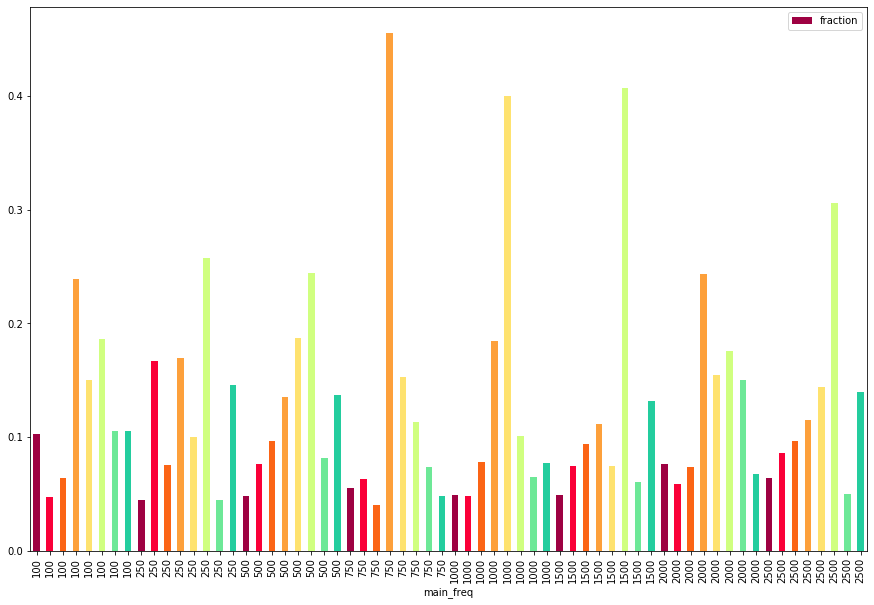

Hindbrain
    freq main_freq  fraction
0    100       100  0.201245
1    250       100  0.149131
2    500       100  0.062602
3    750       100  0.216650
4   1000       100  0.113405
..   ...       ...       ...
59   750      2500  0.192791
60  1000      2500  0.112103
61  1500      2500  0.223545
62  2000      2500  0.076720
63  2500      2500  0.136574

[64 rows x 3 columns]


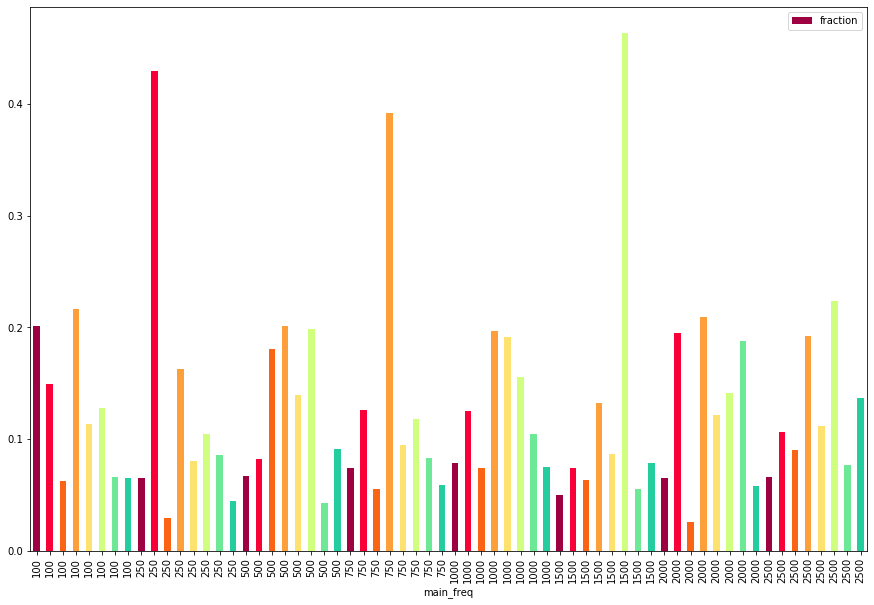

OLN
    freq main_freq  fraction
0    100       100  0.086957
1    250       100  0.125858
2    500       100  0.137300
3    750       100  0.228833
4   1000       100  0.082380
..   ...       ...       ...
59   750      2500  0.299342
60  1000      2500  0.057018
61  1500      2500  0.078947
62  2000      2500  0.030702
63  2500      2500  0.223684

[64 rows x 3 columns]


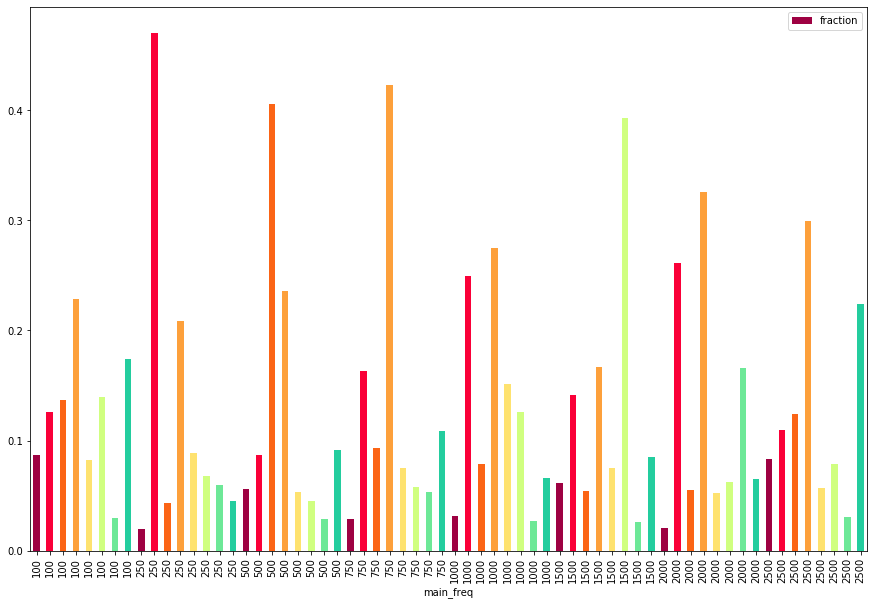

TS
    freq main_freq    fraction
0    100       100   0.0363636
1    250       100    0.418182
2    500       100   0.0363636
3    750       100         0.4
4   1000       100   0.0363636
5   1500       100           0
6   2500       100   0.0909091
7    100       250   0.0454545
8    250       250    0.557851
9    500       250   0.0578512
10   750       250    0.258264
11  1000       250   0.0268595
12  1500       250  0.00826446
13  2500       250   0.0495868
14   100       500    0.020202
15   250       500    0.323232
16   500       500    0.171717
17   750       500    0.313131
18  1000       500    0.010101
19  1500       500    0.131313
20  2500       500    0.030303
21   100       750   0.0287687
22   250       750    0.171461
23   500       750   0.0299194
24   750       750    0.601841
25  1000       750   0.0333717
26  1500       750   0.0529344
27  2500       750   0.0863061
28   100      1000   0.0227273
29   250      1000        0.25
30   500      1000   0.0227273
31   

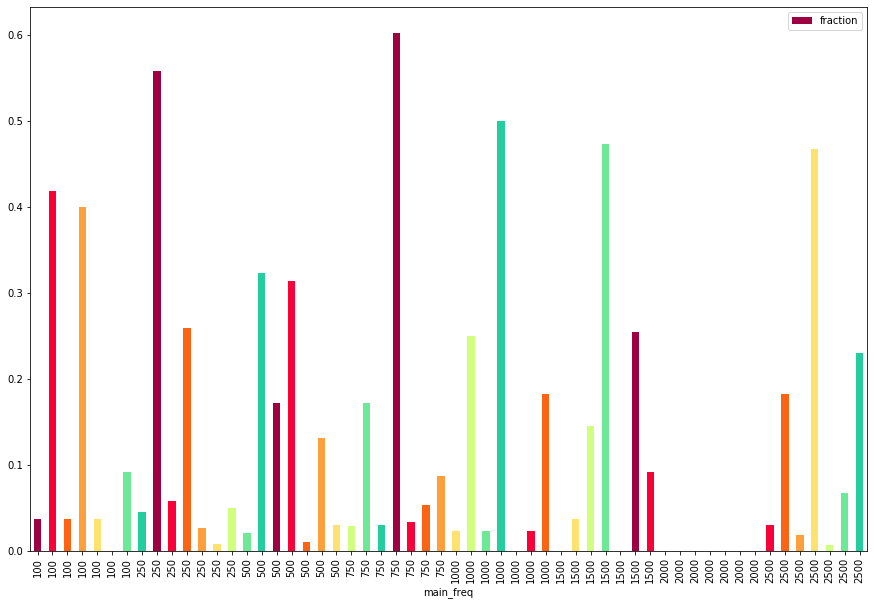

Tectum
    freq main_freq  fraction
0    100       100  0.170040
1    250       100  0.396761
2    500       100  0.149798
3    750       100  0.056680
4   1000       100  0.040486
..   ...       ...       ...
59   750      2500  0.064685
60  1000      2500  0.194056
61  1500      2500  0.047203
62  2000      2500  0.045455
63  2500      2500  0.234266

[64 rows x 3 columns]


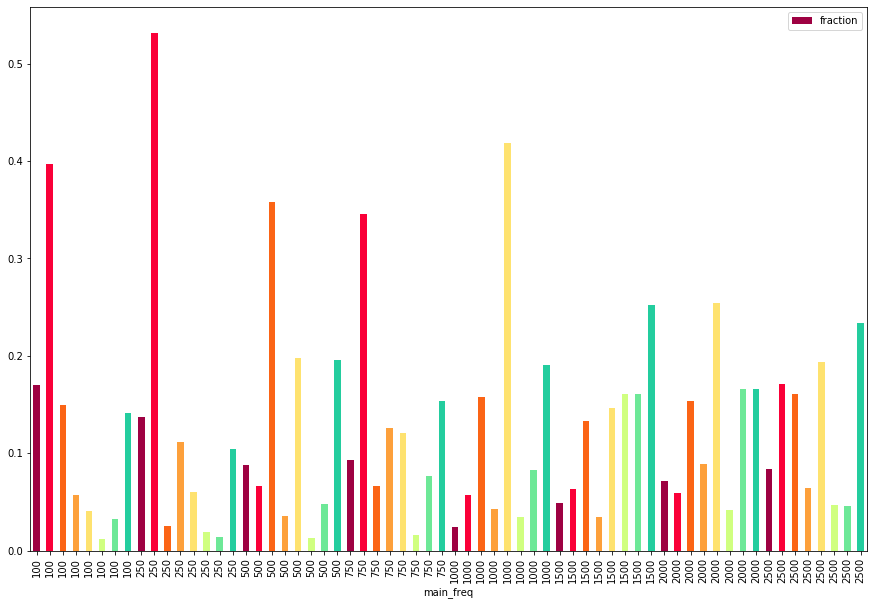

Tegmentum
    freq main_freq  fraction
0    100       100  0.069444
1    250       100  0.055556
2    500       100  0.092593
3    750       100  0.287037
4   1000       100  0.300926
..   ...       ...       ...
59   750      2500  0.324074
60  1000      2500  0.101852
61  1500      2500  0.194444
62  2000      2500  0.009259
63  2500      2500  0.055556

[64 rows x 3 columns]


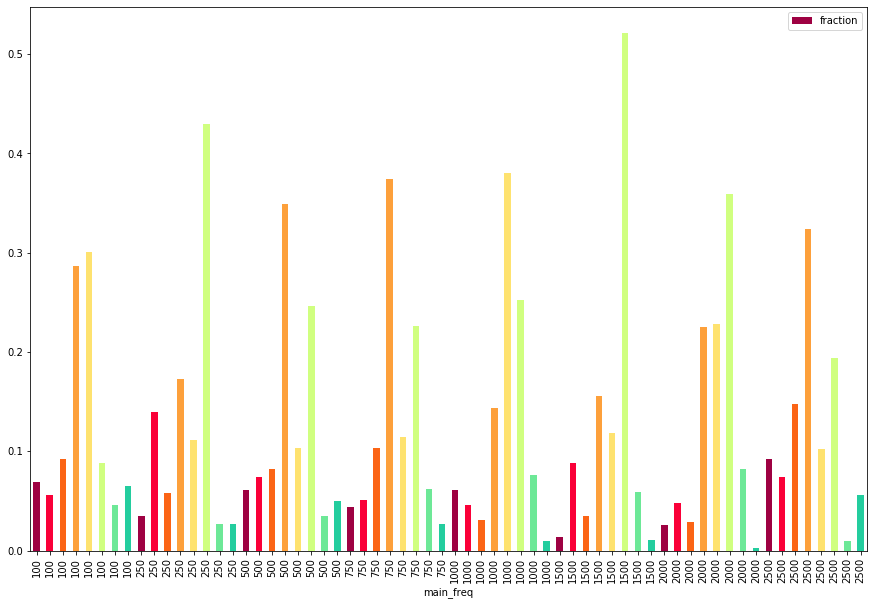

Telencephalon
    freq main_freq  fraction
0    100       100  0.317308
1    250       100  0.028846
2    500       100  0.160256
3    750       100  0.038462
4   1000       100  0.032051
..   ...       ...       ...
59   750      2500  0.061404
60  1000      2500  0.012427
61  1500      2500  0.023392
62  2000      2500  0.038012
63  2500      2500  0.671784

[64 rows x 3 columns]


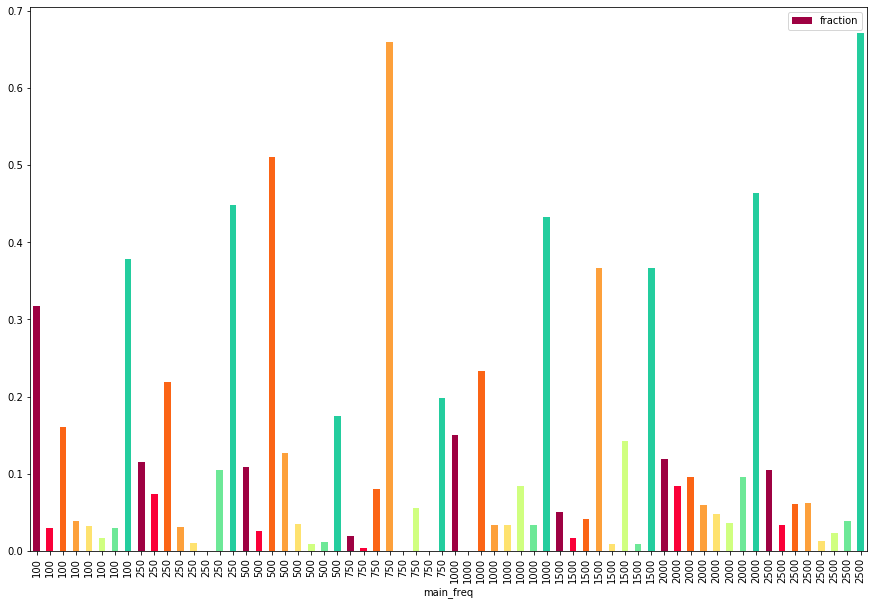

    freq main_freq  fraction
0    100       100  0.056451
1    250       100  0.085752
2    500       100  0.046564
3    750       100  0.203822
4   1000       100  0.192209
..   ...       ...       ...
59   750      2500  0.109049
60  1000      2500  0.144473
61  1500      2500  0.191785
62  2000      2500  0.063960
63  2500      2500  0.097513

[64 rows x 3 columns]
    freq main_freq  fraction
0    100       100  0.166940
1    250       100  0.218890
2    500       100  0.077295
3    750       100  0.157152
4   1000       100  0.095581
..   ...       ...       ...
59   750      2500  0.183867
60  1000      2500  0.101606
61  1500      2500  0.178032
62  2000      2500  0.107835
63  2500      2500  0.093256

[64 rows x 3 columns]
    freq main_freq  fraction
0    100       100  0.083013
1    250       100  0.113774
2    500       100  0.187364
3    750       100  0.191099
4   1000       100  0.105064
..   ...       ...       ...
59   750      2500  0.187057
60  1000      2500  0.0694

In [12]:
# plot results using barplot (does not look very good but helps in data inspection)
colors = [[158,1,66,255],[250,0,56,255],[251,100,21,255],[253,160,59,255],[254,226,111,255],[208,255,128,255],[109,232,151,255],[35,205,158,255]] #,[16,129,191,255],[104,45,162,255]]
colors = [tuple(i/255 for i in item) for item in colors]

for brain_region, values in condensed_summary.items():
    print(brain_region)
    fig, ax = plt.subplots(figsize=(15,10))  
    
    labels = np.array([100, 250, 500, 750, 1000, 1500, 2000, 2500])
    if brain_region == 'TS':
        labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])
    
    values['mean']['freq'] = labels
    formatted_df = pd.melt(values['mean'],
                       ['freq'],
                       var_name='main_freq',
                       value_name='fraction')
    print(formatted_df)
    for row, freq in enumerate(labels):
        formatted_df.plot(kind='bar', x='main_freq',y='fraction', ax=ax, label=None, stacked=True, color=colors)
        plt.show()
    
    # controlled by save_flag defined a few cells above
    if save_flag:
        formatted_df.to_csv(folder_path + '\\' + brain_region +'_summary_raw_kNN_fractions.csv')
    
for brain_region, values in condensed_summary.items():
    labels = np.array([100, 250, 500, 750, 1000, 1500, 2000, 2500])
    if brain_region == 'TS':
        labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])
    
    values['std']['freq'] = labels
    formatted_df = pd.melt(values['std'],
                       ['freq'],
                       var_name='main_freq',
                       value_name='fraction')
    print(formatted_df)

    
    # controlled by save_flag defined a few cells above
    if save_flag:
        formatted_df.to_csv(folder_path + '\\' + brain_region +'_summary_raw_kNN_fractions_std.csv')

Cerebellum
    freq main_freq  fraction
0    100       100  0.056155
1    250       100  0.073167
2    500       100  0.077993
3    750       100  0.211764
4   1000       100  0.181010
..   ...       ...       ...
59   750      2500  0.217296
60  1000      2500  0.180426
61  1500      2500  0.228366
62  2000      2500  0.070473
63  2500      2500  0.102681

[64 rows x 3 columns]


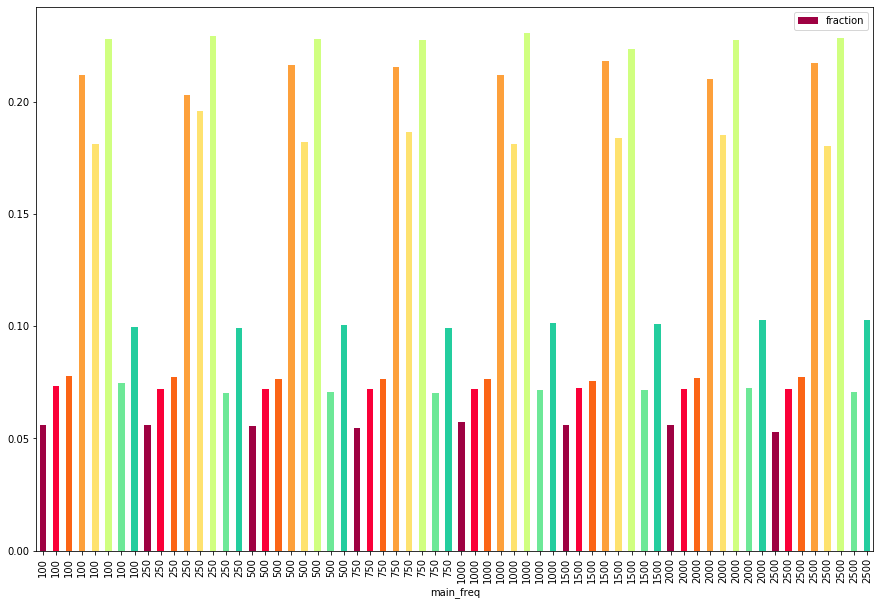

Hindbrain
    freq main_freq  fraction
0    100       100  0.076079
1    250       100  0.171216
2    500       100  0.063446
3    750       100  0.226638
4   1000       100  0.110576
..   ...       ...       ...
59   750      2500  0.223126
60  1000      2500  0.110390
61  1500      2500  0.202576
62  2000      2500  0.087023
63  2500      2500  0.069641

[64 rows x 3 columns]


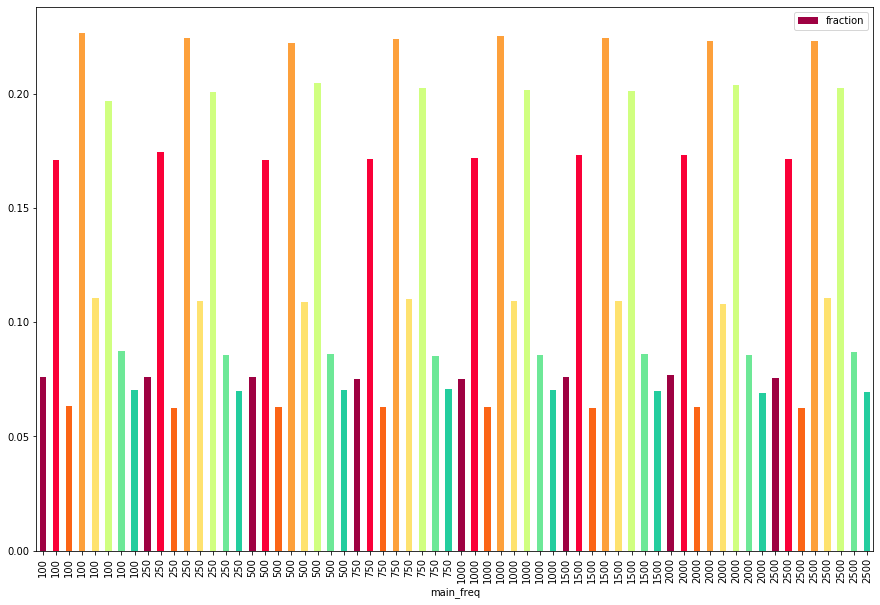

OLN
    freq main_freq  fraction
0    100       100  0.040905
1    250       100  0.228001
2    500       100  0.123320
3    750       100  0.284790
4   1000       100  0.077216
..   ...       ...       ...
59   750      2500  0.281886
60  1000      2500  0.080773
61  1500      2500  0.107349
62  2000      2500  0.050272
63  2500      2500  0.095938

[64 rows x 3 columns]


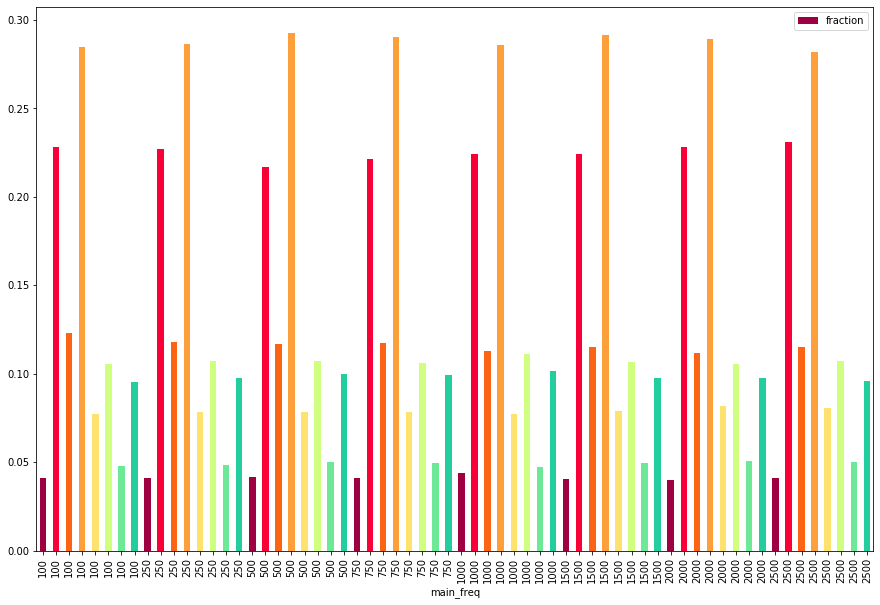

TS
    freq main_freq   fraction
0    100       100  0.0337856
1    250       100    0.27984
2    500       100  0.0437709
3    750       100   0.478574
4   1000       100  0.0257808
5   1500       100  0.0515633
6   2500       100  0.0917149
7    100       250  0.0299557
8    250       250   0.282666
9    500       250  0.0500772
10   750       250   0.466998
11  1000       250  0.0259907
12  1500       250  0.0585369
13  2500       250  0.0896649
14   100       500  0.0336611
15   250       500   0.310603
16   500       500  0.0490966
17   750       500   0.445882
18  1000       500  0.0265712
19  1500       500   0.052699
20  2500       500  0.0845514
21   100       750   0.031577
22   250       750   0.284973
23   500       750  0.0513249
24   750       750   0.466418
25  1000       750  0.0244829
26  1500       750  0.0553228
27  2500       750   0.089727
28   100      1000  0.0286025
29   250      1000   0.270792
30   500      1000   0.056596
31   750      1000   0.468365
32  100

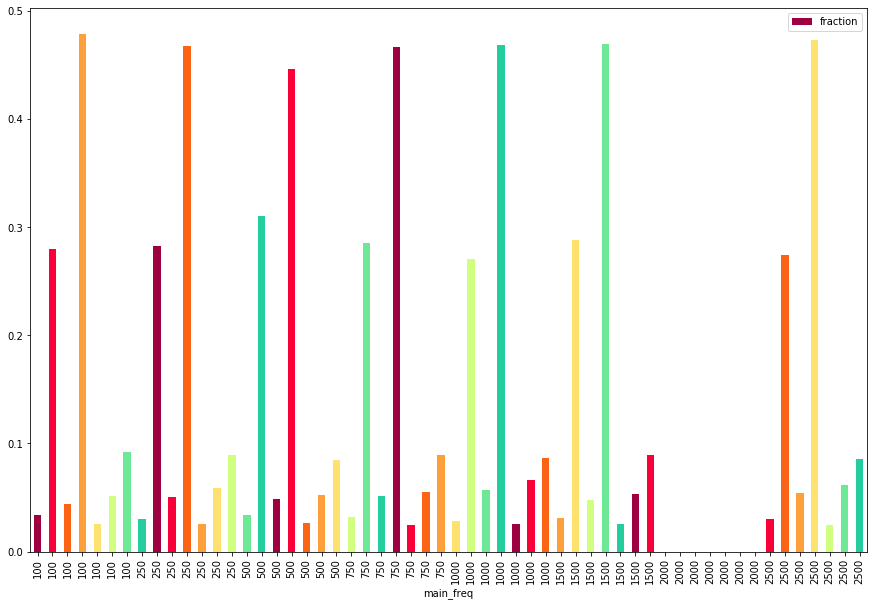

Tectum
    freq main_freq  fraction
0    100       100  0.086483
1    250       100  0.219600
2    500       100  0.162476
3    750       100  0.068693
4   1000       100  0.193558
..   ...       ...       ...
59   750      2500  0.070134
60  1000      2500  0.184867
61  1500      2500  0.035534
62  2000      2500  0.061559
63  2500      2500  0.175979

[64 rows x 3 columns]


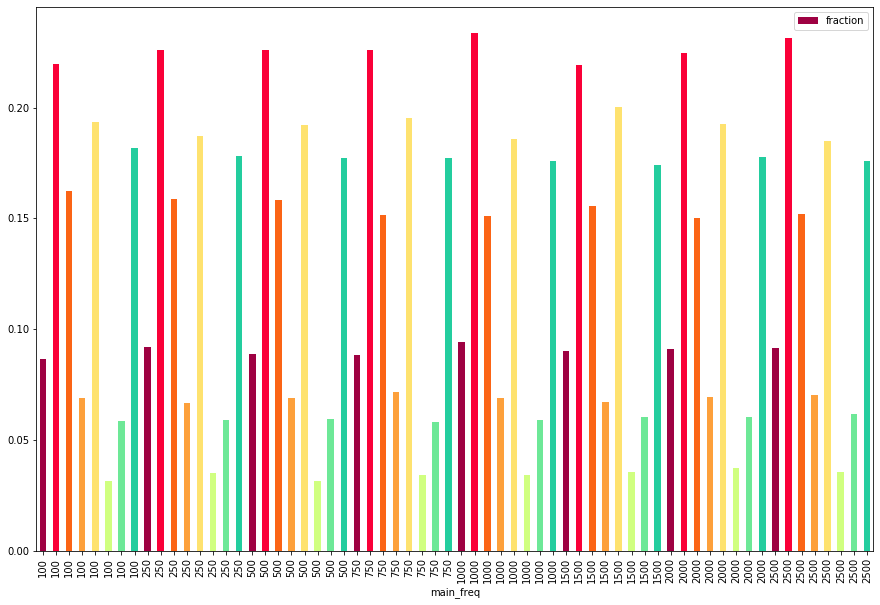

Tegmentum
    freq main_freq  fraction
0    100       100  0.042410
1    250       100  0.075009
2    500       100  0.060135
3    750       100  0.226192
4   1000       100  0.174065
..   ...       ...       ...
59   750      2500  0.215695
60  1000      2500  0.171847
61  1500      2500  0.355046
62  2000      2500  0.055167
63  2500      2500  0.023753

[64 rows x 3 columns]


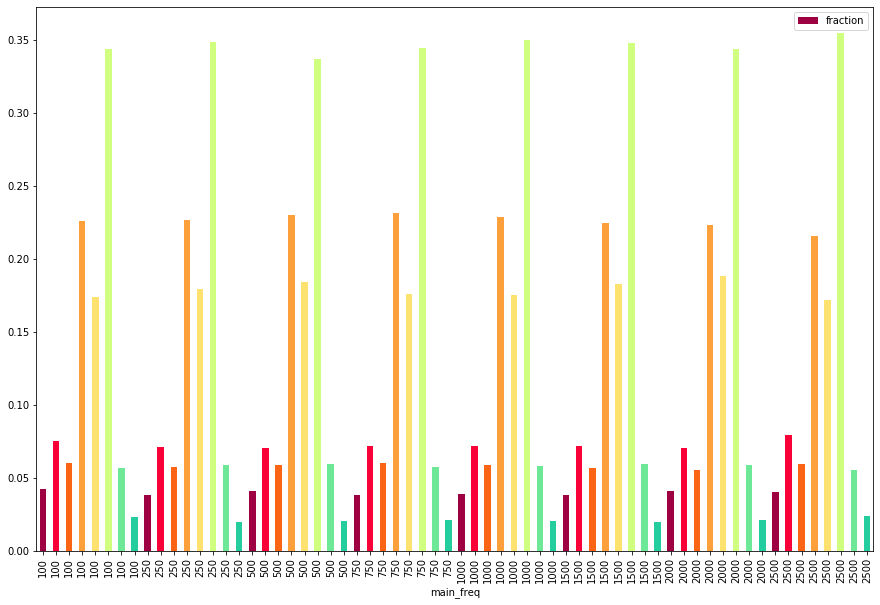

Telencephalon
    freq main_freq  fraction
0    100       100  0.121393
1    250       100  0.030455
2    500       100  0.161771
3    750       100  0.138797
4   1000       100  0.018380
..   ...       ...       ...
59   750      2500  0.149980
60  1000      2500  0.017808
61  1500      2500  0.030302
62  2000      2500  0.030726
63  2500      2500  0.470010

[64 rows x 3 columns]


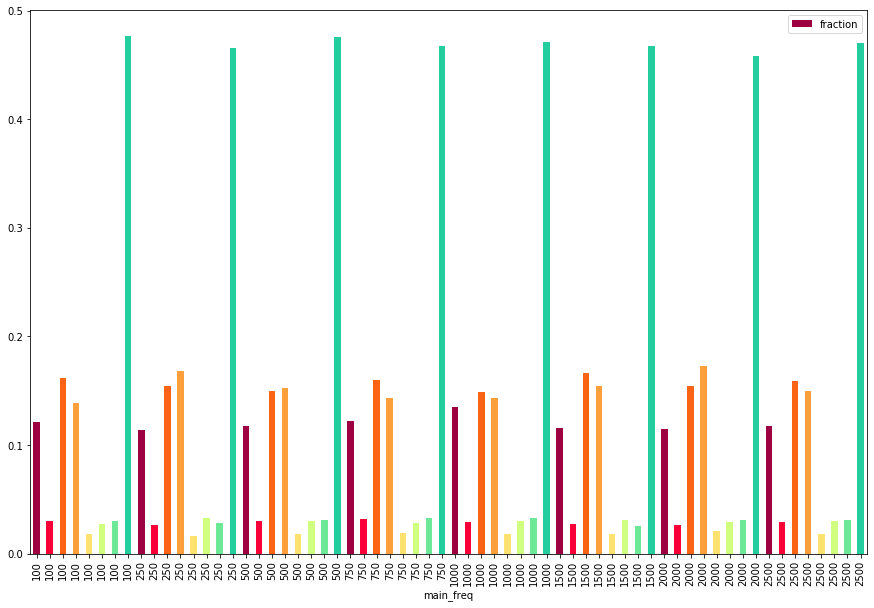

In [16]:
# plot results using barplot (again, it does not look very good but helps in data inspection)
colors = [[158,1,66,255],[250,0,56,255],[251,100,21,255],[253,160,59,255],[254,226,111,255],[208,255,128,255],[109,232,151,255],[35,205,158,255]] #,[16,129,191,255],[104,45,162,255]]
colors = [tuple(i/255 for i in item) for item in colors]

for brain_region, values in condensed_rand_summary.items():
    print(brain_region)
    fig, ax = plt.subplots(figsize=(15,10))  
    labels = np.array([100, 250, 500, 750, 1000, 1500, 2000, 2500])
    if brain_region == 'TS':
        labels = np.array([100, 250, 500, 750, 1000, 1500, 2500])
    
    values['mean']['freq'] = labels
    formatted_df = pd.melt(values['mean'],
                       ['freq'],
                       var_name='main_freq',
                       value_name='fraction')
    print(formatted_df)
    for row, freq in enumerate(labels):
        formatted_df.plot(kind='bar', x='main_freq',y='fraction', ax=ax, label=None, stacked=True, color=colors)
        plt.show()
    
    # controlled by save_flag defined a few cells above
    if save_flag:
        formatted_df.to_csv(folder_path + '\\' + brain_region +'_summary_random_'+ str(n_iter) +'_kNN_fractions_mean.csv') 
    
    values['std']['freq'] = labels
    formatted_df = pd.melt(values['std'],
                       ['freq'],
                       var_name='main_freq',
                       value_name='fraction')
    # controlled by save_flag defined a few cells above
    if save_flag:
        formatted_df.to_csv(folder_path + '\\' + brain_region +'_summary_random_'+ str(n_iter) +'_kNN_fractions_std.csv') 
    
    

In [ ]:
np.save(folder_path + '\\' + 'neighbor_dist_rand_summary.npy', condensed_rand_summary)
np.save(folder_path + '\\' + 'neighbor_dist_summary.npy', neighbor_dist_summary)